# Distributed Registration of Large-scale Lightsheet Data

In this notebook we apply the `itk_dreg` framework to register large-scale, multiresolution lightsheet images to an atlas.

## Dependencies

We use experimental tools developed in the `AllenNeuralDynamics/aind-ccf-alignment-experiments` repository to stream SmartSPIM image subregions from the cloud. https://github.com/AllenNeuralDynamics/aind-ccf-alignment-experiments

## Inputs

1. Target (fixed) image. The CCF v3.1 atlas with updated spacing and spatial orientation is available in NIFTI format at http://download.alleninstitute.org/informatics-archive/converted_mouse_ccf/average_template/. More information on the CCF atlas is available at http://help.brain-map.org/display/mouseconnectivity/API
2. Source (moving) image. Stitched SmartSPIM mouse brain images are available on the AWS S3 \"aind-open-data\" bucket in Zarr format. The largest resolution / smallest image size is used here for performance considerations.

## References

1. Quanxin Wang, et. al. The Allen Mouse Brain Common Coordinate Framework: A 3D Reference Atlas, Cell, Volume 181, Issue 4, 2020, Pages 936-953.e20, ISSN 0092-8674, https://doi.org/10.1016/j.cell.2020.04.007

In [1]:
# Parameters can be programmatically overridden with `papermill`

FIXED_IMAGE_URL = r"http://download.alleninstitute.org/informatics-archive/converted_mouse_ccf/average_template/average_template_25.nii.gz"

MOVING_IMAGE_URL = r"s3://aind-open-data/SmartSPIM_652506_2023-01-09_10-18-12_stitched_2023-02-09_17-23-28/processed/OMEZarr/Ex_561_Em_593.zarr"

MOVING_RESOLUTION_COUNT = 5

INPUT_DIR = "input/data"

OUTPUT_DIR = r"output/LightsheetRegistration"

In [2]:
import os
import logging
import functools
from urllib.request import urlretrieve

import dask
import dask.array as da
import dask.distributed
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import itk

itk.auto_progress(1)

# `itk_dreg` core components
import itk_dreg
import itk_dreg.register
import itk_dreg.block.image
import itk_dreg.itk

# `itk_dreg` implementation submodules
import itk_dreg.elastix.serialize
import itk_dreg.elastix.register
import itk_dreg.reduce_dfield.dreg
import itk_dreg.reduce_dfield.matrix_transform

# experimental aind_ccf_alignment_experiments components
import aind_ccf_alignment_experiments.smartspim as aind_smartspim
import aind_ccf_alignment_experiments.url as aind_url

itk.auto_progress(0)

Loading ITKPyBase... Loading ITKPyBase... Loading ITKCommon... Loading ITKCommon... Loading ITKStatistics... Loading ITKStatistics... Loading ITKImageFilterBase... Loading ITKImageFilterBase... Loading ITKTransform... Loading ITKTransform... Loading ITKMesh... Loading ITKMesh... Loading ITKImageFunction... Loading ITKImageFunction... Loading ITKSpatialObjects... Loading ITKSpatialObjects... Loading ITKImageCompose... Loading ITKImageCompose... Loading ITKImageStatistics... Loading ITKImageStatistics... Loading ITKPath... Loading ITKPath... Loading ITKImageGrid... Loading ITKImageGrid... Loading ITKImageIntensity... Loading ITKImageIntensity... Loading ITKThresholding... Loading ITKThresholding... Loading ITKSignedDistanceFunction... Loading ITKSignedDistanceFunction... Loading ITKOptimizers... Loading ITKOptimizers... Loading ITKFiniteDifference... Loading ITKFiniteDifference... Loading ITKCurvatureFlow... Loading ITKCurvatureFlow... Loading ITKNarrowBand... Loading ITKNarrowBand... Lo

In [4]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
# TODO log to common file

os.makedirs(INPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

## Retrieve and Understand Data

1. The CCF atlas image fits in memory, so we save it to disk and visualize it here.
2. The SmartSPIM sample image includes multiple downsampled resolutions, so we pull the lowest resolution and visualize it here.

In [7]:
PIXEL_TYPE = itk.F
DIMENSION = 3

FIXED_IMAGE_FILEPATH = os.path.abspath(f'{INPUT_DIR}/{FIXED_IMAGE_URL.split("/")[-1]}')
if not os.path.exists(FIXED_IMAGE_FILEPATH):
    logger.info(f"Retrieving from {FIXED_IMAGE_URL} to {FIXED_IMAGE_FILEPATH}")
    urlretrieve(FIXED_IMAGE_URL, FIXED_IMAGE_FILEPATH)

smartspim_info = aind_url.parse_smartspim_bucket_path(MOVING_IMAGE_URL)
smartspim_lowest_res = MOVING_RESOLUTION_COUNT - 1
MOVING_IMAGE_FILEPATH = (
    f"{INPUT_DIR}/{smartspim_info.subject_id}_{smartspim_info.stitched_date}"
    f"/{smartspim_info.channel_id}/{smartspim_lowest_res}.mha"
)
moving_inspect_reader = aind_smartspim.make_smartspim_stream_reader(
    bucket_zarr_path=MOVING_IMAGE_URL, sample_level=smartspim_lowest_res
)
if not os.path.exists(MOVING_IMAGE_FILEPATH):
    os.makedirs(os.path.dirname(MOVING_IMAGE_FILEPATH), exist_ok=True)
    logger.info(f"Retrieving from {MOVING_IMAGE_URL} to {MOVING_IMAGE_FILEPATH}")
    moving_inspect_reader.UpdateLargestPossibleRegion()
    itk.imwrite(
        moving_inspect_reader.GetOutput(), MOVING_IMAGE_FILEPATH, compression=True
    )

In [6]:
# Understand approximate physical and voxel extents of the fixed image to register

fixed_image = itk.imread(FIXED_IMAGE_FILEPATH, pixel_type=PIXEL_TYPE)
print(
    f"The fixed image has voxel size {itk.size(fixed_image)}"
    f" and occupies the approximate physical region"
    f" {itk_dreg.block.image.image_to_physical_region(fixed_image.GetLargestPossibleRegion(), fixed_image)}"
)

moving_image = moving_inspect_reader.GetOutput()
print(
    f"The moving image has voxel size {itk.size(moving_image)}"
    f" and occupies the approximate physical region"
    f" {itk_dreg.block.image.image_to_physical_region(moving_image.GetLargestPossibleRegion(), moving_image)}"
)

The fixed image has voxel size itkSize3 ([528, 320, 456]) and occupies the approximate physical region [[-1.13875002e+01 -1.25000002e-02 -7.98750012e+00]
 [ 1.25000002e-02  1.31875002e+01  1.25000002e-02]]
The moving image has voxel size itkSize3 ([464, 642, 231]) and occupies the approximate physical region [[-1.44000e-02 -1.44000e-02 -1.60000e-02]
 [ 1.33488e+01  1.84752e+01  7.37600e+00]]


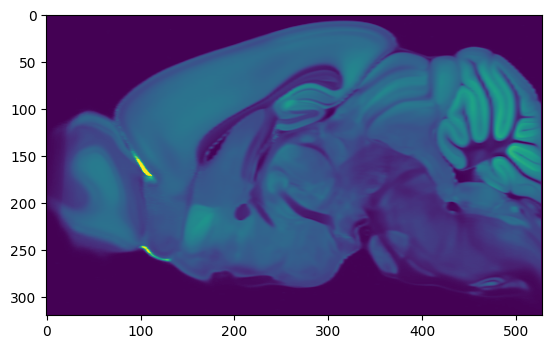

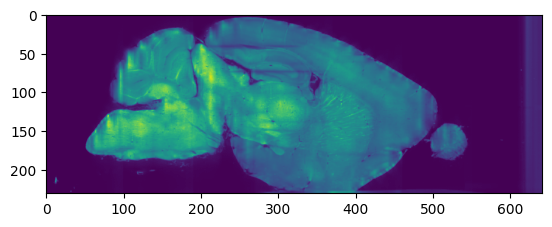

In [7]:
plt.imshow(fixed_image[250, :, :])
plt.show()
plt.imshow(moving_image[:, :, 150])
plt.show()

In [8]:
# The `itk_dreg` framework does not require the fixed or moving image buffer to be directly provided.
# We can remove them from memory for now.
del fixed_image
del moving_image
del moving_inspect_reader

## Define Registration Components

In this section we construct the necessary components to build a distributed registration pipeline with `itk_dreg`.

We follow a multiresolution, multistage registration schedule as follows:

0. Translation for overlap
1. In-memory whole-image global registration: SmartSPIM Level 4 to CCF 25um atlas
  1. Elastix rigid registration
  2. Elastix affine registration
2. Distributed piecewise deformable registration: SmartSPIM Level 3 to CCF 25um atlas
  1. Elastix B-Spline registration with reduction to deformation field

In [9]:
N_STAGES = 3

### Methods

In [19]:
# Define how each dask node should create a reader to stream fixed and moving subimages
fixed_reader_ctors = [
    functools.partial(
        itk_dreg.itk.make_reader,
        filepath=FIXED_IMAGE_FILEPATH,
        image_type=itk.Image[PIXEL_TYPE, DIMENSION],
    )
] * 3

moving_reader_ctors = [
    # Lowest resolution (level 4)
    functools.partial(
        aind_smartspim.make_smartspim_stream_reader,
        bucket_zarr_path=MOVING_IMAGE_URL,
        sample_level=smartspim_lowest_res,
    ),
    functools.partial(
        aind_smartspim.make_smartspim_stream_reader,
        bucket_zarr_path=MOVING_IMAGE_URL,
        sample_level=smartspim_lowest_res,
    ),
    # Higher resolution (level 3)
    functools.partial(
        aind_smartspim.make_smartspim_stream_reader,
        bucket_zarr_path=MOVING_IMAGE_URL,
        sample_level=smartspim_lowest_res - 1,
    ),
]

In [20]:
# Set up registration methods
import importlib

importlib.reload(itk_dreg.elastix.register)

ELASTIX_LOG_DIR = f"{OUTPUT_DIR}/elxlog"
os.makedirs(ELASTIX_LOG_DIR, exist_ok=True)

stage_log_directories = [
    f"{ELASTIX_LOG_DIR}/{stage_id}" for stage_id in range(N_STAGES)
]

for log_directory in stage_log_directories:
    os.makedirs(log_directory, exist_ok=True)

# Second and third stages use Elastix
parameter_objects = [None, itk.ParameterObject.New(), itk.ParameterObject.New()]

# Second stage performs global rigid+affine registration
parameter_objects[1].AddParameterMap(
    itk.ParameterObject.GetDefaultParameterMap("rigid")
)
parameter_objects[1].AddParameterMap(
    itk.ParameterObject.GetDefaultParameterMap("affine")
)

# Third stage performs deformable B-spline registration
bspline_map = itk.ParameterObject.GetDefaultParameterMap("bspline")
bspline_map["FinalGridSpacingInPhysicalUnits"] = ("20.0",)
parameter_objects[2].AddParameterMap(bspline_map)

serializable_parameter_objects = [
    itk_dreg.elastix.serialize.parameter_object_to_list(parameter_object)
    if parameter_object
    else None
    for parameter_object in parameter_objects
]

itk_transform_types = [
    [itk.TranslationTransform[itk.D, 3]],
    [itk.AffineTransform[itk.D, 3], itk.Euler3DTransform[itk.D]],
    [itk.BSplineTransform[itk.D, 3, 3]],
]

# Third stage uses `itk_dreg`
block_registration_methods = [
    None,
    None,
    functools.partial(
        itk_dreg.elastix.register.ElastixDRegBlockPairRegistrationMethod(),
        log_directory=stage_log_directories[2],
        elx_parameter_object_serial=serializable_parameter_objects[2],
        itk_transform_types=itk_transform_types[2],
        preprocess_initial_transform=True,
    ),
]

In [12]:
# Set up reduction methods for `itk_dreg`

reduction_methods = [
    None,
    None,
    functools.partial(
        itk_dreg.reduce_dfield.dreg.ReduceToDisplacementFieldMethod(),
        displacement_grid_scale_factors=[8.0] * DIMENSION,
    ),
]

### Data

In [13]:
# TODO fixed array chunk size should correspond to moving array chunk physical size
fixed_chunk_sizes = [None, None, (300, 360, 360)]

In [14]:
overlap_factors = [None, None, [0.3] * DIMENSION]

## Perform Registration

In [15]:
transform_results = {}

from typing import Dict, List


def flatten_composite_transform(
    transform: itk.Transform,
) -> itk.CompositeTransform[itk.D, 3]:
    """
    Recursively flatten an `itk.CompositeTransform` that may contain
    `itk.CompositeTransform` members so that the output represents a
    single layer of non-composite transforms.
    """
    inner_transforms = _flatten_composite_transform_recursive(transform)

    output_transform = itk.CompositeTransform[itk.D, 3].New()
    for transform in inner_transforms:
        output_transform.AppendTransform(transform)
    return output_transform


def _flatten_composite_transform_recursive(
    transform: itk.Transform,
) -> List[itk.Transform]:
    t = None
    try:
        t = itk.CompositeTransform[itk.D, 3].cast(transform)
    except RuntimeError as e:
        return [transform]

    transform_list = []
    for index in range(t.GetNumberOfTransforms()):
        transform_list += [
            *_flatten_composite_transform_recursive(t.GetNthTransform(index))
        ]
    return transform_list


def make_composite_transform(
    transform_results: Dict, last_stage: int
) -> itk.CompositeTransform[itk.D, 3]:
    transform = itk.CompositeTransform[itk.D, 3].New()
    for stage in range(last_stage + 1):
        transform.PrependTransform(transform_results[stage])
    return flatten_composite_transform(transform)

### Stage 0

In [16]:
STAGE_ID = 0
logger.info(f"Running registration stage {STAGE_ID}")
transform_results[STAGE_ID] = itk_dreg.elastix.util.compute_initial_translation(
    target_image=fixed_reader_ctors[STAGE_ID]().GetOutput(),  # unbuffered image
    source_image=moving_reader_ctors[STAGE_ID]().GetOutput(),  # unbuffered image
)

logger.info(
    f"Registration stage {STAGE_ID} returned result {transform_results[STAGE_ID]}"
)

INFO:__main__:Running registration stage 0
INFO:__main__:Registration stage 0 returned result TranslationTransform (0000028AC4E3C860)
  RTTI typeinfo:   class itk::TranslationTransform<double,3>
  Reference Count: 1
  Modified Time: 1221
  Debug: Off
  Object Name: 
  Observers: 
    none
  Offset: [12.3547, 2.6429, 7.6675]



### Stage 1

In [17]:
STAGE_ID = 1
PREV_STAGE = STAGE_ID - 1

fixed_reader = fixed_reader_ctors[STAGE_ID]()
fixed_reader.Update()

moving_reader = moving_reader_ctors[STAGE_ID]()
moving_reader.Update()

registration_method = itk.ElastixRegistrationMethod[
    type(fixed_reader.GetOutput()), type(moving_reader.GetOutput())
].New()
registration_method.SetFixedImage(fixed_reader.GetOutput())
registration_method.SetMovingImage(moving_reader.GetOutput())
registration_method.SetParameterObject(parameter_objects[STAGE_ID])
registration_method.SetExternalInitialTransform(
    make_composite_transform(transform_results, PREV_STAGE)
)
registration_method.SetLogToFile(True)
registration_method.SetOutputDirectory(stage_log_directories[STAGE_ID])
registration_method.SetLogFileName(f"Stage{STAGE_ID}Log.txt")

logger.info(f"Running registration stage {STAGE_ID}")
registration_method.Update()

INFO:__main__:Running registration stage 1


In [18]:
transform_results[STAGE_ID] = itk_dreg.elastix.register.get_elx_itk_transforms(
    registration_method, [*itk_transform_types[STAGE_ID], None]
)
logger.info(
    f"Registration stage {STAGE_ID} returned result {transform_results[STAGE_ID]}"
)

INFO:__main__:Registration stage 1 returned result CompositeTransform (0000028AC7E5A2E0)
  RTTI typeinfo:   class itk::CompositeTransform<double,3>
  Reference Count: 1
  Modified Time: 2053
  Debug: Off
  Object Name: 
  Observers: 
    none
  TransformQueue: 
  >>>>>>>>>
  AffineTransform (0000028AC7F5F550)
    RTTI typeinfo:   class itk::AffineTransform<double,3>
    Reference Count: 1
    Modified Time: 69615
    Debug: Off
    Object Name: 
    Observers: 
      none
    Matrix: 
      1.06511 0.00119081 -0.00673718 
      -0.0115727 1.04849 0.00226307 
      0.00860204 0.015486 0.960818 
    Offset: [-0.523011, -0.501525, -0.123924]
    Center: [7.04917, 9.29233, 3.36529]
    Translation: [-0.0756782, -0.124904, -0.0512446]
    Inverse: 
      0.938808 -0.00116351 0.00658559 
      0.0103806 0.953773 -0.00217369 
      -0.0085723 -0.015362 1.04076 
    Singular: 0
  >>>>>>>>>
  Euler3DTransform (0000028AC563F890)
    RTTI typeinfo:   class itk::Euler3DTransform<double>
    Refere

### Stage 2

In [21]:
STAGE_ID = 2
PREV_STAGE = STAGE_ID - 1

schedule_result = itk_dreg.register.register_images(
    fixed_chunk_size=fixed_chunk_sizes[STAGE_ID],
    initial_transform=make_composite_transform(transform_results, PREV_STAGE),
    moving_reader_ctor=moving_reader_ctors[STAGE_ID],
    fixed_reader_ctor=fixed_reader_ctors[STAGE_ID],
    block_registration_method=block_registration_methods[STAGE_ID],
    reduce_method=reduction_methods[STAGE_ID],
    overlap_factors=overlap_factors[STAGE_ID],
)
print(schedule_result)

INFO:itk_dreg.register:Preparing registration task graph...


RegistrationScheduleResult(registration_result=Delayed('compose_output-045add58-7348-4650-b40d-79a0d50dde0c'), fixed_da=dask.array<rechunk-merge, shape=(456, 320, 528), dtype=float32, chunksize=(300, 320, 360), chunktype=numpy.ndarray>)


In [22]:
schedule_result.fixed_da

dask.array<rechunk-merge, shape=(456, 320, 528), dtype=float32, chunksize=(300, 320, 360), chunktype=numpy.ndarray>

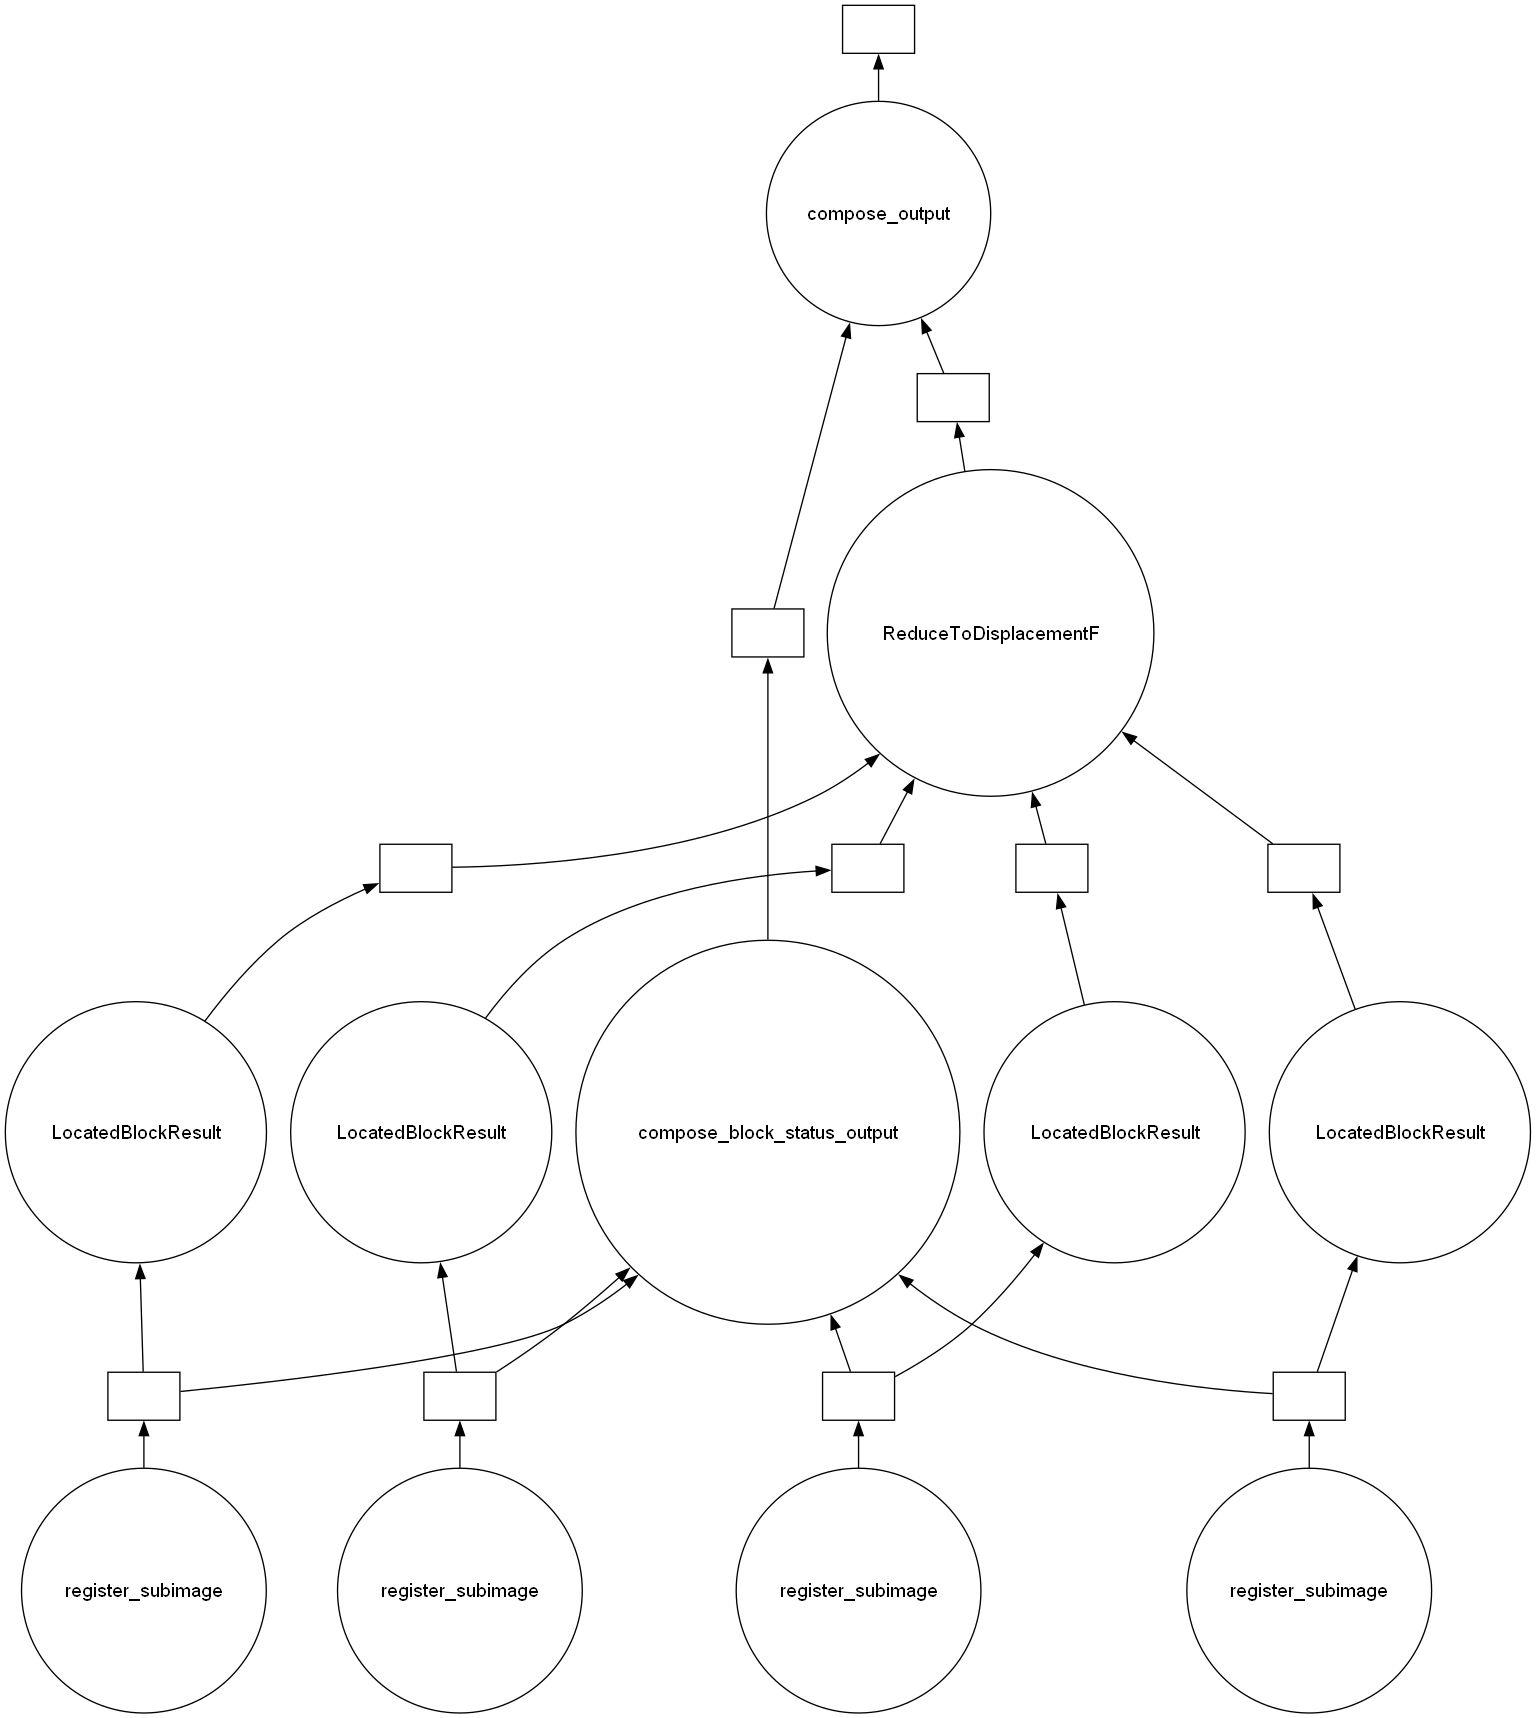

In [23]:
schedule_result.registration_result.visualize()

#### TODO: Distributed processing with `LocalCluster`

By default `dask.delayed` runs in parallel on a single local client. We can emulate distributed processing with a `dask.distributed.LocalCluster` with a pre-determined number of workers and threads per worker.

Distributed processing with ITK-DReg requires that unbuffered `itk.Image` results are serializable, which will be introduced in ITK v5.4rc03.

Read more: https://github.com/InsightSoftwareConsortium/ITK/issues/4267

#### Run registration

In [24]:
logger.info(f"Running registration stage {STAGE_ID}")
logging.root.setLevel(logging.DEBUG)
itk.auto_progress(0)
try:
    result = schedule_result.registration_result.compute()
finally:
    logging.root.setLevel(logging.INFO)

INFO:__main__:Running registration stage 2
2023-11-09 13:45:19,933 - distributed.worker - INFO - Entering "register subimage" with block BlockInfo(chunk_index=(0, 0, 0), array_slice=(slice(0, 300, None), slice(0, 320, None), slice(0, 360, None)))
DEBUG:itk_dreg.register:['0', '0', '0'] -> Fixed block has unpadded region itkImageRegion3([0, 0, 0], [360, 320, 300]) and padded region itkImageRegion3([0, 0, 0], [414, 320, 345])
2023-11-09 13:45:19,937 - distributed.worker - INFO - Entering "register subimage" with block BlockInfo(chunk_index=(1, 0, 0), array_slice=(slice(300, 456, None), slice(0, 320, None), slice(0, 360, None)))
2023-11-09 13:45:19,951 - distributed.worker - INFO - Entering "register subimage" with block BlockInfo(chunk_index=(1, 0, 1), array_slice=(slice(300, 456, None), slice(0, 320, None), slice(360, 528, None)))
DEBUG:itk_dreg.register:['1', '0', '0'] -> Fixed block has unpadded region itkImageRegion3([0, 0, 300], [360, 320, 156]) and padded region itkImageRegion3([0,

DEBUG:botocore.hooks:Event before-parameter-build.s3.HeadObject: calling handler <function generate_idempotent_uuid at 0x0000028AC743A3E0>
DEBUG:botocore.hooks:Event before-endpoint-resolution.s3: calling handler <function customize_endpoint_resolver_builtins at 0x0000028AC7460900>
DEBUG:botocore.hooks:Event before-endpoint-resolution.s3: calling handler <bound method S3RegionRedirectorv2.redirect_from_cache of <aiobotocore.utils.AioS3RegionRedirectorv2 object at 0x0000028AC9351AD0>>
DEBUG:aiobotocore.regions:Calling endpoint provider with parameters: {'Bucket': 'aind-open-data', 'Region': 'us-west-2', 'UseFIPS': False, 'UseDualStack': False, 'ForcePathStyle': False, 'Accelerate': False, 'UseGlobalEndpoint': False, 'DisableMultiRegionAccessPoints': False, 'UseArnRegion': True}
DEBUG:aiobotocore.regions:Endpoint provider result: https://aind-open-data.s3.us-west-2.amazonaws.com
DEBUG:botocore.regions:Selecting from endpoint provider's list of auth schemes: "sigv4". User selected auth sc

DEBUG:botocore.hooks:Event before-parameter-build.s3.HeadObject: calling handler <function generate_idempotent_uuid at 0x0000028AC743A3E0>
DEBUG:botocore.hooks:Event before-endpoint-resolution.s3: calling handler <function customize_endpoint_resolver_builtins at 0x0000028AC7460900>
DEBUG:botocore.hooks:Event before-endpoint-resolution.s3: calling handler <bound method S3RegionRedirectorv2.redirect_from_cache of <aiobotocore.utils.AioS3RegionRedirectorv2 object at 0x0000028AC9351AD0>>
DEBUG:aiobotocore.regions:Calling endpoint provider with parameters: {'Bucket': 'aind-open-data', 'Region': 'us-west-2', 'UseFIPS': False, 'UseDualStack': False, 'ForcePathStyle': False, 'Accelerate': False, 'UseGlobalEndpoint': False, 'DisableMultiRegionAccessPoints': False, 'UseArnRegion': True}
DEBUG:aiobotocore.regions:Endpoint provider result: https://aind-open-data.s3.us-west-2.amazonaws.com
DEBUG:botocore.regions:Selecting from endpoint provider's list of auth schemes: "sigv4". User selected auth sc

DEBUG:aiobotocore.regions:Endpoint provider result: https://aind-open-data.s3.us-west-2.amazonaws.com
DEBUG:botocore.regions:Selecting from endpoint provider's list of auth schemes: "sigv4". User selected auth scheme is: "<botocore.UNSIGNED object at 0x0000028AC7168710>"
DEBUG:botocore.hooks:Event before-call.s3.GetObject: calling handler <function add_expect_header at 0x0000028AC743A980>
DEBUG:botocore.hooks:Event before-call.s3.GetObject: calling handler <function add_recursion_detection_header at 0x0000028AC7438F40>
DEBUG:botocore.hooks:Event before-call.s3.GetObject: calling handler <function inject_api_version_header_if_needed at 0x0000028AC743BEC0>
DEBUG:botocore.endpoint:Making request for OperationModel(name=GetObject) with params: {'url_path': '/SmartSPIM_652506_2023-01-09_10-18-12/acquisition.json', 'query_string': {}, 'method': 'GET', 'headers': {'Range': 'bytes=0-78298', 'If-Match': '"e7ab382b3f190496ac6e8b6af357ac74"', 'User-Agent': 'Botocore/1.31.64 ua/2.0 os/windows#10 m

DEBUG:s3fs:CALL: get_object - () - {'Bucket': 'aind-open-data', 'Key': 'SmartSPIM_652506_2023-01-09_10-18-12/acquisition.json', 'Range': 'bytes=0-78298', 'IfMatch': '"e7ab382b3f190496ac6e8b6af357ac74"'}
DEBUG:s3fs:Fetch: aind-open-data/SmartSPIM_652506_2023-01-09_10-18-12/acquisition.json, 0-78299
DEBUG:botocore.hooks:Event before-parameter-build.s3.GetObject: calling handler <function sse_md5 at 0x0000028AC743A660>
DEBUG:botocore.hooks:Event before-parameter-build.s3.GetObject: calling handler <function validate_bucket_name at 0x0000028AC743A5C0>
DEBUG:botocore.hooks:Event before-parameter-build.s3.GetObject: calling handler <function remove_bucket_from_url_paths_from_model at 0x0000028AC7460720>
DEBUG:botocore.hooks:Event before-parameter-build.s3.GetObject: calling handler <bound method S3RegionRedirectorv2.annotate_request_context of <aiobotocore.utils.AioS3RegionRedirectorv2 object at 0x0000028AC9351AD0>>
DEBUG:botocore.hooks:Event before-parameter-build.s3.GetObject: calling hand

DEBUG:botocore.hooks:Event request-created.s3.GetObject: calling handler <function add_retry_headers at 0x0000028AC7460680>
DEBUG:botocore.endpoint:Sending http request: <AWSPreparedRequest stream_output=True, method=GET, url=https://aind-open-data.s3.us-west-2.amazonaws.com/SmartSPIM_652506_2023-01-09_10-18-12/acquisition.json, headers={'Range': b'bytes=0-78298', 'If-Match': b'"e7ab382b3f190496ac6e8b6af357ac74"', 'User-Agent': b'Botocore/1.31.64 ua/2.0 os/windows#10 md/arch#amd64 lang/python#3.11.5 md/pyimpl#CPython cfg/retry-mode#legacy', 'amz-sdk-invocation-id': b'd011c444-8b60-40eb-bd53-270b74992028', 'amz-sdk-request': b'attempt=1'}>
DEBUG:botocore.parsers:Response headers: HTTPHeaderDict({'x-amz-id-2': 'sKsVdH3gulFZfneItL5YZrVMjzSrP2sZ/cBYvlfrMkB5vKIECpKXF//acqxStoAg9vF/axA6UbI=', 'x-amz-request-id': '7HPAD2BX0WP143MW', 'date': 'Thu, 09 Nov 2023 18:45:25 GMT', 'last-modified': 'Thu, 18 May 2023 19:14:59 GMT', 'etag': '"e7ab382b3f190496ac6e8b6af357ac74"', 'x-amz-server-side-encryp

2023-11-09 13:46:11,173 - distributed.worker - WARNING - (1, 0, 1): Resampling fixed image
DEBUG:itk_dreg.elastix.register:Resampling fixed image to initial domain [[ 0.97127617 10.38879033 -0.18119105]
 [ 6.09635768 17.02424651  8.21763764]]
INFO:itk_dreg.elastix.register:Writing buffered subimages to output/LightsheetRegistration/elxlog/2/1-0-1
2023-11-09 13:46:15,869 - distributed.worker - INFO - Entering Elastix registration
INFO:itk_dreg.elastix.register:(1, 0, 1): Running pairwise registration
2023-11-09 13:46:15,987 - distributed.worker - INFO - Entering Elastix registration
DEBUG:itk_dreg.elastix.register:(1, 0, 0): Elastix logs will be written to output/LightsheetRegistration/elxlog/2/1-0-0
2023-11-09 13:46:16,022 - distributed.worker - INFO - Entering Elastix registration
DEBUG:itk_dreg.elastix.register:(1, 0, 0): Register with parameter object:ParameterObject (0000028AC7E7CBD0)
  RTTI typeinfo:   class elastix::ParameterObject
  Reference Count: 1
  Modified Time: 69662
  De

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,0,4]: No candidates found: itkPointD3 ([12.5735, 1.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,0,5]: No candidates found: itkPointD3 ([12.3735, 1.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,0,6]: No candidates found: itkPointD3 ([12.1735, 1.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,0,7]: No candidates found: itkPointD3 ([11.9735, 1.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,0,8]: No candidates found: itkPointD3 ([11.7735, 1.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,0,9]: No candidates found: itkPoint

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,0,50]: No candidates found: itkPointD3 ([3.37349, 1.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,0,51]: No candidates found: itkPointD3 ([3.17349, 1.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,0,52]: No candidates found: itkPointD3 ([2.97349, 1.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,0,53]: No candidates found: itkPointD3 ([2.77349, 1.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,0,54]: No candidates found: itkPointD3 ([2.57349, 1.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,0,55]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,1,31]: No candidates found: itkPointD3 ([7.17349, 1.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,1,32]: No candidates found: itkPointD3 ([6.97349, 1.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,1,33]: No candidates found: itkPointD3 ([6.77349, 1.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,1,34]: No candidates found: itkPointD3 ([6.57349, 1.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,1,35]: No candidates found: itkPointD3 ([6.37349, 1.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [0,1,36]
DEBUG:itk_dreg.reduce_dfie

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,2,12]: No candidates found: itkPointD3 ([10.9735, 1.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,2,13]: No candidates found: itkPointD3 ([10.7735, 1.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,2,14]: No candidates found: itkPointD3 ([10.5735, 1.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,2,15]: No candidates found: itkPointD3 ([10.3735, 1.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,2,16]: No candidates found: itkPointD3 ([10.1735, 1.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,2,17]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,2,58]: No candidates found: itkPointD3 ([1.77349, 1.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,2,59]: No candidates found: itkPointD3 ([1.57349, 1.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,2,60]: No candidates found: itkPointD3 ([1.37349, 1.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,2,61]: No candidates found: itkPointD3 ([1.17349, 1.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,2,62]: No candidates found: itkPointD3 ([0.97349, 1.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,2,63]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,5,56]: No candidates found: itkPointD3 ([2.17349, 1.36742, 7.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,5,57]: No candidates found: itkPointD3 ([1.97349, 1.36742, 7.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,5,58]: No candidates found: itkPointD3 ([1.77349, 1.36742, 7.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,5,59]: No candidates found: itkPointD3 ([1.57349, 1.36742, 7.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,5,60]: No candidates found: itkPointD3 ([1.37349, 1.36742, 7.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,5,61]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,8,54]: No candidates found: itkPointD3 ([2.57349, 1.36742, 6.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,8,55]: No candidates found: itkPointD3 ([2.37349, 1.36742, 6.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,8,56]: No candidates found: itkPointD3 ([2.17349, 1.36742, 6.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,8,57]: No candidates found: itkPointD3 ([1.97349, 1.36742, 6.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,8,58]: No candidates found: itkPointD3 ([1.77349, 1.36742, 6.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,8,59]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,11,52]: No candidates found: itkPointD3 ([2.97349, 1.36742, 6.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,11,53]: No candidates found: itkPointD3 ([2.77349, 1.36742, 6.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,11,54]: No candidates found: itkPointD3 ([2.57349, 1.36742, 6.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,11,55]: No candidates found: itkPointD3 ([2.37349, 1.36742, 6.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,11,56]: No candidates found: itkPointD3 ([2.17349, 1.36742, 6.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,11,57]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,14,50]: No candidates found: itkPointD3 ([3.37349, 1.36742, 5.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,14,51]: No candidates found: itkPointD3 ([3.17349, 1.36742, 5.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,14,52]: No candidates found: itkPointD3 ([2.97349, 1.36742, 5.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,14,53]: No candidates found: itkPointD3 ([2.77349, 1.36742, 5.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,14,54]: No candidates found: itkPointD3 ([2.57349, 1.36742, 5.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,14,55]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,16,64]: No candidates found: itkPointD3 ([0.57349, 1.36742, 5.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,17,0]: No candidates found: itkPointD3 ([13.3735, 1.36742, 4.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,17,50]: No candidates found: itkPointD3 ([3.37349, 1.36742, 4.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,17,51]: No candidates found: itkPointD3 ([3.17349, 1.36742, 4.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,17,52]: No candidates found: itkPointD3 ([2.97349, 1.36742, 4.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,17,53]: No candidates foun

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,19,61]: No candidates found: itkPointD3 ([1.17349, 1.36742, 4.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,19,62]: No candidates found: itkPointD3 ([0.97349, 1.36742, 4.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,19,63]: No candidates found: itkPointD3 ([0.77349, 1.36742, 4.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,19,64]: No candidates found: itkPointD3 ([0.57349, 1.36742, 4.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,20,0]: No candidates found: itkPointD3 ([13.3735, 1.36742, 4.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,20,50]: No candidates foun

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,22,59]: No candidates found: itkPointD3 ([1.57349, 1.36742, 3.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,22,60]: No candidates found: itkPointD3 ([1.37349, 1.36742, 3.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,22,61]: No candidates found: itkPointD3 ([1.17349, 1.36742, 3.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,22,62]: No candidates found: itkPointD3 ([0.97349, 1.36742, 3.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,22,63]: No candidates found: itkPointD3 ([0.77349, 1.36742, 3.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,22,64]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,25,57]: No candidates found: itkPointD3 ([1.97349, 1.36742, 3.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,25,58]: No candidates found: itkPointD3 ([1.77349, 1.36742, 3.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,25,59]: No candidates found: itkPointD3 ([1.57349, 1.36742, 3.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,25,60]: No candidates found: itkPointD3 ([1.37349, 1.36742, 3.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,25,61]: No candidates found: itkPointD3 ([1.17349, 1.36742, 3.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,25,62]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,28,55]: No candidates found: itkPointD3 ([2.37349, 1.36742, 2.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,28,56]: No candidates found: itkPointD3 ([2.17349, 1.36742, 2.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,28,57]: No candidates found: itkPointD3 ([1.97349, 1.36742, 2.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,28,58]: No candidates found: itkPointD3 ([1.77349, 1.36742, 2.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,28,59]: No candidates found: itkPointD3 ([1.57349, 1.36742, 2.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,28,60]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,31,52]: No candidates found: itkPointD3 ([2.97349, 1.36742, 2.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,31,53]: No candidates found: itkPointD3 ([2.77349, 1.36742, 2.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,31,54]: No candidates found: itkPointD3 ([2.57349, 1.36742, 2.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,31,55]: No candidates found: itkPointD3 ([2.37349, 1.36742, 2.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,31,56]: No candidates found: itkPointD3 ([2.17349, 1.36742, 2.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,31,57]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,34,0]: No candidates found: itkPointD3 ([13.3735, 1.36742, 1.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [0,34,26]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,34,50]: No candidates found: itkPointD3 ([3.37349, 1.36742, 1.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,34,51]: No candidates found: itkPointD3 ([3.17349, 1.36742, 1.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,34,52]: No candidates found: itkPointD3 ([2.97349, 1.36742, 1.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,34,53]: No candidates found: itkPointD3 ([2.77349, 1.36742, 1.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,36,63]: No candidates found: itkPointD3 ([0.77349, 1.36742, 1.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,36,64]: No candidates found: itkPointD3 ([0.57349, 1.36742, 1.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,37,0]: No candidates found: itkPointD3 ([13.3735, 1.36742, 0.814045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,37,50]: No candidates found: itkPointD3 ([3.37349, 1.36742, 0.814045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,37,51]: No candidates found: itkPointD3 ([3.17349, 1.36742, 0.814045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,37,52]: No candidates f

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,39,61]: No candidates found: itkPointD3 ([1.17349, 1.36742, 0.414045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,39,62]: No candidates found: itkPointD3 ([0.97349, 1.36742, 0.414045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,39,63]: No candidates found: itkPointD3 ([0.77349, 1.36742, 0.414045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,39,64]: No candidates found: itkPointD3 ([0.57349, 1.36742, 0.414045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,40,0]: No candidates found: itkPointD3 ([13.3735, 1.36742, 0.214045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [0,40,13]
DEBUG:itk_dreg.r

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,42,57]: No candidates found: itkPointD3 ([1.97349, 1.36742, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,42,58]: No candidates found: itkPointD3 ([1.77349, 1.36742, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,42,59]: No candidates found: itkPointD3 ([1.57349, 1.36742, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,42,60]: No candidates found: itkPointD3 ([1.37349, 1.36742, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,42,61]: No candidates found: itkPointD3 ([1.17349, 1.36742, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,42,62]: No cand

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,45,54]: No candidates found: itkPointD3 ([2.57349, 1.36742, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,45,55]: No candidates found: itkPointD3 ([2.37349, 1.36742, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,45,56]: No candidates found: itkPointD3 ([2.17349, 1.36742, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,45,57]: No candidates found: itkPointD3 ([1.97349, 1.36742, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,45,58]: No candidates found: itkPointD3 ([1.77349, 1.36742, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,45,59]: No cand

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,48,52]: No candidates found: itkPointD3 ([2.97349, 1.36742, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,48,53]: No candidates found: itkPointD3 ([2.77349, 1.36742, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,48,54]: No candidates found: itkPointD3 ([2.57349, 1.36742, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,48,55]: No candidates found: itkPointD3 ([2.37349, 1.36742, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,48,56]: No candidates found: itkPointD3 ([2.17349, 1.36742, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [0,48,57]: No candidate

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,0,17]: No candidates found: itkPointD3 ([9.97349, 1.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,0,18]: No candidates found: itkPointD3 ([9.77349, 1.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,0,19]: No candidates found: itkPointD3 ([9.57349, 1.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,0,20]: No candidates found: itkPointD3 ([9.37349, 1.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,0,21]: No candidates found: itkPointD3 ([9.17349, 1.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,0,22]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,0,63]: No candidates found: itkPointD3 ([0.77349, 1.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,0,64]: No candidates found: itkPointD3 ([0.57349, 1.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,1,0]: No candidates found: itkPointD3 ([13.3735, 1.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,1,1]: No candidates found: itkPointD3 ([13.1735, 1.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,1,2]: No candidates found: itkPointD3 ([12.9735, 1.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,1,3]: No candidates found: itkPoi

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,1,44]: No candidates found: itkPointD3 ([4.57349, 1.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,1,45]: No candidates found: itkPointD3 ([4.37349, 1.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,1,46]: No candidates found: itkPointD3 ([4.17349, 1.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,1,47]: No candidates found: itkPointD3 ([3.97349, 1.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,1,48]: No candidates found: itkPointD3 ([3.77349, 1.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,1,49]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,2,25]: No candidates found: itkPointD3 ([8.37349, 1.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,2,26]: No candidates found: itkPointD3 ([8.17349, 1.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,2,27]: No candidates found: itkPointD3 ([7.97349, 1.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,2,28]: No candidates found: itkPointD3 ([7.77349, 1.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,2,29]: No candidates found: itkPointD3 ([7.57349, 1.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,2,30]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,3,55]: No candidates found: itkPointD3 ([2.37349, 1.56742, 7.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,3,56]: No candidates found: itkPointD3 ([2.17349, 1.56742, 7.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,3,57]: No candidates found: itkPointD3 ([1.97349, 1.56742, 7.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,3,58]: No candidates found: itkPointD3 ([1.77349, 1.56742, 7.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,3,59]: No candidates found: itkPointD3 ([1.57349, 1.56742, 7.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,3,60]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,6,52]: No candidates found: itkPointD3 ([2.97349, 1.56742, 7.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,6,53]: No candidates found: itkPointD3 ([2.77349, 1.56742, 7.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,6,54]: No candidates found: itkPointD3 ([2.57349, 1.56742, 7.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,6,55]: No candidates found: itkPointD3 ([2.37349, 1.56742, 7.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,6,56]: No candidates found: itkPointD3 ([2.17349, 1.56742, 7.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,6,57]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,9,50]: No candidates found: itkPointD3 ([3.37349, 1.56742, 6.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,9,51]: No candidates found: itkPointD3 ([3.17349, 1.56742, 6.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,9,52]: No candidates found: itkPointD3 ([2.97349, 1.56742, 6.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,9,53]: No candidates found: itkPointD3 ([2.77349, 1.56742, 6.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,9,54]: No candidates found: itkPointD3 ([2.57349, 1.56742, 6.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,9,55]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,11,63]: No candidates found: itkPointD3 ([0.77349, 1.56742, 6.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,11,64]: No candidates found: itkPointD3 ([0.57349, 1.56742, 6.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,12,0]: No candidates found: itkPointD3 ([13.3735, 1.56742, 5.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,12,50]: No candidates found: itkPointD3 ([3.37349, 1.56742, 5.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,12,51]: No candidates found: itkPointD3 ([3.17349, 1.56742, 5.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,12,52]: No candidates foun

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,14,61]: No candidates found: itkPointD3 ([1.17349, 1.56742, 5.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,14,62]: No candidates found: itkPointD3 ([0.97349, 1.56742, 5.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,14,63]: No candidates found: itkPointD3 ([0.77349, 1.56742, 5.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,14,64]: No candidates found: itkPointD3 ([0.57349, 1.56742, 5.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,15,0]: No candidates found: itkPointD3 ([13.3735, 1.56742, 5.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,15,50]: No candidates foun

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,17,59]: No candidates found: itkPointD3 ([1.57349, 1.56742, 4.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,17,60]: No candidates found: itkPointD3 ([1.37349, 1.56742, 4.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,17,61]: No candidates found: itkPointD3 ([1.17349, 1.56742, 4.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,17,62]: No candidates found: itkPointD3 ([0.97349, 1.56742, 4.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,17,63]: No candidates found: itkPointD3 ([0.77349, 1.56742, 4.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,17,64]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,20,56]: No candidates found: itkPointD3 ([2.17349, 1.56742, 4.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,20,57]: No candidates found: itkPointD3 ([1.97349, 1.56742, 4.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,20,58]: No candidates found: itkPointD3 ([1.77349, 1.56742, 4.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,20,59]: No candidates found: itkPointD3 ([1.57349, 1.56742, 4.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,20,60]: No candidates found: itkPointD3 ([1.37349, 1.56742, 4.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,20,61]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,23,54]: No candidates found: itkPointD3 ([2.57349, 1.56742, 3.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,23,55]: No candidates found: itkPointD3 ([2.37349, 1.56742, 3.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,23,56]: No candidates found: itkPointD3 ([2.17349, 1.56742, 3.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,23,57]: No candidates found: itkPointD3 ([1.97349, 1.56742, 3.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,23,58]: No candidates found: itkPointD3 ([1.77349, 1.56742, 3.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,23,59]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,26,52]: No candidates found: itkPointD3 ([2.97349, 1.56742, 3.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,26,53]: No candidates found: itkPointD3 ([2.77349, 1.56742, 3.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,26,54]: No candidates found: itkPointD3 ([2.57349, 1.56742, 3.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,26,55]: No candidates found: itkPointD3 ([2.37349, 1.56742, 3.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,26,56]: No candidates found: itkPointD3 ([2.17349, 1.56742, 3.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,26,57]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,29,50]: No candidates found: itkPointD3 ([3.37349, 1.56742, 2.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,29,51]: No candidates found: itkPointD3 ([3.17349, 1.56742, 2.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,29,52]: No candidates found: itkPointD3 ([2.97349, 1.56742, 2.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,29,53]: No candidates found: itkPointD3 ([2.77349, 1.56742, 2.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,29,54]: No candidates found: itkPointD3 ([2.57349, 1.56742, 2.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,29,55]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,31,63]: No candidates found: itkPointD3 ([0.77349, 1.56742, 2.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,31,64]: No candidates found: itkPointD3 ([0.57349, 1.56742, 2.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,32,0]: No candidates found: itkPointD3 ([13.3735, 1.56742, 1.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,32,50]: No candidates found: itkPointD3 ([3.37349, 1.56742, 1.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,32,51]: No candidates found: itkPointD3 ([3.17349, 1.56742, 1.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,32,52]: No candidates foun

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,34,61]: No candidates found: itkPointD3 ([1.17349, 1.56742, 1.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,34,62]: No candidates found: itkPointD3 ([0.97349, 1.56742, 1.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,34,63]: No candidates found: itkPointD3 ([0.77349, 1.56742, 1.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,34,64]: No candidates found: itkPointD3 ([0.57349, 1.56742, 1.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,35,0]: No candidates found: itkPointD3 ([13.3735, 1.56742, 1.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [1,35,5]
DEBUG:itk_dreg.reduce_

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,37,59]: No candidates found: itkPointD3 ([1.57349, 1.56742, 0.814045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,37,60]: No candidates found: itkPointD3 ([1.37349, 1.56742, 0.814045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,37,61]: No candidates found: itkPointD3 ([1.17349, 1.56742, 0.814045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,37,62]: No candidates found: itkPointD3 ([0.97349, 1.56742, 0.814045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,37,63]: No candidates found: itkPointD3 ([0.77349, 1.56742, 0.814045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,37,64]: No candidate

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,40,57]: No candidates found: itkPointD3 ([1.97349, 1.56742, 0.214045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,40,58]: No candidates found: itkPointD3 ([1.77349, 1.56742, 0.214045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,40,59]: No candidates found: itkPointD3 ([1.57349, 1.56742, 0.214045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,40,60]: No candidates found: itkPointD3 ([1.37349, 1.56742, 0.214045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,40,61]: No candidates found: itkPointD3 ([1.17349, 1.56742, 0.214045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,40,62]: No candidate

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,43,54]: No candidates found: itkPointD3 ([2.57349, 1.56742, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,43,55]: No candidates found: itkPointD3 ([2.37349, 1.56742, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,43,56]: No candidates found: itkPointD3 ([2.17349, 1.56742, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,43,57]: No candidates found: itkPointD3 ([1.97349, 1.56742, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,43,58]: No candidates found: itkPointD3 ([1.77349, 1.56742, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,43,59]: No cand

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,46,52]: No candidates found: itkPointD3 ([2.97349, 1.56742, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,46,53]: No candidates found: itkPointD3 ([2.77349, 1.56742, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,46,54]: No candidates found: itkPointD3 ([2.57349, 1.56742, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,46,55]: No candidates found: itkPointD3 ([2.37349, 1.56742, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,46,56]: No candidates found: itkPointD3 ([2.17349, 1.56742, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,46,57]: No cand

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,49,0]: No candidates found: itkPointD3 ([13.3735, 1.56742, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,49,50]: No candidates found: itkPointD3 ([3.37349, 1.56742, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,49,51]: No candidates found: itkPointD3 ([3.17349, 1.56742, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,49,52]: No candidates found: itkPointD3 ([2.97349, 1.56742, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,49,53]: No candidates found: itkPointD3 ([2.77349, 1.56742, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [1,49,54]: No candidates

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,0,30]: No candidates found: itkPointD3 ([7.37349, 1.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,0,31]: No candidates found: itkPointD3 ([7.17349, 1.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,0,32]: No candidates found: itkPointD3 ([6.97349, 1.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,0,33]: No candidates found: itkPointD3 ([6.77349, 1.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,0,34]: No candidates found: itkPointD3 ([6.57349, 1.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,0,35]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,1,11]: No candidates found: itkPointD3 ([11.1735, 1.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,1,12]: No candidates found: itkPointD3 ([10.9735, 1.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,1,13]: No candidates found: itkPointD3 ([10.7735, 1.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,1,14]: No candidates found: itkPointD3 ([10.5735, 1.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,1,15]: No candidates found: itkPointD3 ([10.3735, 1.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,1,16]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,1,57]: No candidates found: itkPointD3 ([1.97349, 1.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,1,58]: No candidates found: itkPointD3 ([1.77349, 1.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,1,59]: No candidates found: itkPointD3 ([1.57349, 1.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,1,60]: No candidates found: itkPointD3 ([1.37349, 1.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,1,61]: No candidates found: itkPointD3 ([1.17349, 1.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,1,62]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,2,38]: No candidates found: itkPointD3 ([5.77349, 1.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,2,39]: No candidates found: itkPointD3 ([5.57349, 1.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,2,40]: No candidates found: itkPointD3 ([5.37349, 1.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,2,41]: No candidates found: itkPointD3 ([5.17349, 1.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,2,42]: No candidates found: itkPointD3 ([4.97349, 1.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,2,43]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,19,0]: No candidates found: itkPointD3 ([13.3735, 1.76742, 4.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [2,19,43]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,20,0]: No candidates found: itkPointD3 ([13.3735, 1.76742, 4.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,21,0]: No candidates found: itkPointD3 ([13.3735, 1.76742, 4.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,22,0]: No candidates found: itkPointD3 ([13.3735, 1.76742, 3.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [2,23,0]: No candidates found: itkPointD3 ([13.3735, 1.76742, 3.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfi

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,0,12]: No candidates found: itkPointD3 ([10.9735, 1.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,0,13]: No candidates found: itkPointD3 ([10.7735, 1.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,0,14]: No candidates found: itkPointD3 ([10.5735, 1.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,0,15]: No candidates found: itkPointD3 ([10.3735, 1.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,0,16]: No candidates found: itkPointD3 ([10.1735, 1.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,0,17]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,0,58]: No candidates found: itkPointD3 ([1.77349, 1.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,0,59]: No candidates found: itkPointD3 ([1.57349, 1.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,0,60]: No candidates found: itkPointD3 ([1.37349, 1.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,0,61]: No candidates found: itkPointD3 ([1.17349, 1.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,0,62]: No candidates found: itkPointD3 ([0.97349, 1.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,0,63]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,1,39]: No candidates found: itkPointD3 ([5.57349, 1.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,1,40]: No candidates found: itkPointD3 ([5.37349, 1.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,1,41]: No candidates found: itkPointD3 ([5.17349, 1.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,1,42]: No candidates found: itkPointD3 ([4.97349, 1.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,1,43]: No candidates found: itkPointD3 ([4.77349, 1.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,1,44]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,2,20]: No candidates found: itkPointD3 ([9.37349, 1.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,2,21]: No candidates found: itkPointD3 ([9.17349, 1.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,2,22]: No candidates found: itkPointD3 ([8.97349, 1.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,2,23]: No candidates found: itkPointD3 ([8.77349, 1.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,2,24]: No candidates found: itkPointD3 ([8.57349, 1.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,2,25]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,4,0]: No candidates found: itkPointD3 ([13.3735, 1.96742, 7.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,5,0]: No candidates found: itkPointD3 ([13.3735, 1.96742, 7.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [3,5,32]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,6,0]: No candidates found: itkPointD3 ([13.3735, 1.96742, 7.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,7,0]: No candidates found: itkPointD3 ([13.3735, 1.96742, 6.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,8,0]: No candidates found: itkPointD3 ([13.3735, 1.96742, 6.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.tr

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,46,0]: No candidates found: itkPointD3 ([13.3735, 1.96742, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [3,46,39]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,47,0]: No candidates found: itkPointD3 ([13.3735, 1.96742, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,48,0]: No candidates found: itkPointD3 ([13.3735, 1.96742, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [3,49,0]: No candidates found: itkPointD3 ([13.3735, 1.96742, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,0,0]: No candidates found: itkPointD3 ([13.3735, 2.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,0,41]: No candidates found: itkPointD3 ([5.17349, 2.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,0,42]: No candidates found: itkPointD3 ([4.97349, 2.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,0,43]: No candidates found: itkPointD3 ([4.77349, 2.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,0,44]: No candidates found: itkPointD3 ([4.57349, 2.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,0,45]: No candidates found: itkPointD3 ([4.37349, 2.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,0,46]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,1,22]: No candidates found: itkPointD3 ([8.97349, 2.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,1,23]: No candidates found: itkPointD3 ([8.77349, 2.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,1,24]: No candidates found: itkPointD3 ([8.57349, 2.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,1,25]: No candidates found: itkPointD3 ([8.37349, 2.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,1,26]: No candidates found: itkPointD3 ([8.17349, 2.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,1,27]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,2,3]: No candidates found: itkPointD3 ([12.7735, 2.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,2,4]: No candidates found: itkPointD3 ([12.5735, 2.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,2,5]: No candidates found: itkPointD3 ([12.3735, 2.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,2,6]: No candidates found: itkPointD3 ([12.1735, 2.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,2,7]: No candidates found: itkPointD3 ([11.9735, 2.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,2,8]: No candidates found: itkPoint

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,2,49]: No candidates found: itkPointD3 ([3.57349, 2.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,2,50]: No candidates found: itkPointD3 ([3.37349, 2.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,2,51]: No candidates found: itkPointD3 ([3.17349, 2.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,2,52]: No candidates found: itkPointD3 ([2.97349, 2.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,2,53]: No candidates found: itkPointD3 ([2.77349, 2.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,2,54]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,31,0]: No candidates found: itkPointD3 ([13.3735, 2.16742, 2.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [4,31,15]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,32,0]: No candidates found: itkPointD3 ([13.3735, 2.16742, 1.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [4,32,63]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,33,0]: No candidates found: itkPointD3 ([13.3735, 2.16742, 1.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,34,0]: No candidates found: itkPointD3 ([13.3735, 2.16742, 1.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [4,35,0]: No candidates found: itkPointD3 ([13.3735,

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,0,24]: No candidates found: itkPointD3 ([8.57349, 2.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,0,25]: No candidates found: itkPointD3 ([8.37349, 2.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,0,26]: No candidates found: itkPointD3 ([8.17349, 2.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,0,27]: No candidates found: itkPointD3 ([7.97349, 2.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,0,28]: No candidates found: itkPointD3 ([7.77349, 2.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,0,29]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,1,5]: No candidates found: itkPointD3 ([12.3735, 2.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,1,6]: No candidates found: itkPointD3 ([12.1735, 2.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,1,7]: No candidates found: itkPointD3 ([11.9735, 2.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,1,8]: No candidates found: itkPointD3 ([11.7735, 2.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,1,9]: No candidates found: itkPointD3 ([11.5735, 2.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,1,10]: No candidates found: itkPoin

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,1,51]: No candidates found: itkPointD3 ([3.17349, 2.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,1,52]: No candidates found: itkPointD3 ([2.97349, 2.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,1,53]: No candidates found: itkPointD3 ([2.77349, 2.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,1,54]: No candidates found: itkPointD3 ([2.57349, 2.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,1,55]: No candidates found: itkPointD3 ([2.37349, 2.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,1,56]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,2,32]: No candidates found: itkPointD3 ([6.97349, 2.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,2,33]: No candidates found: itkPointD3 ([6.77349, 2.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,2,34]: No candidates found: itkPointD3 ([6.57349, 2.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,2,35]: No candidates found: itkPointD3 ([6.37349, 2.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,2,36]: No candidates found: itkPointD3 ([6.17349, 2.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,2,37]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,14,0]: No candidates found: itkPointD3 ([13.3735, 2.36742, 5.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,15,0]: No candidates found: itkPointD3 ([13.3735, 2.36742, 5.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,16,0]: No candidates found: itkPointD3 ([13.3735, 2.36742, 5.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [5,16,12]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [5,16,14]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,17,0]: No candidates found: itkPointD3 ([13.3735, 2.36742, 4.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [5,18,0]: No candidates found: itkPointD3 ([13.3735,

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,0,3]: No candidates found: itkPointD3 ([12.7735, 2.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,0,4]: No candidates found: itkPointD3 ([12.5735, 2.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,0,5]: No candidates found: itkPointD3 ([12.3735, 2.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,0,6]: No candidates found: itkPointD3 ([12.1735, 2.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,0,7]: No candidates found: itkPointD3 ([11.9735, 2.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,0,8]: No candidates found: itkPoint

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,0,49]: No candidates found: itkPointD3 ([3.57349, 2.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,0,50]: No candidates found: itkPointD3 ([3.37349, 2.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,0,51]: No candidates found: itkPointD3 ([3.17349, 2.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,0,52]: No candidates found: itkPointD3 ([2.97349, 2.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,0,53]: No candidates found: itkPointD3 ([2.77349, 2.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,0,54]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,1,30]: No candidates found: itkPointD3 ([7.37349, 2.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,1,31]: No candidates found: itkPointD3 ([7.17349, 2.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,1,32]: No candidates found: itkPointD3 ([6.97349, 2.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,1,33]: No candidates found: itkPointD3 ([6.77349, 2.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,1,34]: No candidates found: itkPointD3 ([6.57349, 2.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,1,35]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,2,11]: No candidates found: itkPointD3 ([11.1735, 2.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,2,12]: No candidates found: itkPointD3 ([10.9735, 2.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,2,13]: No candidates found: itkPointD3 ([10.7735, 2.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,2,14]: No candidates found: itkPointD3 ([10.5735, 2.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,2,15]: No candidates found: itkPointD3 ([10.3735, 2.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,2,16]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,2,57]: No candidates found: itkPointD3 ([1.97349, 2.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,2,58]: No candidates found: itkPointD3 ([1.77349, 2.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,2,59]: No candidates found: itkPointD3 ([1.57349, 2.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,2,60]: No candidates found: itkPointD3 ([1.37349, 2.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,2,61]: No candidates found: itkPointD3 ([1.17349, 2.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,2,62]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,37,0]: No candidates found: itkPointD3 ([13.3735, 2.56742, 0.814045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,38,0]: No candidates found: itkPointD3 ([13.3735, 2.56742, 0.614045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,39,0]: No candidates found: itkPointD3 ([13.3735, 2.56742, 0.414045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,40,0]: No candidates found: itkPointD3 ([13.3735, 2.56742, 0.214045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [6,41,0]: No candidates found: itkPointD3 ([13.3735, 2.56742, 0.0140448]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [6,41,57]
DEBUG:itk_dreg.redu

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,0,32]: No candidates found: itkPointD3 ([6.97349, 2.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,0,33]: No candidates found: itkPointD3 ([6.77349, 2.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,0,34]: No candidates found: itkPointD3 ([6.57349, 2.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,0,35]: No candidates found: itkPointD3 ([6.37349, 2.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,0,36]: No candidates found: itkPointD3 ([6.17349, 2.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,0,37]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,1,13]: No candidates found: itkPointD3 ([10.7735, 2.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,1,14]: No candidates found: itkPointD3 ([10.5735, 2.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,1,15]: No candidates found: itkPointD3 ([10.3735, 2.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,1,16]: No candidates found: itkPointD3 ([10.1735, 2.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,1,17]: No candidates found: itkPointD3 ([9.97349, 2.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,1,18]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,1,59]: No candidates found: itkPointD3 ([1.57349, 2.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,1,60]: No candidates found: itkPointD3 ([1.37349, 2.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,1,61]: No candidates found: itkPointD3 ([1.17349, 2.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,1,62]: No candidates found: itkPointD3 ([0.97349, 2.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,1,63]: No candidates found: itkPointD3 ([0.77349, 2.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,1,64]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,2,40]: No candidates found: itkPointD3 ([5.37349, 2.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,2,41]: No candidates found: itkPointD3 ([5.17349, 2.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,2,42]: No candidates found: itkPointD3 ([4.97349, 2.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,2,43]: No candidates found: itkPointD3 ([4.77349, 2.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,2,44]: No candidates found: itkPointD3 ([4.57349, 2.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,2,45]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [7,22,20]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,23,0]: No candidates found: itkPointD3 ([13.3735, 2.76742, 3.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,24,0]: No candidates found: itkPointD3 ([13.3735, 2.76742, 3.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,25,0]: No candidates found: itkPointD3 ([13.3735, 2.76742, 3.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [7,26,0]: No candidates found: itkPointD3 ([13.3735, 2.76742, 3.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [7,26,19]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [7,26,30]
DEBUG:itk_dreg.reduce_dfield.transform:Faile

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,0,12]: No candidates found: itkPointD3 ([10.9735, 2.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,0,13]: No candidates found: itkPointD3 ([10.7735, 2.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,0,14]: No candidates found: itkPointD3 ([10.5735, 2.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,0,15]: No candidates found: itkPointD3 ([10.3735, 2.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,0,16]: No candidates found: itkPointD3 ([10.1735, 2.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,0,17]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,0,58]: No candidates found: itkPointD3 ([1.77349, 2.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,0,59]: No candidates found: itkPointD3 ([1.57349, 2.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,0,60]: No candidates found: itkPointD3 ([1.37349, 2.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,0,61]: No candidates found: itkPointD3 ([1.17349, 2.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,0,62]: No candidates found: itkPointD3 ([0.97349, 2.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,0,63]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,1,39]: No candidates found: itkPointD3 ([5.57349, 2.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,1,40]: No candidates found: itkPointD3 ([5.37349, 2.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,1,41]: No candidates found: itkPointD3 ([5.17349, 2.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,1,42]: No candidates found: itkPointD3 ([4.97349, 2.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,1,43]: No candidates found: itkPointD3 ([4.77349, 2.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [8,1,44]
DEBUG:itk_dreg.reduce_dfie

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,2,20]: No candidates found: itkPointD3 ([9.37349, 2.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,2,21]: No candidates found: itkPointD3 ([9.17349, 2.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,2,22]: No candidates found: itkPointD3 ([8.97349, 2.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,2,23]: No candidates found: itkPointD3 ([8.77349, 2.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,2,24]: No candidates found: itkPointD3 ([8.57349, 2.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,2,25]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,4,0]: No candidates found: itkPointD3 ([13.3735, 2.96742, 7.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,5,0]: No candidates found: itkPointD3 ([13.3735, 2.96742, 7.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [8,5,21]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,6,0]: No candidates found: itkPointD3 ([13.3735, 2.96742, 7.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,7,0]: No candidates found: itkPointD3 ([13.3735, 2.96742, 6.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [8,7,64]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,8,0]: No candidates found: itkPointD3 ([13.3735, 2.9674

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,44,0]: No candidates found: itkPointD3 ([13.3735, 2.96742, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,45,0]: No candidates found: itkPointD3 ([13.3735, 2.96742, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,46,0]: No candidates found: itkPointD3 ([13.3735, 2.96742, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,47,0]: No candidates found: itkPointD3 ([13.3735, 2.96742, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,48,0]: No candidates found: itkPointD3 ([13.3735, 2.96742, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [8,49,0]: No candidates f

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,0,40]: No candidates found: itkPointD3 ([5.37349, 3.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,0,41]: No candidates found: itkPointD3 ([5.17349, 3.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,0,42]: No candidates found: itkPointD3 ([4.97349, 3.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,0,43]: No candidates found: itkPointD3 ([4.77349, 3.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,0,44]: No candidates found: itkPointD3 ([4.57349, 3.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,0,45]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,1,21]: No candidates found: itkPointD3 ([9.17349, 3.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,1,22]: No candidates found: itkPointD3 ([8.97349, 3.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,1,23]: No candidates found: itkPointD3 ([8.77349, 3.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,1,24]: No candidates found: itkPointD3 ([8.57349, 3.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,1,25]: No candidates found: itkPointD3 ([8.37349, 3.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,1,26]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,2,2]: No candidates found: itkPointD3 ([12.9735, 3.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,2,3]: No candidates found: itkPointD3 ([12.7735, 3.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,2,4]: No candidates found: itkPointD3 ([12.5735, 3.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,2,5]: No candidates found: itkPointD3 ([12.3735, 3.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,2,6]: No candidates found: itkPointD3 ([12.1735, 3.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,2,7]: No candidates found: itkPoint

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,2,48]: No candidates found: itkPointD3 ([3.77349, 3.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,2,49]: No candidates found: itkPointD3 ([3.57349, 3.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,2,50]: No candidates found: itkPointD3 ([3.37349, 3.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,2,51]: No candidates found: itkPointD3 ([3.17349, 3.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,2,52]: No candidates found: itkPointD3 ([2.97349, 3.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,2,53]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,29,0]: No candidates found: itkPointD3 ([13.3735, 3.16742, 2.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,30,0]: No candidates found: itkPointD3 ([13.3735, 3.16742, 2.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,31,0]: No candidates found: itkPointD3 ([13.3735, 3.16742, 2.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [9,31,9]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,32,0]: No candidates found: itkPointD3 ([13.3735, 3.16742, 1.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [9,33,0]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [9,33,0]: No candidates found: itkPointD3 ([13.3735, 3

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,0,23]: No candidates found: itkPointD3 ([8.77349, 3.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,0,24]: No candidates found: itkPointD3 ([8.57349, 3.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,0,25]: No candidates found: itkPointD3 ([8.37349, 3.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [10,0,26]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,0,26]: No candidates found: itkPointD3 ([8.17349, 3.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,0,27]: No candidates found: itkPointD3 ([7.97349, 3.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduc

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,1,4]: No candidates found: itkPointD3 ([12.5735, 3.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,1,5]: No candidates found: itkPointD3 ([12.3735, 3.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,1,6]: No candidates found: itkPointD3 ([12.1735, 3.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,1,7]: No candidates found: itkPointD3 ([11.9735, 3.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,1,8]: No candidates found: itkPointD3 ([11.7735, 3.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,1,9]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,1,50]: No candidates found: itkPointD3 ([3.37349, 3.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,1,51]: No candidates found: itkPointD3 ([3.17349, 3.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,1,52]: No candidates found: itkPointD3 ([2.97349, 3.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,1,53]: No candidates found: itkPointD3 ([2.77349, 3.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,1,54]: No candidates found: itkPointD3 ([2.57349, 3.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,1,55]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,2,31]: No candidates found: itkPointD3 ([7.17349, 3.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,2,32]: No candidates found: itkPointD3 ([6.97349, 3.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,2,33]: No candidates found: itkPointD3 ([6.77349, 3.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,2,34]: No candidates found: itkPointD3 ([6.57349, 3.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,2,35]: No candidates found: itkPointD3 ([6.37349, 3.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,2,36]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,13,0]: No candidates found: itkPointD3 ([13.3735, 3.36742, 5.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,14,0]: No candidates found: itkPointD3 ([13.3735, 3.36742, 5.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,15,0]: No candidates found: itkPointD3 ([13.3735, 3.36742, 5.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,16,0]: No candidates found: itkPointD3 ([13.3735, 3.36742, 5.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [10,17,0]: No candidates found: itkPointD3 ([13.3735, 3.36742, 4.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [10,17,35]
DEBUG:itk_dreg.redu

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,0,5]: No candidates found: itkPointD3 ([12.3735, 3.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,0,6]: No candidates found: itkPointD3 ([12.1735, 3.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,0,7]: No candidates found: itkPointD3 ([11.9735, 3.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,0,8]: No candidates found: itkPointD3 ([11.7735, 3.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,0,9]: No candidates found: itkPointD3 ([11.5735, 3.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,0,10]: No candidates found: i

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,0,51]: No candidates found: itkPointD3 ([3.17349, 3.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,0,52]: No candidates found: itkPointD3 ([2.97349, 3.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,0,53]: No candidates found: itkPointD3 ([2.77349, 3.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,0,54]: No candidates found: itkPointD3 ([2.57349, 3.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,0,55]: No candidates found: itkPointD3 ([2.37349, 3.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,0,56]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,1,32]: No candidates found: itkPointD3 ([6.97349, 3.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,1,33]: No candidates found: itkPointD3 ([6.77349, 3.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,1,34]: No candidates found: itkPointD3 ([6.57349, 3.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,1,35]: No candidates found: itkPointD3 ([6.37349, 3.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,1,36]: No candidates found: itkPointD3 ([6.17349, 3.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,1,37]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,2,13]: No candidates found: itkPointD3 ([10.7735, 3.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,2,14]: No candidates found: itkPointD3 ([10.5735, 3.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,2,15]: No candidates found: itkPointD3 ([10.3735, 3.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,2,16]: No candidates found: itkPointD3 ([10.1735, 3.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,2,17]: No candidates found: itkPointD3 ([9.97349, 3.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,2,18]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,2,59]: No candidates found: itkPointD3 ([1.57349, 3.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,2,60]: No candidates found: itkPointD3 ([1.37349, 3.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,2,61]: No candidates found: itkPointD3 ([1.17349, 3.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,2,62]: No candidates found: itkPointD3 ([0.97349, 3.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,2,63]: No candidates found: itkPointD3 ([0.77349, 3.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,2,64]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [11,38,8]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [11,38,30]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,39,0]: No candidates found: itkPointD3 ([13.3735, 3.56742, 0.414045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,40,0]: No candidates found: itkPointD3 ([13.3735, 3.56742, 0.214045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,41,0]: No candidates found: itkPointD3 ([13.3735, 3.56742, 0.0140448]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [11,41,5]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [11,42,0]: No candidates found: itkPointD3 ([13.3735, 3.56742, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.tran

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,0,33]: No candidates found: itkPointD3 ([6.77349, 3.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,0,34]: No candidates found: itkPointD3 ([6.57349, 3.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,0,35]: No candidates found: itkPointD3 ([6.37349, 3.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,0,36]: No candidates found: itkPointD3 ([6.17349, 3.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,0,37]: No candidates found: itkPointD3 ([5.97349, 3.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,0,38]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,1,14]: No candidates found: itkPointD3 ([10.5735, 3.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,1,15]: No candidates found: itkPointD3 ([10.3735, 3.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,1,16]: No candidates found: itkPointD3 ([10.1735, 3.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,1,17]: No candidates found: itkPointD3 ([9.97349, 3.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,1,18]: No candidates found: itkPointD3 ([9.77349, 3.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,1,19]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,1,60]: No candidates found: itkPointD3 ([1.37349, 3.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,1,61]: No candidates found: itkPointD3 ([1.17349, 3.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,1,62]: No candidates found: itkPointD3 ([0.97349, 3.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,1,63]: No candidates found: itkPointD3 ([0.77349, 3.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,1,64]: No candidates found: itkPointD3 ([0.57349, 3.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,2,0]: No candidates foun

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,2,41]: No candidates found: itkPointD3 ([5.17349, 3.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,2,42]: No candidates found: itkPointD3 ([4.97349, 3.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,2,43]: No candidates found: itkPointD3 ([4.77349, 3.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,2,44]: No candidates found: itkPointD3 ([4.57349, 3.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,2,45]: No candidates found: itkPointD3 ([4.37349, 3.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,2,46]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [12,22,26]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,23,0]: No candidates found: itkPointD3 ([13.3735, 3.76742, 3.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,24,0]: No candidates found: itkPointD3 ([13.3735, 3.76742, 3.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,25,0]: No candidates found: itkPointD3 ([13.3735, 3.76742, 3.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [12,26,0]: No candidates found: itkPointD3 ([13.3735, 3.76742, 3.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [12,26,17]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [12,26,25]
DEBUG:itk_dreg.reduce_dfield.transfor

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,0,11]: No candidates found: itkPointD3 ([11.1735, 3.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,0,12]: No candidates found: itkPointD3 ([10.9735, 3.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,0,13]: No candidates found: itkPointD3 ([10.7735, 3.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,0,14]: No candidates found: itkPointD3 ([10.5735, 3.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,0,15]: No candidates found: itkPointD3 ([10.3735, 3.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,0,16]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,0,57]: No candidates found: itkPointD3 ([1.97349, 3.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,0,58]: No candidates found: itkPointD3 ([1.77349, 3.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,0,59]: No candidates found: itkPointD3 ([1.57349, 3.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,0,60]: No candidates found: itkPointD3 ([1.37349, 3.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,0,61]: No candidates found: itkPointD3 ([1.17349, 3.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,0,62]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,1,38]: No candidates found: itkPointD3 ([5.77349, 3.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,1,39]: No candidates found: itkPointD3 ([5.57349, 3.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,1,40]: No candidates found: itkPointD3 ([5.37349, 3.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,1,41]: No candidates found: itkPointD3 ([5.17349, 3.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,1,42]: No candidates found: itkPointD3 ([4.97349, 3.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [13,1,43]
DEBUG:itk_dreg.reduc

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,2,19]: No candidates found: itkPointD3 ([9.57349, 3.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,2,20]: No candidates found: itkPointD3 ([9.37349, 3.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,2,21]: No candidates found: itkPointD3 ([9.17349, 3.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,2,22]: No candidates found: itkPointD3 ([8.97349, 3.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,2,23]: No candidates found: itkPointD3 ([8.77349, 3.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,2,24]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,3,0]: No candidates found: itkPointD3 ([13.3735, 3.96742, 7.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,4,0]: No candidates found: itkPointD3 ([13.3735, 3.96742, 7.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,5,0]: No candidates found: itkPointD3 ([13.3735, 3.96742, 7.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,6,0]: No candidates found: itkPointD3 ([13.3735, 3.96742, 7.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,7,0]: No candidates found: itkPointD3 ([13.3735, 3.96742, 6.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,8,0]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,42,0]: No candidates found: itkPointD3 ([13.3735, 3.96742, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,43,0]: No candidates found: itkPointD3 ([13.3735, 3.96742, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,44,0]: No candidates found: itkPointD3 ([13.3735, 3.96742, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,45,0]: No candidates found: itkPointD3 ([13.3735, 3.96742, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [13,45,5]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [13,45,60]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [13,46,0]: No candidates found: itkPoin

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,0,36]: No candidates found: itkPointD3 ([6.17349, 4.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,0,37]: No candidates found: itkPointD3 ([5.97349, 4.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,0,38]: No candidates found: itkPointD3 ([5.77349, 4.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,0,39]: No candidates found: itkPointD3 ([5.57349, 4.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,0,40]: No candidates found: itkPointD3 ([5.37349, 4.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,0,41]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,1,17]: No candidates found: itkPointD3 ([9.97349, 4.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,1,18]: No candidates found: itkPointD3 ([9.77349, 4.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,1,19]: No candidates found: itkPointD3 ([9.57349, 4.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,1,20]: No candidates found: itkPointD3 ([9.37349, 4.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,1,21]: No candidates found: itkPointD3 ([9.17349, 4.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,1,22]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,1,63]: No candidates found: itkPointD3 ([0.77349, 4.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,1,64]: No candidates found: itkPointD3 ([0.57349, 4.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,2,0]: No candidates found: itkPointD3 ([13.3735, 4.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,2,1]: No candidates found: itkPointD3 ([13.1735, 4.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,2,2]: No candidates found: itkPointD3 ([12.9735, 4.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,2,3]: No candidates found: 

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,2,44]: No candidates found: itkPointD3 ([4.57349, 4.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,2,45]: No candidates found: itkPointD3 ([4.37349, 4.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,2,46]: No candidates found: itkPointD3 ([4.17349, 4.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,2,47]: No candidates found: itkPointD3 ([3.97349, 4.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,2,48]: No candidates found: itkPointD3 ([3.77349, 4.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,2,49]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,24,0]: No candidates found: itkPointD3 ([13.3735, 4.16742, 3.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,25,0]: No candidates found: itkPointD3 ([13.3735, 4.16742, 3.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,26,0]: No candidates found: itkPointD3 ([13.3735, 4.16742, 3.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [14,26,35]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,27,0]: No candidates found: itkPointD3 ([13.3735, 4.16742, 2.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [14,28,0]: No candidates found: itkPointD3 ([13.3735, 4.16742, 2.61404]) lies outside all transform domains
DEBUG:itk_dreg.redu

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,0,17]: No candidates found: itkPointD3 ([9.97349, 4.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,0,18]: No candidates found: itkPointD3 ([9.77349, 4.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,0,19]: No candidates found: itkPointD3 ([9.57349, 4.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,0,20]: No candidates found: itkPointD3 ([9.37349, 4.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,0,21]: No candidates found: itkPointD3 ([9.17349, 4.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,0,22]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,0,63]: No candidates found: itkPointD3 ([0.77349, 4.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,0,64]: No candidates found: itkPointD3 ([0.57349, 4.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,1,0]: No candidates found: itkPointD3 ([13.3735, 4.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,1,1]: No candidates found: itkPointD3 ([13.1735, 4.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,1,2]: No candidates found: itkPointD3 ([12.9735, 4.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,1,3]: No candidates found: 

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,1,44]: No candidates found: itkPointD3 ([4.57349, 4.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,1,45]: No candidates found: itkPointD3 ([4.37349, 4.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,1,46]: No candidates found: itkPointD3 ([4.17349, 4.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,1,47]: No candidates found: itkPointD3 ([3.97349, 4.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,1,48]: No candidates found: itkPointD3 ([3.77349, 4.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,1,49]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,2,24]: No candidates found: itkPointD3 ([8.57349, 4.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,2,25]: No candidates found: itkPointD3 ([8.37349, 4.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,2,26]: No candidates found: itkPointD3 ([8.17349, 4.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,2,27]: No candidates found: itkPointD3 ([7.97349, 4.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,2,28]: No candidates found: itkPointD3 ([7.77349, 4.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,2,29]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,8,0]: No candidates found: itkPointD3 ([13.3735, 4.36742, 6.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,9,0]: No candidates found: itkPointD3 ([13.3735, 4.36742, 6.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,10,0]: No candidates found: itkPointD3 ([13.3735, 4.36742, 6.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [15,10,15]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,11,0]: No candidates found: itkPointD3 ([13.3735, 4.36742, 6.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [15,11,54]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,12,0]: No candidates found: itkPointD3 ([13.

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,45,0]: No candidates found: itkPointD3 ([13.3735, 4.36742, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,46,0]: No candidates found: itkPointD3 ([13.3735, 4.36742, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,47,0]: No candidates found: itkPointD3 ([13.3735, 4.36742, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,48,0]: No candidates found: itkPointD3 ([13.3735, 4.36742, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [15,49,0]: No candidates found: itkPointD3 ([13.3735, 4.36742, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,0,0]: No candidat

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,0,41]: No candidates found: itkPointD3 ([5.17349, 4.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,0,42]: No candidates found: itkPointD3 ([4.97349, 4.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,0,43]: No candidates found: itkPointD3 ([4.77349, 4.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,0,44]: No candidates found: itkPointD3 ([4.57349, 4.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,0,45]: No candidates found: itkPointD3 ([4.37349, 4.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,0,46]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,1,22]: No candidates found: itkPointD3 ([8.97349, 4.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,1,23]: No candidates found: itkPointD3 ([8.77349, 4.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,1,24]: No candidates found: itkPointD3 ([8.57349, 4.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,1,25]: No candidates found: itkPointD3 ([8.37349, 4.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,1,26]: No candidates found: itkPointD3 ([8.17349, 4.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,1,27]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,2,3]: No candidates found: itkPointD3 ([12.7735, 4.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,2,4]: No candidates found: itkPointD3 ([12.5735, 4.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,2,5]: No candidates found: itkPointD3 ([12.3735, 4.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,2,6]: No candidates found: itkPointD3 ([12.1735, 4.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,2,7]: No candidates found: itkPointD3 ([11.9735, 4.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,2,8]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,2,49]: No candidates found: itkPointD3 ([3.57349, 4.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,2,50]: No candidates found: itkPointD3 ([3.37349, 4.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,2,51]: No candidates found: itkPointD3 ([3.17349, 4.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,2,52]: No candidates found: itkPointD3 ([2.97349, 4.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,2,53]: No candidates found: itkPointD3 ([2.77349, 4.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,2,54]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,29,0]: No candidates found: itkPointD3 ([13.3735, 4.56742, 2.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,30,0]: No candidates found: itkPointD3 ([13.3735, 4.56742, 2.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [16,30,33]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,31,0]: No candidates found: itkPointD3 ([13.3735, 4.56742, 2.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,32,0]: No candidates found: itkPointD3 ([13.3735, 4.56742, 1.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [16,33,0]: No candidates found: itkPointD3 ([13.3735, 4.56742, 1.61404]) lies outside all transform domains
DEBUG:itk_dreg.redu

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,0,21]: No candidates found: itkPointD3 ([9.17349, 4.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,0,22]: No candidates found: itkPointD3 ([8.97349, 4.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,0,23]: No candidates found: itkPointD3 ([8.77349, 4.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,0,24]: No candidates found: itkPointD3 ([8.57349, 4.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,0,25]: No candidates found: itkPointD3 ([8.37349, 4.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,0,26]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,1,2]: No candidates found: itkPointD3 ([12.9735, 4.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,1,3]: No candidates found: itkPointD3 ([12.7735, 4.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,1,4]: No candidates found: itkPointD3 ([12.5735, 4.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,1,5]: No candidates found: itkPointD3 ([12.3735, 4.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,1,6]: No candidates found: itkPointD3 ([12.1735, 4.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,1,7]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,1,48]: No candidates found: itkPointD3 ([3.77349, 4.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,1,49]: No candidates found: itkPointD3 ([3.57349, 4.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,1,50]: No candidates found: itkPointD3 ([3.37349, 4.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,1,51]: No candidates found: itkPointD3 ([3.17349, 4.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,1,52]: No candidates found: itkPointD3 ([2.97349, 4.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,1,53]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,2,29]: No candidates found: itkPointD3 ([7.57349, 4.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,2,30]: No candidates found: itkPointD3 ([7.37349, 4.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,2,31]: No candidates found: itkPointD3 ([7.17349, 4.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,2,32]: No candidates found: itkPointD3 ([6.97349, 4.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,2,33]: No candidates found: itkPointD3 ([6.77349, 4.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,2,34]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,11,0]: No candidates found: itkPointD3 ([13.3735, 4.76742, 6.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,12,0]: No candidates found: itkPointD3 ([13.3735, 4.76742, 5.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,13,0]: No candidates found: itkPointD3 ([13.3735, 4.76742, 5.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,14,0]: No candidates found: itkPointD3 ([13.3735, 4.76742, 5.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,15,0]: No candidates found: itkPointD3 ([13.3735, 4.76742, 5.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [17,16,0]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,0,3]: No candidates found: itkPointD3 ([12.7735, 4.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,0,4]: No candidates found: itkPointD3 ([12.5735, 4.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,0,5]: No candidates found: itkPointD3 ([12.3735, 4.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,0,6]: No candidates found: itkPointD3 ([12.1735, 4.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,0,7]: No candidates found: itkPointD3 ([11.9735, 4.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,0,8]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,0,49]: No candidates found: itkPointD3 ([3.57349, 4.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,0,50]: No candidates found: itkPointD3 ([3.37349, 4.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,0,51]: No candidates found: itkPointD3 ([3.17349, 4.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,0,52]: No candidates found: itkPointD3 ([2.97349, 4.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,0,53]: No candidates found: itkPointD3 ([2.77349, 4.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,0,54]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,1,30]: No candidates found: itkPointD3 ([7.37349, 4.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,1,31]: No candidates found: itkPointD3 ([7.17349, 4.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,1,32]: No candidates found: itkPointD3 ([6.97349, 4.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,1,33]: No candidates found: itkPointD3 ([6.77349, 4.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,1,34]: No candidates found: itkPointD3 ([6.57349, 4.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,1,35]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,2,11]: No candidates found: itkPointD3 ([11.1735, 4.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,2,12]: No candidates found: itkPointD3 ([10.9735, 4.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,2,13]: No candidates found: itkPointD3 ([10.7735, 4.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,2,14]: No candidates found: itkPointD3 ([10.5735, 4.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,2,15]: No candidates found: itkPointD3 ([10.3735, 4.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,2,16]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,2,57]: No candidates found: itkPointD3 ([1.97349, 4.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,2,58]: No candidates found: itkPointD3 ([1.77349, 4.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,2,59]: No candidates found: itkPointD3 ([1.57349, 4.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,2,60]: No candidates found: itkPointD3 ([1.37349, 4.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,2,61]: No candidates found: itkPointD3 ([1.17349, 4.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,2,62]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,35,0]: No candidates found: itkPointD3 ([13.3735, 4.96742, 1.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,36,0]: No candidates found: itkPointD3 ([13.3735, 4.96742, 1.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,37,0]: No candidates found: itkPointD3 ([13.3735, 4.96742, 0.814045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [18,37,58]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,38,0]: No candidates found: itkPointD3 ([13.3735, 4.96742, 0.614045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [18,39,0]: No candidates found: itkPointD3 ([13.3735, 4.96742, 0.414045]) lies outside all transform domains
DEBUG:itk_dreg.r

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,0,31]: No candidates found: itkPointD3 ([7.17349, 5.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,0,32]: No candidates found: itkPointD3 ([6.97349, 5.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,0,33]: No candidates found: itkPointD3 ([6.77349, 5.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,0,34]: No candidates found: itkPointD3 ([6.57349, 5.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,0,35]: No candidates found: itkPointD3 ([6.37349, 5.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,0,36]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,1,12]: No candidates found: itkPointD3 ([10.9735, 5.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,1,13]: No candidates found: itkPointD3 ([10.7735, 5.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,1,14]: No candidates found: itkPointD3 ([10.5735, 5.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,1,15]: No candidates found: itkPointD3 ([10.3735, 5.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,1,16]: No candidates found: itkPointD3 ([10.1735, 5.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,1,17]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,1,58]: No candidates found: itkPointD3 ([1.77349, 5.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,1,59]: No candidates found: itkPointD3 ([1.57349, 5.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,1,60]: No candidates found: itkPointD3 ([1.37349, 5.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,1,61]: No candidates found: itkPointD3 ([1.17349, 5.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,1,62]: No candidates found: itkPointD3 ([0.97349, 5.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,1,63]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,2,39]: No candidates found: itkPointD3 ([5.57349, 5.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,2,40]: No candidates found: itkPointD3 ([5.37349, 5.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,2,41]: No candidates found: itkPointD3 ([5.17349, 5.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,2,42]: No candidates found: itkPointD3 ([4.97349, 5.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,2,43]: No candidates found: itkPointD3 ([4.77349, 5.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,2,44]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [19,19,59]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,20,0]: No candidates found: itkPointD3 ([13.3735, 5.16742, 4.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,21,0]: No candidates found: itkPointD3 ([13.3735, 5.16742, 4.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,22,0]: No candidates found: itkPointD3 ([13.3735, 5.16742, 3.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,23,0]: No candidates found: itkPointD3 ([13.3735, 5.16742, 3.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [19,24,0]: No candidates found: itkPointD3 ([13.3735, 5.16742, 3.41404]) lies outside all transform domains
DEBUG:itk_dreg.redu

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,0,11]: No candidates found: itkPointD3 ([11.1735, 5.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,0,12]: No candidates found: itkPointD3 ([10.9735, 5.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,0,13]: No candidates found: itkPointD3 ([10.7735, 5.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,0,14]: No candidates found: itkPointD3 ([10.5735, 5.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,0,15]: No candidates found: itkPointD3 ([10.3735, 5.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,0,16]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,0,57]: No candidates found: itkPointD3 ([1.97349, 5.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,0,58]: No candidates found: itkPointD3 ([1.77349, 5.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,0,59]: No candidates found: itkPointD3 ([1.57349, 5.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,0,60]: No candidates found: itkPointD3 ([1.37349, 5.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,0,61]: No candidates found: itkPointD3 ([1.17349, 5.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,0,62]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,1,38]: No candidates found: itkPointD3 ([5.77349, 5.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,1,39]: No candidates found: itkPointD3 ([5.57349, 5.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,1,40]: No candidates found: itkPointD3 ([5.37349, 5.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,1,41]: No candidates found: itkPointD3 ([5.17349, 5.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,1,42]: No candidates found: itkPointD3 ([4.97349, 5.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,1,43]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,2,19]: No candidates found: itkPointD3 ([9.57349, 5.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,2,20]: No candidates found: itkPointD3 ([9.37349, 5.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,2,21]: No candidates found: itkPointD3 ([9.17349, 5.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,2,22]: No candidates found: itkPointD3 ([8.97349, 5.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,2,23]: No candidates found: itkPointD3 ([8.77349, 5.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,2,24]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,3,0]: No candidates found: itkPointD3 ([13.3735, 5.36742, 7.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [20,3,5]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,4,0]: No candidates found: itkPointD3 ([13.3735, 5.36742, 7.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [20,4,3]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,5,0]: No candidates found: itkPointD3 ([13.3735, 5.36742, 7.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [20,5,40]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,6,0]: No candidates found: itkPointD3 ([13.3735, 5.36742, 7.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Samplin

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,40,0]: No candidates found: itkPointD3 ([13.3735, 5.36742, 0.214045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,41,0]: No candidates found: itkPointD3 ([13.3735, 5.36742, 0.0140448]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,42,0]: No candidates found: itkPointD3 ([13.3735, 5.36742, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [20,42,25]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,43,0]: No candidates found: itkPointD3 ([13.3735, 5.36742, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [20,44,0]: No candidates found: itkPointD3 ([13.3735, 5.36742, -0.585955]) lies outside all transform domains
DEBUG:itk_

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,0,35]: No candidates found: itkPointD3 ([6.37349, 5.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,0,36]: No candidates found: itkPointD3 ([6.17349, 5.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,0,37]: No candidates found: itkPointD3 ([5.97349, 5.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,0,38]: No candidates found: itkPointD3 ([5.77349, 5.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,0,39]: No candidates found: itkPointD3 ([5.57349, 5.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,0,40]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,1,16]: No candidates found: itkPointD3 ([10.1735, 5.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,1,17]: No candidates found: itkPointD3 ([9.97349, 5.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,1,18]: No candidates found: itkPointD3 ([9.77349, 5.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,1,19]: No candidates found: itkPointD3 ([9.57349, 5.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,1,20]: No candidates found: itkPointD3 ([9.37349, 5.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,1,21]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,1,62]: No candidates found: itkPointD3 ([0.97349, 5.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,1,63]: No candidates found: itkPointD3 ([0.77349, 5.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,1,64]: No candidates found: itkPointD3 ([0.57349, 5.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,2,0]: No candidates found: itkPointD3 ([13.3735, 5.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,2,1]: No candidates found: itkPointD3 ([13.1735, 5.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,2,2]: No candidates found:

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,2,43]: No candidates found: itkPointD3 ([4.77349, 5.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,2,44]: No candidates found: itkPointD3 ([4.57349, 5.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,2,45]: No candidates found: itkPointD3 ([4.37349, 5.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,2,46]: No candidates found: itkPointD3 ([4.17349, 5.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,2,47]: No candidates found: itkPointD3 ([3.97349, 5.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,2,48]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,24,0]: No candidates found: itkPointD3 ([13.3735, 5.56742, 3.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,25,0]: No candidates found: itkPointD3 ([13.3735, 5.56742, 3.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,26,0]: No candidates found: itkPointD3 ([13.3735, 5.56742, 3.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,27,0]: No candidates found: itkPointD3 ([13.3735, 5.56742, 2.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,28,0]: No candidates found: itkPointD3 ([13.3735, 5.56742, 2.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [21,29,0]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,0,17]: No candidates found: itkPointD3 ([9.97349, 5.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,0,18]: No candidates found: itkPointD3 ([9.77349, 5.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,0,19]: No candidates found: itkPointD3 ([9.57349, 5.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,0,20]: No candidates found: itkPointD3 ([9.37349, 5.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,0,21]: No candidates found: itkPointD3 ([9.17349, 5.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,0,22]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,0,63]: No candidates found: itkPointD3 ([0.77349, 5.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,0,64]: No candidates found: itkPointD3 ([0.57349, 5.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,1,0]: No candidates found: itkPointD3 ([13.3735, 5.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,1,1]: No candidates found: itkPointD3 ([13.1735, 5.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,1,2]: No candidates found: itkPointD3 ([12.9735, 5.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,1,3]: No candidates found: 

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,1,44]: No candidates found: itkPointD3 ([4.57349, 5.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,1,45]: No candidates found: itkPointD3 ([4.37349, 5.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,1,46]: No candidates found: itkPointD3 ([4.17349, 5.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,1,47]: No candidates found: itkPointD3 ([3.97349, 5.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,1,48]: No candidates found: itkPointD3 ([3.77349, 5.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,1,49]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,2,25]: No candidates found: itkPointD3 ([8.37349, 5.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,2,26]: No candidates found: itkPointD3 ([8.17349, 5.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,2,27]: No candidates found: itkPointD3 ([7.97349, 5.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,2,28]: No candidates found: itkPointD3 ([7.77349, 5.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,2,29]: No candidates found: itkPointD3 ([7.57349, 5.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,2,30]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,7,0]: No candidates found: itkPointD3 ([13.3735, 5.76742, 6.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [22,7,46]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,8,0]: No candidates found: itkPointD3 ([13.3735, 5.76742, 6.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,9,0]: No candidates found: itkPointD3 ([13.3735, 5.76742, 6.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,10,0]: No candidates found: itkPointD3 ([13.3735, 5.76742, 6.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,11,0]: No candidates found: itkPointD3 ([13.3735, 5.76742, 6.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_d

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,48,0]: No candidates found: itkPointD3 ([13.3735, 5.76742, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [22,49,0]: No candidates found: itkPointD3 ([13.3735, 5.76742, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,0,0]: No candidates found: itkPointD3 ([13.3735, 5.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,0,1]: No candidates found: itkPointD3 ([13.1735, 5.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,0,2]: No candidates found: itkPointD3 ([12.9735, 5.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,0,3]: No candidates found

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,0,44]: No candidates found: itkPointD3 ([4.57349, 5.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,0,45]: No candidates found: itkPointD3 ([4.37349, 5.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,0,46]: No candidates found: itkPointD3 ([4.17349, 5.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,0,47]: No candidates found: itkPointD3 ([3.97349, 5.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,0,48]: No candidates found: itkPointD3 ([3.77349, 5.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,0,49]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,1,25]: No candidates found: itkPointD3 ([8.37349, 5.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,1,26]: No candidates found: itkPointD3 ([8.17349, 5.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,1,27]: No candidates found: itkPointD3 ([7.97349, 5.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,1,28]: No candidates found: itkPointD3 ([7.77349, 5.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,1,29]: No candidates found: itkPointD3 ([7.57349, 5.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,1,30]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,2,6]: No candidates found: itkPointD3 ([12.1735, 5.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,2,7]: No candidates found: itkPointD3 ([11.9735, 5.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,2,8]: No candidates found: itkPointD3 ([11.7735, 5.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,2,9]: No candidates found: itkPointD3 ([11.5735, 5.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,2,10]: No candidates found: itkPointD3 ([11.3735, 5.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,2,11]: No candidates found: 

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,2,52]: No candidates found: itkPointD3 ([2.97349, 5.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,2,53]: No candidates found: itkPointD3 ([2.77349, 5.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,2,54]: No candidates found: itkPointD3 ([2.57349, 5.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,2,55]: No candidates found: itkPointD3 ([2.37349, 5.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,2,56]: No candidates found: itkPointD3 ([2.17349, 5.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,2,57]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,31,0]: No candidates found: itkPointD3 ([13.3735, 5.96742, 2.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,32,0]: No candidates found: itkPointD3 ([13.3735, 5.96742, 1.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,33,0]: No candidates found: itkPointD3 ([13.3735, 5.96742, 1.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,34,0]: No candidates found: itkPointD3 ([13.3735, 5.96742, 1.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,35,0]: No candidates found: itkPointD3 ([13.3735, 5.96742, 1.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [23,36,0]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,0,24]: No candidates found: itkPointD3 ([8.57349, 6.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,0,25]: No candidates found: itkPointD3 ([8.37349, 6.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,0,26]: No candidates found: itkPointD3 ([8.17349, 6.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,0,27]: No candidates found: itkPointD3 ([7.97349, 6.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,0,28]: No candidates found: itkPointD3 ([7.77349, 6.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,0,29]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,1,5]: No candidates found: itkPointD3 ([12.3735, 6.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,1,6]: No candidates found: itkPointD3 ([12.1735, 6.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,1,7]: No candidates found: itkPointD3 ([11.9735, 6.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,1,8]: No candidates found: itkPointD3 ([11.7735, 6.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,1,9]: No candidates found: itkPointD3 ([11.5735, 6.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,1,10]: No candidates found: i

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,1,51]: No candidates found: itkPointD3 ([3.17349, 6.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,1,52]: No candidates found: itkPointD3 ([2.97349, 6.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,1,53]: No candidates found: itkPointD3 ([2.77349, 6.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,1,54]: No candidates found: itkPointD3 ([2.57349, 6.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,1,55]: No candidates found: itkPointD3 ([2.37349, 6.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,1,56]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,2,32]: No candidates found: itkPointD3 ([6.97349, 6.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,2,33]: No candidates found: itkPointD3 ([6.77349, 6.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,2,34]: No candidates found: itkPointD3 ([6.57349, 6.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,2,35]: No candidates found: itkPointD3 ([6.37349, 6.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,2,36]: No candidates found: itkPointD3 ([6.17349, 6.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,2,37]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,15,0]: No candidates found: itkPointD3 ([13.3735, 6.16742, 5.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,16,0]: No candidates found: itkPointD3 ([13.3735, 6.16742, 5.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,17,0]: No candidates found: itkPointD3 ([13.3735, 6.16742, 4.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [24,17,5]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,18,0]: No candidates found: itkPointD3 ([13.3735, 6.16742, 4.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [24,19,0]: No candidates found: itkPointD3 ([13.3735, 6.16742, 4.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduc

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,0,6]: No candidates found: itkPointD3 ([12.1735, 6.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,0,7]: No candidates found: itkPointD3 ([11.9735, 6.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,0,8]: No candidates found: itkPointD3 ([11.7735, 6.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,0,9]: No candidates found: itkPointD3 ([11.5735, 6.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,0,10]: No candidates found: itkPointD3 ([11.3735, 6.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,0,11]: No candidates found: 

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,0,52]: No candidates found: itkPointD3 ([2.97349, 6.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,0,53]: No candidates found: itkPointD3 ([2.77349, 6.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,0,54]: No candidates found: itkPointD3 ([2.57349, 6.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,0,55]: No candidates found: itkPointD3 ([2.37349, 6.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,0,56]: No candidates found: itkPointD3 ([2.17349, 6.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,0,57]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,1,33]: No candidates found: itkPointD3 ([6.77349, 6.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,1,34]: No candidates found: itkPointD3 ([6.57349, 6.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,1,35]: No candidates found: itkPointD3 ([6.37349, 6.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,1,36]: No candidates found: itkPointD3 ([6.17349, 6.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,1,37]: No candidates found: itkPointD3 ([5.97349, 6.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,1,38]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,2,14]: No candidates found: itkPointD3 ([10.5735, 6.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,2,15]: No candidates found: itkPointD3 ([10.3735, 6.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,2,16]: No candidates found: itkPointD3 ([10.1735, 6.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,2,17]: No candidates found: itkPointD3 ([9.97349, 6.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,2,18]: No candidates found: itkPointD3 ([9.77349, 6.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,2,19]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,2,60]: No candidates found: itkPointD3 ([1.37349, 6.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,2,61]: No candidates found: itkPointD3 ([1.17349, 6.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,2,62]: No candidates found: itkPointD3 ([0.97349, 6.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,2,63]: No candidates found: itkPointD3 ([0.77349, 6.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,2,64]: No candidates found: itkPointD3 ([0.57349, 6.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,3,0]: No candidates foun

DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [25,36,33]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,37,0]: No candidates found: itkPointD3 ([13.3735, 6.36742, 0.814045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,38,0]: No candidates found: itkPointD3 ([13.3735, 6.36742, 0.614045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,39,0]: No candidates found: itkPointD3 ([13.3735, 6.36742, 0.414045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,40,0]: No candidates found: itkPointD3 ([13.3735, 6.36742, 0.214045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [25,41,0]: No candidates found: itkPointD3 ([13.3735, 6.36742, 0.0140448]) lies outside all transform domains
DEBUG:itk_dre

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,0,29]: No candidates found: itkPointD3 ([7.57349, 6.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,0,30]: No candidates found: itkPointD3 ([7.37349, 6.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,0,31]: No candidates found: itkPointD3 ([7.17349, 6.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,0,32]: No candidates found: itkPointD3 ([6.97349, 6.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,0,33]: No candidates found: itkPointD3 ([6.77349, 6.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,0,34]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,1,10]: No candidates found: itkPointD3 ([11.3735, 6.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,1,11]: No candidates found: itkPointD3 ([11.1735, 6.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,1,12]: No candidates found: itkPointD3 ([10.9735, 6.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,1,13]: No candidates found: itkPointD3 ([10.7735, 6.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,1,14]: No candidates found: itkPointD3 ([10.5735, 6.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,1,15]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,1,56]: No candidates found: itkPointD3 ([2.17349, 6.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,1,57]: No candidates found: itkPointD3 ([1.97349, 6.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,1,58]: No candidates found: itkPointD3 ([1.77349, 6.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,1,59]: No candidates found: itkPointD3 ([1.57349, 6.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,1,60]: No candidates found: itkPointD3 ([1.37349, 6.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,1,61]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,2,37]: No candidates found: itkPointD3 ([5.97349, 6.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,2,38]: No candidates found: itkPointD3 ([5.77349, 6.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,2,39]: No candidates found: itkPointD3 ([5.57349, 6.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,2,40]: No candidates found: itkPointD3 ([5.37349, 6.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,2,41]: No candidates found: itkPointD3 ([5.17349, 6.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,2,42]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [26,18,22]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,19,0]: No candidates found: itkPointD3 ([13.3735, 6.56742, 4.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,20,0]: No candidates found: itkPointD3 ([13.3735, 6.56742, 4.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,21,0]: No candidates found: itkPointD3 ([13.3735, 6.56742, 4.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,22,0]: No candidates found: itkPointD3 ([13.3735, 6.56742, 3.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [26,23,0]: No candidates found: itkPointD3 ([13.3735, 6.56742, 3.61404]) lies outside all transform domains
DEBUG:itk_dreg.redu

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,0,11]: No candidates found: itkPointD3 ([11.1735, 6.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,0,12]: No candidates found: itkPointD3 ([10.9735, 6.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,0,13]: No candidates found: itkPointD3 ([10.7735, 6.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,0,14]: No candidates found: itkPointD3 ([10.5735, 6.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,0,15]: No candidates found: itkPointD3 ([10.3735, 6.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,0,16]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,0,57]: No candidates found: itkPointD3 ([1.97349, 6.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,0,58]: No candidates found: itkPointD3 ([1.77349, 6.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,0,59]: No candidates found: itkPointD3 ([1.57349, 6.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,0,60]: No candidates found: itkPointD3 ([1.37349, 6.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,0,61]: No candidates found: itkPointD3 ([1.17349, 6.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,0,62]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,1,38]: No candidates found: itkPointD3 ([5.77349, 6.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,1,39]: No candidates found: itkPointD3 ([5.57349, 6.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,1,40]: No candidates found: itkPointD3 ([5.37349, 6.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,1,41]: No candidates found: itkPointD3 ([5.17349, 6.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,1,42]: No candidates found: itkPointD3 ([4.97349, 6.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,1,43]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,2,19]: No candidates found: itkPointD3 ([9.57349, 6.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,2,20]: No candidates found: itkPointD3 ([9.37349, 6.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,2,21]: No candidates found: itkPointD3 ([9.17349, 6.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,2,22]: No candidates found: itkPointD3 ([8.97349, 6.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,2,23]: No candidates found: itkPointD3 ([8.77349, 6.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,2,24]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,3,0]: No candidates found: itkPointD3 ([13.3735, 6.76742, 7.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,4,0]: No candidates found: itkPointD3 ([13.3735, 6.76742, 7.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [27,4,49]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,5,0]: No candidates found: itkPointD3 ([13.3735, 6.76742, 7.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,6,0]: No candidates found: itkPointD3 ([13.3735, 6.76742, 7.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,7,0]: No candidates found: itkPointD3 ([13.3735, 6.76742, 6.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfi

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,43,0]: No candidates found: itkPointD3 ([13.3735, 6.76742, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,44,0]: No candidates found: itkPointD3 ([13.3735, 6.76742, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [27,44,40]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,45,0]: No candidates found: itkPointD3 ([13.3735, 6.76742, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [27,45,60]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,46,0]: No candidates found: itkPointD3 ([13.3735, 6.76742, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [27,47,0]: No candidates found: itkPoi

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,0,37]: No candidates found: itkPointD3 ([5.97349, 6.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,0,38]: No candidates found: itkPointD3 ([5.77349, 6.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,0,39]: No candidates found: itkPointD3 ([5.57349, 6.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,0,40]: No candidates found: itkPointD3 ([5.37349, 6.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,0,41]: No candidates found: itkPointD3 ([5.17349, 6.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,0,42]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,1,18]: No candidates found: itkPointD3 ([9.77349, 6.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,1,19]: No candidates found: itkPointD3 ([9.57349, 6.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,1,20]: No candidates found: itkPointD3 ([9.37349, 6.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,1,21]: No candidates found: itkPointD3 ([9.17349, 6.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,1,22]: No candidates found: itkPointD3 ([8.97349, 6.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,1,23]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,1,64]: No candidates found: itkPointD3 ([0.57349, 6.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,2,0]: No candidates found: itkPointD3 ([13.3735, 6.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,2,1]: No candidates found: itkPointD3 ([13.1735, 6.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,2,2]: No candidates found: itkPointD3 ([12.9735, 6.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,2,3]: No candidates found: itkPointD3 ([12.7735, 6.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,2,4]: No candidates found: i

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,2,45]: No candidates found: itkPointD3 ([4.37349, 6.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,2,46]: No candidates found: itkPointD3 ([4.17349, 6.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,2,47]: No candidates found: itkPointD3 ([3.97349, 6.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,2,48]: No candidates found: itkPointD3 ([3.77349, 6.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,2,49]: No candidates found: itkPointD3 ([3.57349, 6.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,2,50]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,25,0]: No candidates found: itkPointD3 ([13.3735, 6.96742, 3.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [28,25,58]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,26,0]: No candidates found: itkPointD3 ([13.3735, 6.96742, 3.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [28,26,16]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,27,0]: No candidates found: itkPointD3 ([13.3735, 6.96742, 2.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [28,28,0]: No candidates found: itkPointD3 ([13.3735, 6.96742, 2.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [28,28,37]
DEBUG:itk_dreg.reduce_dfield.transfor

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,0,15]: No candidates found: itkPointD3 ([10.3735, 7.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,0,16]: No candidates found: itkPointD3 ([10.1735, 7.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,0,17]: No candidates found: itkPointD3 ([9.97349, 7.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,0,18]: No candidates found: itkPointD3 ([9.77349, 7.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,0,19]: No candidates found: itkPointD3 ([9.57349, 7.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,0,20]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,0,61]: No candidates found: itkPointD3 ([1.17349, 7.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,0,62]: No candidates found: itkPointD3 ([0.97349, 7.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,0,63]: No candidates found: itkPointD3 ([0.77349, 7.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,0,64]: No candidates found: itkPointD3 ([0.57349, 7.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,1,0]: No candidates found: itkPointD3 ([13.3735, 7.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,1,1]: No candidates found

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,1,42]: No candidates found: itkPointD3 ([4.97349, 7.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,1,43]: No candidates found: itkPointD3 ([4.77349, 7.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,1,44]: No candidates found: itkPointD3 ([4.57349, 7.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,1,45]: No candidates found: itkPointD3 ([4.37349, 7.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,1,46]: No candidates found: itkPointD3 ([4.17349, 7.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,1,47]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,2,23]: No candidates found: itkPointD3 ([8.77349, 7.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,2,24]: No candidates found: itkPointD3 ([8.57349, 7.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,2,25]: No candidates found: itkPointD3 ([8.37349, 7.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,2,26]: No candidates found: itkPointD3 ([8.17349, 7.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,2,27]: No candidates found: itkPointD3 ([7.97349, 7.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,2,28]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,6,0]: No candidates found: itkPointD3 ([13.3735, 7.16742, 7.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,7,0]: No candidates found: itkPointD3 ([13.3735, 7.16742, 6.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,8,0]: No candidates found: itkPointD3 ([13.3735, 7.16742, 6.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [29,8,28]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,9,0]: No candidates found: itkPointD3 ([13.3735, 7.16742, 6.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,10,0]: No candidates found: itkPointD3 ([13.3735, 7.16742, 6.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_df

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,48,0]: No candidates found: itkPointD3 ([13.3735, 7.16742, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [29,49,0]: No candidates found: itkPointD3 ([13.3735, 7.16742, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [29,49,9]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,0,0]: No candidates found: itkPointD3 ([13.3735, 7.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,0,1]: No candidates found: itkPointD3 ([13.1735, 7.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,0,2]: No candidates found: itkPointD3 ([12.9735, 7.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,0,43]: No candidates found: itkPointD3 ([4.77349, 7.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,0,44]: No candidates found: itkPointD3 ([4.57349, 7.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,0,45]: No candidates found: itkPointD3 ([4.37349, 7.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,0,46]: No candidates found: itkPointD3 ([4.17349, 7.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,0,47]: No candidates found: itkPointD3 ([3.97349, 7.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,0,48]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,1,24]: No candidates found: itkPointD3 ([8.57349, 7.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,1,25]: No candidates found: itkPointD3 ([8.37349, 7.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,1,26]: No candidates found: itkPointD3 ([8.17349, 7.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [30,1,27]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,1,27]: No candidates found: itkPointD3 ([7.97349, 7.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,1,28]: No candidates found: itkPointD3 ([7.77349, 7.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduc

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,2,5]: No candidates found: itkPointD3 ([12.3735, 7.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,2,6]: No candidates found: itkPointD3 ([12.1735, 7.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,2,7]: No candidates found: itkPointD3 ([11.9735, 7.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,2,8]: No candidates found: itkPointD3 ([11.7735, 7.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,2,9]: No candidates found: itkPointD3 ([11.5735, 7.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,2,10]: No candidates found: i

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,2,51]: No candidates found: itkPointD3 ([3.17349, 7.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,2,52]: No candidates found: itkPointD3 ([2.97349, 7.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,2,53]: No candidates found: itkPointD3 ([2.77349, 7.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,2,54]: No candidates found: itkPointD3 ([2.57349, 7.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,2,55]: No candidates found: itkPointD3 ([2.37349, 7.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,2,56]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,31,0]: No candidates found: itkPointD3 ([13.3735, 7.36742, 2.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,32,0]: No candidates found: itkPointD3 ([13.3735, 7.36742, 1.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,33,0]: No candidates found: itkPointD3 ([13.3735, 7.36742, 1.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [30,33,22]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,34,0]: No candidates found: itkPointD3 ([13.3735, 7.36742, 1.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [30,35,0]: No candidates found: itkPointD3 ([13.3735, 7.36742, 1.21404]) lies outside all transform domains
DEBUG:itk_dreg.redu

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,0,23]: No candidates found: itkPointD3 ([8.77349, 7.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,0,24]: No candidates found: itkPointD3 ([8.57349, 7.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,0,25]: No candidates found: itkPointD3 ([8.37349, 7.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,0,26]: No candidates found: itkPointD3 ([8.17349, 7.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,0,27]: No candidates found: itkPointD3 ([7.97349, 7.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,0,28]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,1,4]: No candidates found: itkPointD3 ([12.5735, 7.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,1,5]: No candidates found: itkPointD3 ([12.3735, 7.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,1,6]: No candidates found: itkPointD3 ([12.1735, 7.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,1,7]: No candidates found: itkPointD3 ([11.9735, 7.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,1,8]: No candidates found: itkPointD3 ([11.7735, 7.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,1,9]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,1,50]: No candidates found: itkPointD3 ([3.37349, 7.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,1,51]: No candidates found: itkPointD3 ([3.17349, 7.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,1,52]: No candidates found: itkPointD3 ([2.97349, 7.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,1,53]: No candidates found: itkPointD3 ([2.77349, 7.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,1,54]: No candidates found: itkPointD3 ([2.57349, 7.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,1,55]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,2,31]: No candidates found: itkPointD3 ([7.17349, 7.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,2,32]: No candidates found: itkPointD3 ([6.97349, 7.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,2,33]: No candidates found: itkPointD3 ([6.77349, 7.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,2,34]: No candidates found: itkPointD3 ([6.57349, 7.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,2,35]: No candidates found: itkPointD3 ([6.37349, 7.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,2,36]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,13,0]: No candidates found: itkPointD3 ([13.3735, 7.56742, 5.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,14,0]: No candidates found: itkPointD3 ([13.3735, 7.56742, 5.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,15,0]: No candidates found: itkPointD3 ([13.3735, 7.56742, 5.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,16,0]: No candidates found: itkPointD3 ([13.3735, 7.56742, 5.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [31,16,7]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [31,17,0]: No candidates found: itkPointD3 ([13.3735, 7.56742, 4.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduc

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,0,1]: No candidates found: itkPointD3 ([13.1735, 7.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,0,2]: No candidates found: itkPointD3 ([12.9735, 7.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,0,3]: No candidates found: itkPointD3 ([12.7735, 7.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,0,4]: No candidates found: itkPointD3 ([12.5735, 7.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,0,5]: No candidates found: itkPointD3 ([12.3735, 7.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,0,6]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,0,47]: No candidates found: itkPointD3 ([3.97349, 7.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,0,48]: No candidates found: itkPointD3 ([3.77349, 7.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,0,49]: No candidates found: itkPointD3 ([3.57349, 7.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,0,50]: No candidates found: itkPointD3 ([3.37349, 7.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,0,51]: No candidates found: itkPointD3 ([3.17349, 7.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,0,52]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,1,28]: No candidates found: itkPointD3 ([7.77349, 7.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,1,29]: No candidates found: itkPointD3 ([7.57349, 7.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,1,30]: No candidates found: itkPointD3 ([7.37349, 7.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,1,31]: No candidates found: itkPointD3 ([7.17349, 7.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,1,32]: No candidates found: itkPointD3 ([6.97349, 7.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,1,33]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,2,9]: No candidates found: itkPointD3 ([11.5735, 7.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,2,10]: No candidates found: itkPointD3 ([11.3735, 7.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,2,11]: No candidates found: itkPointD3 ([11.1735, 7.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,2,12]: No candidates found: itkPointD3 ([10.9735, 7.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,2,13]: No candidates found: itkPointD3 ([10.7735, 7.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,2,14]: No candidates foun

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,2,55]: No candidates found: itkPointD3 ([2.37349, 7.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,2,56]: No candidates found: itkPointD3 ([2.17349, 7.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,2,57]: No candidates found: itkPointD3 ([1.97349, 7.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,2,58]: No candidates found: itkPointD3 ([1.77349, 7.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,2,59]: No candidates found: itkPointD3 ([1.57349, 7.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,2,60]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,34,0]: No candidates found: itkPointD3 ([13.3735, 7.76742, 1.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,35,0]: No candidates found: itkPointD3 ([13.3735, 7.76742, 1.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,36,0]: No candidates found: itkPointD3 ([13.3735, 7.76742, 1.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [32,36,7]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,37,0]: No candidates found: itkPointD3 ([13.3735, 7.76742, 0.814045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [32,38,0]: No candidates found: itkPointD3 ([13.3735, 7.76742, 0.614045]) lies outside all transform domains
DEBUG:itk_dreg.red

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,0,28]: No candidates found: itkPointD3 ([7.77349, 7.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,0,29]: No candidates found: itkPointD3 ([7.57349, 7.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,0,30]: No candidates found: itkPointD3 ([7.37349, 7.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,0,31]: No candidates found: itkPointD3 ([7.17349, 7.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,0,32]: No candidates found: itkPointD3 ([6.97349, 7.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,0,33]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,1,9]: No candidates found: itkPointD3 ([11.5735, 7.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,1,10]: No candidates found: itkPointD3 ([11.3735, 7.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,1,11]: No candidates found: itkPointD3 ([11.1735, 7.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,1,12]: No candidates found: itkPointD3 ([10.9735, 7.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,1,13]: No candidates found: itkPointD3 ([10.7735, 7.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,1,14]: No candidates foun

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,1,55]: No candidates found: itkPointD3 ([2.37349, 7.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,1,56]: No candidates found: itkPointD3 ([2.17349, 7.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,1,57]: No candidates found: itkPointD3 ([1.97349, 7.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,1,58]: No candidates found: itkPointD3 ([1.77349, 7.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,1,59]: No candidates found: itkPointD3 ([1.57349, 7.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,1,60]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,2,36]: No candidates found: itkPointD3 ([6.17349, 7.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,2,37]: No candidates found: itkPointD3 ([5.97349, 7.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,2,38]: No candidates found: itkPointD3 ([5.77349, 7.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,2,39]: No candidates found: itkPointD3 ([5.57349, 7.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,2,40]: No candidates found: itkPointD3 ([5.37349, 7.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,2,41]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [33,18,24]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,19,0]: No candidates found: itkPointD3 ([13.3735, 7.96742, 4.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,20,0]: No candidates found: itkPointD3 ([13.3735, 7.96742, 4.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [33,20,13]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,21,0]: No candidates found: itkPointD3 ([13.3735, 7.96742, 4.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,22,0]: No candidates found: itkPointD3 ([13.3735, 7.96742, 3.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [33,23,0]: No candidates found: itkPointD3 ([1

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,0,9]: No candidates found: itkPointD3 ([11.5735, 8.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,0,10]: No candidates found: itkPointD3 ([11.3735, 8.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,0,11]: No candidates found: itkPointD3 ([11.1735, 8.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [34,0,12]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,0,12]: No candidates found: itkPointD3 ([10.9735, 8.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,0,13]: No candidates found: itkPointD3 ([10.7735, 8.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,0,55]: No candidates found: itkPointD3 ([2.37349, 8.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,0,56]: No candidates found: itkPointD3 ([2.17349, 8.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,0,57]: No candidates found: itkPointD3 ([1.97349, 8.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,0,58]: No candidates found: itkPointD3 ([1.77349, 8.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,0,59]: No candidates found: itkPointD3 ([1.57349, 8.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,0,60]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,1,36]: No candidates found: itkPointD3 ([6.17349, 8.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,1,37]: No candidates found: itkPointD3 ([5.97349, 8.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,1,38]: No candidates found: itkPointD3 ([5.77349, 8.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,1,39]: No candidates found: itkPointD3 ([5.57349, 8.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,1,40]: No candidates found: itkPointD3 ([5.37349, 8.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,1,41]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,2,17]: No candidates found: itkPointD3 ([9.97349, 8.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,2,18]: No candidates found: itkPointD3 ([9.77349, 8.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,2,19]: No candidates found: itkPointD3 ([9.57349, 8.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,2,20]: No candidates found: itkPointD3 ([9.37349, 8.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,2,21]: No candidates found: itkPointD3 ([9.17349, 8.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,2,22]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,2,63]: No candidates found: itkPointD3 ([0.77349, 8.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,2,64]: No candidates found: itkPointD3 ([0.57349, 8.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,3,0]: No candidates found: itkPointD3 ([13.3735, 8.16742, 7.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,4,0]: No candidates found: itkPointD3 ([13.3735, 8.16742, 7.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,5,0]: No candidates found: itkPointD3 ([13.3735, 8.16742, 7.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,6,0]: No candidates found: 

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,42,0]: No candidates found: itkPointD3 ([13.3735, 8.16742, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,43,0]: No candidates found: itkPointD3 ([13.3735, 8.16742, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,44,0]: No candidates found: itkPointD3 ([13.3735, 8.16742, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,45,0]: No candidates found: itkPointD3 ([13.3735, 8.16742, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [34,45,18]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [34,45,57]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [34,46,0]: No candidates found: itkPoi

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,0,36]: No candidates found: itkPointD3 ([6.17349, 8.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,0,37]: No candidates found: itkPointD3 ([5.97349, 8.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,0,38]: No candidates found: itkPointD3 ([5.77349, 8.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,0,39]: No candidates found: itkPointD3 ([5.57349, 8.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,0,40]: No candidates found: itkPointD3 ([5.37349, 8.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,0,41]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,1,17]: No candidates found: itkPointD3 ([9.97349, 8.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,1,18]: No candidates found: itkPointD3 ([9.77349, 8.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,1,19]: No candidates found: itkPointD3 ([9.57349, 8.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,1,20]: No candidates found: itkPointD3 ([9.37349, 8.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,1,21]: No candidates found: itkPointD3 ([9.17349, 8.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,1,22]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,1,63]: No candidates found: itkPointD3 ([0.77349, 8.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,1,64]: No candidates found: itkPointD3 ([0.57349, 8.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,2,0]: No candidates found: itkPointD3 ([13.3735, 8.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,2,1]: No candidates found: itkPointD3 ([13.1735, 8.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,2,2]: No candidates found: itkPointD3 ([12.9735, 8.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,2,3]: No candidates found: 

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,2,44]: No candidates found: itkPointD3 ([4.57349, 8.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,2,45]: No candidates found: itkPointD3 ([4.37349, 8.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,2,46]: No candidates found: itkPointD3 ([4.17349, 8.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,2,47]: No candidates found: itkPointD3 ([3.97349, 8.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,2,48]: No candidates found: itkPointD3 ([3.77349, 8.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,2,49]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [35,24,45]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,25,0]: No candidates found: itkPointD3 ([13.3735, 8.36742, 3.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,26,0]: No candidates found: itkPointD3 ([13.3735, 8.36742, 3.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [35,26,27]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,27,0]: No candidates found: itkPointD3 ([13.3735, 8.36742, 2.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,28,0]: No candidates found: itkPointD3 ([13.3735, 8.36742, 2.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [35,29,0]: No candidates found: itkPointD3 ([1

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,0,17]: No candidates found: itkPointD3 ([9.97349, 8.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,0,18]: No candidates found: itkPointD3 ([9.77349, 8.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,0,19]: No candidates found: itkPointD3 ([9.57349, 8.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,0,20]: No candidates found: itkPointD3 ([9.37349, 8.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,0,21]: No candidates found: itkPointD3 ([9.17349, 8.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,0,22]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,0,63]: No candidates found: itkPointD3 ([0.77349, 8.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,0,64]: No candidates found: itkPointD3 ([0.57349, 8.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,1,0]: No candidates found: itkPointD3 ([13.3735, 8.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,1,1]: No candidates found: itkPointD3 ([13.1735, 8.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,1,2]: No candidates found: itkPointD3 ([12.9735, 8.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,1,3]: No candidates found: 

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,1,44]: No candidates found: itkPointD3 ([4.57349, 8.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,1,45]: No candidates found: itkPointD3 ([4.37349, 8.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,1,46]: No candidates found: itkPointD3 ([4.17349, 8.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,1,47]: No candidates found: itkPointD3 ([3.97349, 8.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,1,48]: No candidates found: itkPointD3 ([3.77349, 8.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,1,49]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,2,25]: No candidates found: itkPointD3 ([8.37349, 8.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,2,26]: No candidates found: itkPointD3 ([8.17349, 8.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,2,27]: No candidates found: itkPointD3 ([7.97349, 8.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,2,28]: No candidates found: itkPointD3 ([7.77349, 8.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,2,29]: No candidates found: itkPointD3 ([7.57349, 8.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,2,30]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,8,0]: No candidates found: itkPointD3 ([13.3735, 8.56742, 6.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [36,8,15]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [36,8,58]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,9,0]: No candidates found: itkPointD3 ([13.3735, 8.56742, 6.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,10,0]: No candidates found: itkPointD3 ([13.3735, 8.56742, 6.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,11,0]: No candidates found: itkPointD3 ([13.3735, 8.56742, 6.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [36,12,0]: No candidates found: itkPointD3 ([13.37

DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [36,49,44]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,0,0]: No candidates found: itkPointD3 ([13.3735, 8.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,0,1]: No candidates found: itkPointD3 ([13.1735, 8.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,0,2]: No candidates found: itkPointD3 ([12.9735, 8.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,0,3]: No candidates found: itkPointD3 ([12.7735, 8.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,0,4]: No candidates found: itkPointD3 ([12.5735, 8.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_df

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,0,46]: No candidates found: itkPointD3 ([4.17349, 8.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,0,47]: No candidates found: itkPointD3 ([3.97349, 8.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,0,48]: No candidates found: itkPointD3 ([3.77349, 8.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,0,49]: No candidates found: itkPointD3 ([3.57349, 8.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,0,50]: No candidates found: itkPointD3 ([3.37349, 8.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,0,51]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,1,27]: No candidates found: itkPointD3 ([7.97349, 8.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,1,28]: No candidates found: itkPointD3 ([7.77349, 8.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,1,29]: No candidates found: itkPointD3 ([7.57349, 8.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,1,30]: No candidates found: itkPointD3 ([7.37349, 8.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,1,31]: No candidates found: itkPointD3 ([7.17349, 8.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,1,32]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,2,8]: No candidates found: itkPointD3 ([11.7735, 8.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,2,9]: No candidates found: itkPointD3 ([11.5735, 8.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,2,10]: No candidates found: itkPointD3 ([11.3735, 8.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,2,11]: No candidates found: itkPointD3 ([11.1735, 8.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,2,12]: No candidates found: itkPointD3 ([10.9735, 8.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,2,13]: No candidates found

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,2,54]: No candidates found: itkPointD3 ([2.57349, 8.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,2,55]: No candidates found: itkPointD3 ([2.37349, 8.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,2,56]: No candidates found: itkPointD3 ([2.17349, 8.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,2,57]: No candidates found: itkPointD3 ([1.97349, 8.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,2,58]: No candidates found: itkPointD3 ([1.77349, 8.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,2,59]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,34,0]: No candidates found: itkPointD3 ([13.3735, 8.76742, 1.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,35,0]: No candidates found: itkPointD3 ([13.3735, 8.76742, 1.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,36,0]: No candidates found: itkPointD3 ([13.3735, 8.76742, 1.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [37,36,42]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,37,0]: No candidates found: itkPointD3 ([13.3735, 8.76742, 0.814045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [37,38,0]: No candidates found: itkPointD3 ([13.3735, 8.76742, 0.614045]) lies outside all transform domains
DEBUG:itk_dreg.re

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,0,30]: No candidates found: itkPointD3 ([7.37349, 8.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,0,31]: No candidates found: itkPointD3 ([7.17349, 8.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,0,32]: No candidates found: itkPointD3 ([6.97349, 8.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,0,33]: No candidates found: itkPointD3 ([6.77349, 8.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,0,34]: No candidates found: itkPointD3 ([6.57349, 8.96742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,0,35]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,1,11]: No candidates found: itkPointD3 ([11.1735, 8.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,1,12]: No candidates found: itkPointD3 ([10.9735, 8.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,1,13]: No candidates found: itkPointD3 ([10.7735, 8.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,1,14]: No candidates found: itkPointD3 ([10.5735, 8.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,1,15]: No candidates found: itkPointD3 ([10.3735, 8.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,1,16]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,1,57]: No candidates found: itkPointD3 ([1.97349, 8.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,1,58]: No candidates found: itkPointD3 ([1.77349, 8.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,1,59]: No candidates found: itkPointD3 ([1.57349, 8.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,1,60]: No candidates found: itkPointD3 ([1.37349, 8.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,1,61]: No candidates found: itkPointD3 ([1.17349, 8.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,1,62]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,2,37]: No candidates found: itkPointD3 ([5.97349, 8.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,2,38]: No candidates found: itkPointD3 ([5.77349, 8.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,2,39]: No candidates found: itkPointD3 ([5.57349, 8.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,2,40]: No candidates found: itkPointD3 ([5.37349, 8.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,2,41]: No candidates found: itkPointD3 ([5.17349, 8.96742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,2,42]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,19,0]: No candidates found: itkPointD3 ([13.3735, 8.96742, 4.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,20,0]: No candidates found: itkPointD3 ([13.3735, 8.96742, 4.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,21,0]: No candidates found: itkPointD3 ([13.3735, 8.96742, 4.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,22,0]: No candidates found: itkPointD3 ([13.3735, 8.96742, 3.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [38,23,0]: No candidates found: itkPointD3 ([13.3735, 8.96742, 3.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [38,23,46]
DEBUG:itk_dreg.redu

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,0,9]: No candidates found: itkPointD3 ([11.5735, 9.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,0,10]: No candidates found: itkPointD3 ([11.3735, 9.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,0,11]: No candidates found: itkPointD3 ([11.1735, 9.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,0,12]: No candidates found: itkPointD3 ([10.9735, 9.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,0,13]: No candidates found: itkPointD3 ([10.7735, 9.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,0,14]: No candidates foun

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,0,55]: No candidates found: itkPointD3 ([2.37349, 9.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,0,56]: No candidates found: itkPointD3 ([2.17349, 9.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,0,57]: No candidates found: itkPointD3 ([1.97349, 9.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,0,58]: No candidates found: itkPointD3 ([1.77349, 9.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,0,59]: No candidates found: itkPointD3 ([1.57349, 9.16742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,0,60]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,1,36]: No candidates found: itkPointD3 ([6.17349, 9.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,1,37]: No candidates found: itkPointD3 ([5.97349, 9.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,1,38]: No candidates found: itkPointD3 ([5.77349, 9.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,1,39]: No candidates found: itkPointD3 ([5.57349, 9.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,1,40]: No candidates found: itkPointD3 ([5.37349, 9.16742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,1,41]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,2,17]: No candidates found: itkPointD3 ([9.97349, 9.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,2,18]: No candidates found: itkPointD3 ([9.77349, 9.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,2,19]: No candidates found: itkPointD3 ([9.57349, 9.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,2,20]: No candidates found: itkPointD3 ([9.37349, 9.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,2,21]: No candidates found: itkPointD3 ([9.17349, 9.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,2,22]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,2,63]: No candidates found: itkPointD3 ([0.77349, 9.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,2,64]: No candidates found: itkPointD3 ([0.57349, 9.16742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,3,0]: No candidates found: itkPointD3 ([13.3735, 9.16742, 7.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,4,0]: No candidates found: itkPointD3 ([13.3735, 9.16742, 7.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,5,0]: No candidates found: itkPointD3 ([13.3735, 9.16742, 7.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,6,0]: No candidates found: 

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,40,0]: No candidates found: itkPointD3 ([13.3735, 9.16742, 0.214045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [39,40,5]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,41,0]: No candidates found: itkPointD3 ([13.3735, 9.16742, 0.0140448]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [39,41,1]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,42,0]: No candidates found: itkPointD3 ([13.3735, 9.16742, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,43,0]: No candidates found: itkPointD3 ([13.3735, 9.16742, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [39,44,0]: No candidates found: itkPointD

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,0,33]: No candidates found: itkPointD3 ([6.77349, 9.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,0,34]: No candidates found: itkPointD3 ([6.57349, 9.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,0,35]: No candidates found: itkPointD3 ([6.37349, 9.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,0,36]: No candidates found: itkPointD3 ([6.17349, 9.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,0,37]: No candidates found: itkPointD3 ([5.97349, 9.36742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,0,38]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,1,14]: No candidates found: itkPointD3 ([10.5735, 9.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,1,15]: No candidates found: itkPointD3 ([10.3735, 9.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,1,16]: No candidates found: itkPointD3 ([10.1735, 9.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,1,17]: No candidates found: itkPointD3 ([9.97349, 9.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,1,18]: No candidates found: itkPointD3 ([9.77349, 9.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,1,19]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,1,60]: No candidates found: itkPointD3 ([1.37349, 9.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,1,61]: No candidates found: itkPointD3 ([1.17349, 9.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,1,62]: No candidates found: itkPointD3 ([0.97349, 9.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,1,63]: No candidates found: itkPointD3 ([0.77349, 9.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,1,64]: No candidates found: itkPointD3 ([0.57349, 9.36742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,2,0]: No candidates foun

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,2,41]: No candidates found: itkPointD3 ([5.17349, 9.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,2,42]: No candidates found: itkPointD3 ([4.97349, 9.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,2,43]: No candidates found: itkPointD3 ([4.77349, 9.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,2,44]: No candidates found: itkPointD3 ([4.57349, 9.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,2,45]: No candidates found: itkPointD3 ([4.37349, 9.36742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,2,46]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,21,0]: No candidates found: itkPointD3 ([13.3735, 9.36742, 4.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [40,21,4]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,22,0]: No candidates found: itkPointD3 ([13.3735, 9.36742, 3.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [40,22,15]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,23,0]: No candidates found: itkPointD3 ([13.3735, 9.36742, 3.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [40,23,22]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [40,23,26]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [40,24,0]: No candidates found: itkPointD3 ([13.3735, 9.36742, 3.

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,0,12]: No candidates found: itkPointD3 ([10.9735, 9.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,0,13]: No candidates found: itkPointD3 ([10.7735, 9.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,0,14]: No candidates found: itkPointD3 ([10.5735, 9.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,0,15]: No candidates found: itkPointD3 ([10.3735, 9.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,0,16]: No candidates found: itkPointD3 ([10.1735, 9.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,0,17]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,0,58]: No candidates found: itkPointD3 ([1.77349, 9.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,0,59]: No candidates found: itkPointD3 ([1.57349, 9.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,0,60]: No candidates found: itkPointD3 ([1.37349, 9.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,0,61]: No candidates found: itkPointD3 ([1.17349, 9.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,0,62]: No candidates found: itkPointD3 ([0.97349, 9.56742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,0,63]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,1,39]: No candidates found: itkPointD3 ([5.57349, 9.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,1,40]: No candidates found: itkPointD3 ([5.37349, 9.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,1,41]: No candidates found: itkPointD3 ([5.17349, 9.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,1,42]: No candidates found: itkPointD3 ([4.97349, 9.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,1,43]: No candidates found: itkPointD3 ([4.77349, 9.56742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,1,44]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,2,20]: No candidates found: itkPointD3 ([9.37349, 9.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,2,21]: No candidates found: itkPointD3 ([9.17349, 9.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,2,22]: No candidates found: itkPointD3 ([8.97349, 9.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,2,23]: No candidates found: itkPointD3 ([8.77349, 9.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,2,24]: No candidates found: itkPointD3 ([8.57349, 9.56742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,2,25]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [41,3,25]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [41,3,55]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,4,0]: No candidates found: itkPointD3 ([13.3735, 9.56742, 7.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,5,0]: No candidates found: itkPointD3 ([13.3735, 9.56742, 7.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,6,0]: No candidates found: itkPointD3 ([13.3735, 9.56742, 7.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [41,6,9]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,7,0]: No candidates found: itkPointD3 ([13.3735, 9.56742, 6.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,45,0]: No candidates found: itkPointD3 ([13.3735, 9.56742, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,46,0]: No candidates found: itkPointD3 ([13.3735, 9.56742, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,47,0]: No candidates found: itkPointD3 ([13.3735, 9.56742, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,48,0]: No candidates found: itkPointD3 ([13.3735, 9.56742, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [41,49,0]: No candidates found: itkPointD3 ([13.3735, 9.56742, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [41,49,8]
DEBUG:itk_dre

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,0,40]: No candidates found: itkPointD3 ([5.37349, 9.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,0,41]: No candidates found: itkPointD3 ([5.17349, 9.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,0,42]: No candidates found: itkPointD3 ([4.97349, 9.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,0,43]: No candidates found: itkPointD3 ([4.77349, 9.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,0,44]: No candidates found: itkPointD3 ([4.57349, 9.76742, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,0,45]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,1,21]: No candidates found: itkPointD3 ([9.17349, 9.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,1,22]: No candidates found: itkPointD3 ([8.97349, 9.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,1,23]: No candidates found: itkPointD3 ([8.77349, 9.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,1,24]: No candidates found: itkPointD3 ([8.57349, 9.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,1,25]: No candidates found: itkPointD3 ([8.37349, 9.76742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,1,26]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,2,2]: No candidates found: itkPointD3 ([12.9735, 9.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,2,3]: No candidates found: itkPointD3 ([12.7735, 9.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,2,4]: No candidates found: itkPointD3 ([12.5735, 9.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,2,5]: No candidates found: itkPointD3 ([12.3735, 9.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,2,6]: No candidates found: itkPointD3 ([12.1735, 9.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,2,7]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,2,48]: No candidates found: itkPointD3 ([3.77349, 9.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,2,49]: No candidates found: itkPointD3 ([3.57349, 9.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,2,50]: No candidates found: itkPointD3 ([3.37349, 9.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,2,51]: No candidates found: itkPointD3 ([3.17349, 9.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,2,52]: No candidates found: itkPointD3 ([2.97349, 9.76742, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,2,53]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,29,0]: No candidates found: itkPointD3 ([13.3735, 9.76742, 2.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,30,0]: No candidates found: itkPointD3 ([13.3735, 9.76742, 2.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,31,0]: No candidates found: itkPointD3 ([13.3735, 9.76742, 2.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,32,0]: No candidates found: itkPointD3 ([13.3735, 9.76742, 1.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,33,0]: No candidates found: itkPointD3 ([13.3735, 9.76742, 1.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [42,34,0]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [43,1,53]: No candidates found: itkPointD3 ([2.77349, 9.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [43,1,54]: No candidates found: itkPointD3 ([2.57349, 9.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [43,1,55]: No candidates found: itkPointD3 ([2.37349, 9.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [43,1,56]: No candidates found: itkPointD3 ([2.17349, 9.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [43,1,57]: No candidates found: itkPointD3 ([1.97349, 9.96742, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [43,1,58]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [44,0,53]: No candidates found: itkPointD3 ([2.77349, 10.1674, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [44,0,54]: No candidates found: itkPointD3 ([2.57349, 10.1674, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [44,0,55]: No candidates found: itkPointD3 ([2.37349, 10.1674, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [44,0,56]: No candidates found: itkPointD3 ([2.17349, 10.1674, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [44,0,57]: No candidates found: itkPointD3 ([1.97349, 10.1674, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [44,0,58]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [44,6,13]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [44,9,60]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [44,12,35]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [44,12,53]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [44,14,24]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [44,14,57]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [44,15,4]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [44,17,28]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [44,25,21]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [44,26,10]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [44,27,52]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [44,33,5]
DEBUG:itk_dreg.reduce_dfield.tra

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [45,1,61]: No candidates found: itkPointD3 ([1.17349, 10.3674, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [45,1,62]: No candidates found: itkPointD3 ([0.97349, 10.3674, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [45,1,63]: No candidates found: itkPointD3 ([0.77349, 10.3674, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [45,1,64]: No candidates found: itkPointD3 ([0.57349, 10.3674, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [45,2,48]: No candidates found: itkPointD3 ([3.77349, 10.3674, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [45,2,49]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [46,36,35]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [46,38,39]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [46,42,53]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [46,43,0]: No candidates found: itkPointD3 ([13.3735, 10.5674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [46,43,13]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [46,44,0]: No candidates found: itkPointD3 ([13.3735, 10.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [46,45,0]: No candidates found: itkPointD3 ([13.3735, 10.5674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [46,46,0]: No candidates found: itkPointD3 ([13.3735, 10.5

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [48,48,0]: No candidates found: itkPointD3 ([13.3735, 10.9674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [48,49,0]: No candidates found: itkPointD3 ([13.3735, 10.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [48,49,7]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [48,49,60]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [49,0,17]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [49,0,58]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [49,0,63]: No candidates found: itkPointD3 ([0.77349, 11.1674, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [49,0,64]: No candidates found: itkPointD3 ([0.57349, 11.1674, 8.

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [51,2,63]: No candidates found: itkPointD3 ([0.77349, 11.5674, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [51,2,64]: No candidates found: itkPointD3 ([0.57349, 11.5674, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [51,8,12]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [51,8,30]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [51,8,48]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [51,10,4]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [51,10,22]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [51,12,46]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [51,15,49]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [51,16,

DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [53,11,18]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [53,12,55]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [53,12,64]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [53,13,51]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [53,19,11]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [53,19,19]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [53,20,40]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [53,21,30]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [53,23,28]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [53,25,19]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [53,26,60]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [53,29,35]
DEBUG:itk_dreg.reduce_dfield

DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [55,47,55]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [55,48,0]: No candidates found: itkPointD3 ([13.3735, 12.3674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [55,49,0]: No candidates found: itkPointD3 ([13.3735, 12.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [56,0,63]: No candidates found: itkPointD3 ([0.77349, 12.5674, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [56,0,64]: No candidates found: itkPointD3 ([0.57349, 12.5674, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [56,1,63]: No candidates found: itkPointD3 ([0.77349, 12.5674, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.re

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [57,49,0]: No candidates found: itkPointD3 ([13.3735, 12.7674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [57,49,20]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [58,0,63]: No candidates found: itkPointD3 ([0.77349, 12.9674, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [58,0,64]: No candidates found: itkPointD3 ([0.57349, 12.9674, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [58,1,63]: No candidates found: itkPointD3 ([0.77349, 12.9674, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [58,1,64]: No candidates found: itkPointD3 ([0.57349, 12.9674, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.red

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [60,0,64]: No candidates found: itkPointD3 ([0.57349, 13.3674, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [60,1,4]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [60,1,63]: No candidates found: itkPointD3 ([0.77349, 13.3674, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [60,1,64]: No candidates found: itkPointD3 ([0.57349, 13.3674, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [60,2,34]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [60,2,63]: No candidates found: itkPointD3 ([0.77349, 13.3674, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [60,2,64]: No candidates found: itkPointD3 ([0.57

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [62,2,64]: No candidates found: itkPointD3 ([0.57349, 13.7674, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [62,5,57]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [62,6,12]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [62,15,11]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [62,17,61]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [62,20,5]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [62,21,47]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [62,21,63]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [62,23,11]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [62,27,58]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [62,31,12]
DEBUG:itk_dre

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,43,17]: No candidates found: itkPointD3 ([9.97349, 13.9674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,43,18]: No candidates found: itkPointD3 ([9.77349, 13.9674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,43,19]: No candidates found: itkPointD3 ([9.57349, 13.9674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,43,20]: No candidates found: itkPointD3 ([9.37349, 13.9674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,43,21]: No candidates found: itkPointD3 ([9.17349, 13.9674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,43,22]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,44,24]: No candidates found: itkPointD3 ([8.57349, 13.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,44,25]: No candidates found: itkPointD3 ([8.37349, 13.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,44,26]: No candidates found: itkPointD3 ([8.17349, 13.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,44,27]: No candidates found: itkPointD3 ([7.97349, 13.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,44,28]: No candidates found: itkPointD3 ([7.77349, 13.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,44,29]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,45,31]: No candidates found: itkPointD3 ([7.17349, 13.9674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,45,32]: No candidates found: itkPointD3 ([6.97349, 13.9674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,45,33]: No candidates found: itkPointD3 ([6.77349, 13.9674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,45,34]: No candidates found: itkPointD3 ([6.57349, 13.9674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,45,35]: No candidates found: itkPointD3 ([6.37349, 13.9674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,45,36]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,47,0]: No candidates found: itkPointD3 ([13.3735, 13.9674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,47,1]: No candidates found: itkPointD3 ([13.1735, 13.9674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,47,2]: No candidates found: itkPointD3 ([12.9735, 13.9674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,47,3]: No candidates found: itkPointD3 ([12.7735, 13.9674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,47,4]: No candidates found: itkPointD3 ([12.5735, 13.9674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,47,5]: No candidate

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,48,8]: No candidates found: itkPointD3 ([11.7735, 13.9674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,48,9]: No candidates found: itkPointD3 ([11.5735, 13.9674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,48,10]: No candidates found: itkPointD3 ([11.3735, 13.9674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,48,11]: No candidates found: itkPointD3 ([11.1735, 13.9674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,48,12]: No candidates found: itkPointD3 ([10.9735, 13.9674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,48,13]: No candi

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,49,15]: No candidates found: itkPointD3 ([10.3735, 13.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,49,16]: No candidates found: itkPointD3 ([10.1735, 13.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,49,17]: No candidates found: itkPointD3 ([9.97349, 13.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,49,18]: No candidates found: itkPointD3 ([9.77349, 13.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,49,19]: No candidates found: itkPointD3 ([9.57349, 13.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [63,49,20]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,10,63]: No candidates found: itkPointD3 ([0.77349, 14.1674, 6.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,10,64]: No candidates found: itkPointD3 ([0.57349, 14.1674, 6.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,11,63]: No candidates found: itkPointD3 ([0.77349, 14.1674, 6.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,11,64]: No candidates found: itkPointD3 ([0.57349, 14.1674, 6.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,12,63]: No candidates found: itkPointD3 ([0.77349, 14.1674, 5.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,12,64]: No candidat

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,32,63]: No candidates found: itkPointD3 ([0.77349, 14.1674, 1.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,32,64]: No candidates found: itkPointD3 ([0.57349, 14.1674, 1.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,33,63]: No candidates found: itkPointD3 ([0.77349, 14.1674, 1.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,33,64]: No candidates found: itkPointD3 ([0.57349, 14.1674, 1.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [64,34,55]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,34,63]: No candidates found: itkPointD3 ([0.77349, 14.1674, 1.41404]) lies outside all transform domains
DEBUG:itk_dreg

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,43,7]: No candidates found: itkPointD3 ([11.9735, 14.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,43,8]: No candidates found: itkPointD3 ([11.7735, 14.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,43,9]: No candidates found: itkPointD3 ([11.5735, 14.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,43,10]: No candidates found: itkPointD3 ([11.3735, 14.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,43,11]: No candidates found: itkPointD3 ([11.1735, 14.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,43,12]: No c

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,43,52]: No candidates found: itkPointD3 ([2.97349, 14.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,43,53]: No candidates found: itkPointD3 ([2.77349, 14.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,43,54]: No candidates found: itkPointD3 ([2.57349, 14.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,43,55]: No candidates found: itkPointD3 ([2.37349, 14.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,43,56]: No candidates found: itkPointD3 ([2.17349, 14.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,43,57]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,44,32]: No candidates found: itkPointD3 ([6.97349, 14.1674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,44,33]: No candidates found: itkPointD3 ([6.77349, 14.1674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,44,34]: No candidates found: itkPointD3 ([6.57349, 14.1674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,44,35]: No candidates found: itkPointD3 ([6.37349, 14.1674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,44,36]: No candidates found: itkPointD3 ([6.17349, 14.1674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,44,37]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,45,12]: No candidates found: itkPointD3 ([10.9735, 14.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,45,13]: No candidates found: itkPointD3 ([10.7735, 14.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,45,14]: No candidates found: itkPointD3 ([10.5735, 14.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,45,15]: No candidates found: itkPointD3 ([10.3735, 14.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,45,16]: No candidates found: itkPointD3 ([10.1735, 14.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,45,17]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,45,57]: No candidates found: itkPointD3 ([1.97349, 14.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,45,58]: No candidates found: itkPointD3 ([1.77349, 14.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,45,59]: No candidates found: itkPointD3 ([1.57349, 14.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,45,60]: No candidates found: itkPointD3 ([1.37349, 14.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,45,61]: No candidates found: itkPointD3 ([1.17349, 14.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,45,62]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,46,37]: No candidates found: itkPointD3 ([5.97349, 14.1674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,46,38]: No candidates found: itkPointD3 ([5.77349, 14.1674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,46,39]: No candidates found: itkPointD3 ([5.57349, 14.1674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,46,40]: No candidates found: itkPointD3 ([5.37349, 14.1674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,46,41]: No candidates found: itkPointD3 ([5.17349, 14.1674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,46,42]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,47,17]: No candidates found: itkPointD3 ([9.97349, 14.1674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,47,18]: No candidates found: itkPointD3 ([9.77349, 14.1674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,47,19]: No candidates found: itkPointD3 ([9.57349, 14.1674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,47,20]: No candidates found: itkPointD3 ([9.37349, 14.1674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,47,21]: No candidates found: itkPointD3 ([9.17349, 14.1674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,47,22]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,47,63]: No candidates found: itkPointD3 ([0.77349, 14.1674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,47,64]: No candidates found: itkPointD3 ([0.57349, 14.1674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,48,0]: No candidates found: itkPointD3 ([13.3735, 14.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,48,1]: No candidates found: itkPointD3 ([13.1735, 14.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,48,2]: No candidates found: itkPointD3 ([12.9735, 14.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,48,3]: No candida

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,48,43]: No candidates found: itkPointD3 ([4.77349, 14.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,48,44]: No candidates found: itkPointD3 ([4.57349, 14.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,48,45]: No candidates found: itkPointD3 ([4.37349, 14.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,48,46]: No candidates found: itkPointD3 ([4.17349, 14.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,48,47]: No candidates found: itkPointD3 ([3.97349, 14.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,48,48]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,49,24]: No candidates found: itkPointD3 ([8.57349, 14.1674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,49,25]: No candidates found: itkPointD3 ([8.37349, 14.1674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,49,26]: No candidates found: itkPointD3 ([8.17349, 14.1674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,49,27]: No candidates found: itkPointD3 ([7.97349, 14.1674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,49,28]: No candidates found: itkPointD3 ([7.77349, 14.1674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [64,49,29]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,2,64]: No candidates found: itkPointD3 ([0.57349, 14.3674, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [65,3,22]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [65,3,60]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,3,63]: No candidates found: itkPointD3 ([0.77349, 14.3674, 7.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,3,64]: No candidates found: itkPointD3 ([0.57349, 14.3674, 7.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,4,63]: No candidates found: itkPointD3 ([0.77349, 14.3674, 7.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,4,64]: No candidates found: itkPointD3 ([0.5

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,23,63]: No candidates found: itkPointD3 ([0.77349, 14.3674, 3.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,23,64]: No candidates found: itkPointD3 ([0.57349, 14.3674, 3.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,24,64]: No candidates found: itkPointD3 ([0.57349, 14.3674, 3.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,25,63]: No candidates found: itkPointD3 ([0.77349, 14.3674, 3.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,25,64]: No candidates found: itkPointD3 ([0.57349, 14.3674, 3.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,26,63]: No candidat

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,42,56]: No candidates found: itkPointD3 ([2.17349, 14.3674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,42,57]: No candidates found: itkPointD3 ([1.97349, 14.3674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,42,58]: No candidates found: itkPointD3 ([1.77349, 14.3674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,42,59]: No candidates found: itkPointD3 ([1.57349, 14.3674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,42,60]: No candidates found: itkPointD3 ([1.37349, 14.3674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,42,61]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,43,36]: No candidates found: itkPointD3 ([6.17349, 14.3674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,43,37]: No candidates found: itkPointD3 ([5.97349, 14.3674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,43,38]: No candidates found: itkPointD3 ([5.77349, 14.3674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,43,39]: No candidates found: itkPointD3 ([5.57349, 14.3674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,43,40]: No candidates found: itkPointD3 ([5.37349, 14.3674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,43,41]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,44,16]: No candidates found: itkPointD3 ([10.1735, 14.3674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,44,17]: No candidates found: itkPointD3 ([9.97349, 14.3674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,44,18]: No candidates found: itkPointD3 ([9.77349, 14.3674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,44,19]: No candidates found: itkPointD3 ([9.57349, 14.3674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,44,20]: No candidates found: itkPointD3 ([9.37349, 14.3674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,44,21]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,44,61]: No candidates found: itkPointD3 ([1.17349, 14.3674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,44,62]: No candidates found: itkPointD3 ([0.97349, 14.3674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,44,63]: No candidates found: itkPointD3 ([0.77349, 14.3674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,44,64]: No candidates found: itkPointD3 ([0.57349, 14.3674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,45,0]: No candidates found: itkPointD3 ([13.3735, 14.3674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,45,1]: No 

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,45,41]: No candidates found: itkPointD3 ([5.17349, 14.3674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,45,42]: No candidates found: itkPointD3 ([4.97349, 14.3674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,45,43]: No candidates found: itkPointD3 ([4.77349, 14.3674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,45,44]: No candidates found: itkPointD3 ([4.57349, 14.3674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,45,45]: No candidates found: itkPointD3 ([4.37349, 14.3674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,45,46]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,46,21]: No candidates found: itkPointD3 ([9.17349, 14.3674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,46,22]: No candidates found: itkPointD3 ([8.97349, 14.3674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,46,23]: No candidates found: itkPointD3 ([8.77349, 14.3674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,46,24]: No candidates found: itkPointD3 ([8.57349, 14.3674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,46,25]: No candidates found: itkPointD3 ([8.37349, 14.3674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,46,26]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,47,1]: No candidates found: itkPointD3 ([13.1735, 14.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,47,2]: No candidates found: itkPointD3 ([12.9735, 14.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,47,3]: No candidates found: itkPointD3 ([12.7735, 14.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,47,4]: No candidates found: itkPointD3 ([12.5735, 14.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,47,5]: No candidates found: itkPointD3 ([12.3735, 14.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,47,6]: No candidate

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,47,47]: No candidates found: itkPointD3 ([3.97349, 14.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,47,48]: No candidates found: itkPointD3 ([3.77349, 14.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,47,49]: No candidates found: itkPointD3 ([3.57349, 14.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,47,50]: No candidates found: itkPointD3 ([3.37349, 14.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,47,51]: No candidates found: itkPointD3 ([3.17349, 14.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,47,52]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,48,28]: No candidates found: itkPointD3 ([7.77349, 14.3674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,48,29]: No candidates found: itkPointD3 ([7.57349, 14.3674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,48,30]: No candidates found: itkPointD3 ([7.37349, 14.3674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,48,31]: No candidates found: itkPointD3 ([7.17349, 14.3674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,48,32]: No candidates found: itkPointD3 ([6.97349, 14.3674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,48,33]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,49,9]: No candidates found: itkPointD3 ([11.5735, 14.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,49,10]: No candidates found: itkPointD3 ([11.3735, 14.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,49,11]: No candidates found: itkPointD3 ([11.1735, 14.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,49,12]: No candidates found: itkPointD3 ([10.9735, 14.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,49,13]: No candidates found: itkPointD3 ([10.7735, 14.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,49,14]: No cand

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,49,55]: No candidates found: itkPointD3 ([2.37349, 14.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,49,56]: No candidates found: itkPointD3 ([2.17349, 14.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,49,57]: No candidates found: itkPointD3 ([1.97349, 14.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,49,58]: No candidates found: itkPointD3 ([1.77349, 14.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,49,59]: No candidates found: itkPointD3 ([1.57349, 14.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [65,49,60]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,16,64]: No candidates found: itkPointD3 ([0.57349, 14.5674, 5.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,17,63]: No candidates found: itkPointD3 ([0.77349, 14.5674, 4.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,17,64]: No candidates found: itkPointD3 ([0.57349, 14.5674, 4.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,18,63]: No candidates found: itkPointD3 ([0.77349, 14.5674, 4.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,18,64]: No candidates found: itkPointD3 ([0.57349, 14.5674, 4.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [66,19,23]
DEBUG:itk_dreg

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,38,63]: No candidates found: itkPointD3 ([0.77349, 14.5674, 0.614045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,38,64]: No candidates found: itkPointD3 ([0.57349, 14.5674, 0.614045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,39,63]: No candidates found: itkPointD3 ([0.77349, 14.5674, 0.414045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,39,64]: No candidates found: itkPointD3 ([0.57349, 14.5674, 0.414045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,40,63]: No candidates found: itkPointD3 ([0.77349, 14.5674, 0.214045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,40,64]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,43,20]: No candidates found: itkPointD3 ([9.37349, 14.5674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,43,21]: No candidates found: itkPointD3 ([9.17349, 14.5674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,43,22]: No candidates found: itkPointD3 ([8.97349, 14.5674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,43,23]: No candidates found: itkPointD3 ([8.77349, 14.5674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,43,24]: No candidates found: itkPointD3 ([8.57349, 14.5674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,43,25]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,44,0]: No candidates found: itkPointD3 ([13.3735, 14.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,44,1]: No candidates found: itkPointD3 ([13.1735, 14.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,44,2]: No candidates found: itkPointD3 ([12.9735, 14.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,44,3]: No candidates found: itkPointD3 ([12.7735, 14.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,44,4]: No candidates found: itkPointD3 ([12.5735, 14.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,44,5]: No cand

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,44,45]: No candidates found: itkPointD3 ([4.37349, 14.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,44,46]: No candidates found: itkPointD3 ([4.17349, 14.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,44,47]: No candidates found: itkPointD3 ([3.97349, 14.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,44,48]: No candidates found: itkPointD3 ([3.77349, 14.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,44,49]: No candidates found: itkPointD3 ([3.57349, 14.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,44,50]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,45,25]: No candidates found: itkPointD3 ([8.37349, 14.5674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,45,26]: No candidates found: itkPointD3 ([8.17349, 14.5674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,45,27]: No candidates found: itkPointD3 ([7.97349, 14.5674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,45,28]: No candidates found: itkPointD3 ([7.77349, 14.5674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,45,29]: No candidates found: itkPointD3 ([7.57349, 14.5674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,45,30]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,46,5]: No candidates found: itkPointD3 ([12.3735, 14.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,46,6]: No candidates found: itkPointD3 ([12.1735, 14.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,46,7]: No candidates found: itkPointD3 ([11.9735, 14.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,46,8]: No candidates found: itkPointD3 ([11.7735, 14.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,46,9]: No candidates found: itkPointD3 ([11.5735, 14.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,46,10]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,46,50]: No candidates found: itkPointD3 ([3.37349, 14.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,46,51]: No candidates found: itkPointD3 ([3.17349, 14.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,46,52]: No candidates found: itkPointD3 ([2.97349, 14.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,46,53]: No candidates found: itkPointD3 ([2.77349, 14.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,46,54]: No candidates found: itkPointD3 ([2.57349, 14.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,46,55]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,47,30]: No candidates found: itkPointD3 ([7.37349, 14.5674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,47,31]: No candidates found: itkPointD3 ([7.17349, 14.5674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,47,32]: No candidates found: itkPointD3 ([6.97349, 14.5674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,47,33]: No candidates found: itkPointD3 ([6.77349, 14.5674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,47,34]: No candidates found: itkPointD3 ([6.57349, 14.5674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,47,35]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,48,11]: No candidates found: itkPointD3 ([11.1735, 14.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,48,12]: No candidates found: itkPointD3 ([10.9735, 14.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,48,13]: No candidates found: itkPointD3 ([10.7735, 14.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,48,14]: No candidates found: itkPointD3 ([10.5735, 14.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,48,15]: No candidates found: itkPointD3 ([10.3735, 14.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,48,16]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,48,57]: No candidates found: itkPointD3 ([1.97349, 14.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,48,58]: No candidates found: itkPointD3 ([1.77349, 14.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,48,59]: No candidates found: itkPointD3 ([1.57349, 14.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,48,60]: No candidates found: itkPointD3 ([1.37349, 14.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,48,61]: No candidates found: itkPointD3 ([1.17349, 14.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,48,62]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,49,37]: No candidates found: itkPointD3 ([5.97349, 14.5674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,49,38]: No candidates found: itkPointD3 ([5.77349, 14.5674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,49,39]: No candidates found: itkPointD3 ([5.57349, 14.5674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,49,40]: No candidates found: itkPointD3 ([5.37349, 14.5674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,49,41]: No candidates found: itkPointD3 ([5.17349, 14.5674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [66,49,42]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,7,64]: No candidates found: itkPointD3 ([0.57349, 14.7674, 6.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,8,63]: No candidates found: itkPointD3 ([0.77349, 14.7674, 6.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,8,64]: No candidates found: itkPointD3 ([0.57349, 14.7674, 6.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,9,63]: No candidates found: itkPointD3 ([0.77349, 14.7674, 6.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,9,64]: No candidates found: itkPointD3 ([0.57349, 14.7674, 6.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,10,63]: No candidates fo

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,29,64]: No candidates found: itkPointD3 ([0.57349, 14.7674, 2.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,30,63]: No candidates found: itkPointD3 ([0.77349, 14.7674, 2.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,30,64]: No candidates found: itkPointD3 ([0.57349, 14.7674, 2.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,31,63]: No candidates found: itkPointD3 ([0.77349, 14.7674, 2.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,31,64]: No candidates found: itkPointD3 ([0.57349, 14.7674, 2.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [67,32,11]
DEBUG:itk_dreg

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,43,1]: No candidates found: itkPointD3 ([13.1735, 14.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,43,2]: No candidates found: itkPointD3 ([12.9735, 14.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,43,3]: No candidates found: itkPointD3 ([12.7735, 14.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,43,4]: No candidates found: itkPointD3 ([12.5735, 14.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,43,5]: No candidates found: itkPointD3 ([12.3735, 14.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,43,6]: No cand

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,43,46]: No candidates found: itkPointD3 ([4.17349, 14.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,43,47]: No candidates found: itkPointD3 ([3.97349, 14.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,43,48]: No candidates found: itkPointD3 ([3.77349, 14.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,43,49]: No candidates found: itkPointD3 ([3.57349, 14.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,43,50]: No candidates found: itkPointD3 ([3.37349, 14.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,43,51]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,44,26]: No candidates found: itkPointD3 ([8.17349, 14.7674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,44,27]: No candidates found: itkPointD3 ([7.97349, 14.7674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,44,28]: No candidates found: itkPointD3 ([7.77349, 14.7674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,44,29]: No candidates found: itkPointD3 ([7.57349, 14.7674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,44,30]: No candidates found: itkPointD3 ([7.37349, 14.7674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,44,31]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,45,6]: No candidates found: itkPointD3 ([12.1735, 14.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,45,7]: No candidates found: itkPointD3 ([11.9735, 14.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,45,8]: No candidates found: itkPointD3 ([11.7735, 14.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,45,9]: No candidates found: itkPointD3 ([11.5735, 14.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,45,10]: No candidates found: itkPointD3 ([11.3735, 14.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,45,11]: No ca

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,45,51]: No candidates found: itkPointD3 ([3.17349, 14.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,45,52]: No candidates found: itkPointD3 ([2.97349, 14.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,45,53]: No candidates found: itkPointD3 ([2.77349, 14.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,45,54]: No candidates found: itkPointD3 ([2.57349, 14.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,45,55]: No candidates found: itkPointD3 ([2.37349, 14.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,45,56]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,46,31]: No candidates found: itkPointD3 ([7.17349, 14.7674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,46,32]: No candidates found: itkPointD3 ([6.97349, 14.7674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,46,33]: No candidates found: itkPointD3 ([6.77349, 14.7674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,46,34]: No candidates found: itkPointD3 ([6.57349, 14.7674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,46,35]: No candidates found: itkPointD3 ([6.37349, 14.7674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,46,36]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,47,11]: No candidates found: itkPointD3 ([11.1735, 14.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,47,12]: No candidates found: itkPointD3 ([10.9735, 14.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,47,13]: No candidates found: itkPointD3 ([10.7735, 14.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,47,14]: No candidates found: itkPointD3 ([10.5735, 14.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,47,15]: No candidates found: itkPointD3 ([10.3735, 14.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,47,16]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,47,57]: No candidates found: itkPointD3 ([1.97349, 14.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,47,58]: No candidates found: itkPointD3 ([1.77349, 14.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,47,59]: No candidates found: itkPointD3 ([1.57349, 14.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,47,60]: No candidates found: itkPointD3 ([1.37349, 14.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,47,61]: No candidates found: itkPointD3 ([1.17349, 14.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,47,62]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,48,38]: No candidates found: itkPointD3 ([5.77349, 14.7674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,48,39]: No candidates found: itkPointD3 ([5.57349, 14.7674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,48,40]: No candidates found: itkPointD3 ([5.37349, 14.7674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,48,41]: No candidates found: itkPointD3 ([5.17349, 14.7674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,48,42]: No candidates found: itkPointD3 ([4.97349, 14.7674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,48,43]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,49,19]: No candidates found: itkPointD3 ([9.57349, 14.7674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,49,20]: No candidates found: itkPointD3 ([9.37349, 14.7674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,49,21]: No candidates found: itkPointD3 ([9.17349, 14.7674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,49,22]: No candidates found: itkPointD3 ([8.97349, 14.7674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,49,23]: No candidates found: itkPointD3 ([8.77349, 14.7674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [67,49,24]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,0,63]: No candidates found: itkPointD3 ([0.77349, 14.9674, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,0,64]: No candidates found: itkPointD3 ([0.57349, 14.9674, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [68,1,54]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,1,63]: No candidates found: itkPointD3 ([0.77349, 14.9674, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,1,64]: No candidates found: itkPointD3 ([0.57349, 14.9674, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,2,63]: No candidates found: itkPointD3 ([0.77349, 14.9674, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduc

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,20,64]: No candidates found: itkPointD3 ([0.57349, 14.9674, 4.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,21,63]: No candidates found: itkPointD3 ([0.77349, 14.9674, 4.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,21,64]: No candidates found: itkPointD3 ([0.57349, 14.9674, 4.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,22,63]: No candidates found: itkPointD3 ([0.77349, 14.9674, 3.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,22,64]: No candidates found: itkPointD3 ([0.57349, 14.9674, 3.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,23,63]: No candidat

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,41,64]: No candidates found: itkPointD3 ([0.57349, 14.9674, 0.0140448]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,42,48]: No candidates found: itkPointD3 ([3.77349, 14.9674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,42,49]: No candidates found: itkPointD3 ([3.57349, 14.9674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,42,50]: No candidates found: itkPointD3 ([3.37349, 14.9674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,42,51]: No candidates found: itkPointD3 ([3.17349, 14.9674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,42,52]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,43,26]: No candidates found: itkPointD3 ([8.17349, 14.9674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,43,27]: No candidates found: itkPointD3 ([7.97349, 14.9674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,43,28]: No candidates found: itkPointD3 ([7.77349, 14.9674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,43,29]: No candidates found: itkPointD3 ([7.57349, 14.9674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,43,30]: No candidates found: itkPointD3 ([7.37349, 14.9674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,43,31]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,44,6]: No candidates found: itkPointD3 ([12.1735, 14.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,44,7]: No candidates found: itkPointD3 ([11.9735, 14.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,44,8]: No candidates found: itkPointD3 ([11.7735, 14.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,44,9]: No candidates found: itkPointD3 ([11.5735, 14.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,44,10]: No candidates found: itkPointD3 ([11.3735, 14.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,44,11]: No ca

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,44,51]: No candidates found: itkPointD3 ([3.17349, 14.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,44,52]: No candidates found: itkPointD3 ([2.97349, 14.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,44,53]: No candidates found: itkPointD3 ([2.77349, 14.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,44,54]: No candidates found: itkPointD3 ([2.57349, 14.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,44,55]: No candidates found: itkPointD3 ([2.37349, 14.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,44,56]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,45,31]: No candidates found: itkPointD3 ([7.17349, 14.9674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,45,32]: No candidates found: itkPointD3 ([6.97349, 14.9674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,45,33]: No candidates found: itkPointD3 ([6.77349, 14.9674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,45,34]: No candidates found: itkPointD3 ([6.57349, 14.9674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,45,35]: No candidates found: itkPointD3 ([6.37349, 14.9674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,45,36]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,46,11]: No candidates found: itkPointD3 ([11.1735, 14.9674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,46,12]: No candidates found: itkPointD3 ([10.9735, 14.9674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,46,13]: No candidates found: itkPointD3 ([10.7735, 14.9674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,46,14]: No candidates found: itkPointD3 ([10.5735, 14.9674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,46,15]: No candidates found: itkPointD3 ([10.3735, 14.9674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,46,16]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,46,56]: No candidates found: itkPointD3 ([2.17349, 14.9674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,46,57]: No candidates found: itkPointD3 ([1.97349, 14.9674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,46,58]: No candidates found: itkPointD3 ([1.77349, 14.9674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,46,59]: No candidates found: itkPointD3 ([1.57349, 14.9674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,46,60]: No candidates found: itkPointD3 ([1.37349, 14.9674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,46,61]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,47,36]: No candidates found: itkPointD3 ([6.17349, 14.9674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,47,37]: No candidates found: itkPointD3 ([5.97349, 14.9674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,47,38]: No candidates found: itkPointD3 ([5.77349, 14.9674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,47,39]: No candidates found: itkPointD3 ([5.57349, 14.9674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,47,40]: No candidates found: itkPointD3 ([5.37349, 14.9674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,47,41]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,48,17]: No candidates found: itkPointD3 ([9.97349, 14.9674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,48,18]: No candidates found: itkPointD3 ([9.77349, 14.9674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,48,19]: No candidates found: itkPointD3 ([9.57349, 14.9674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,48,20]: No candidates found: itkPointD3 ([9.37349, 14.9674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,48,21]: No candidates found: itkPointD3 ([9.17349, 14.9674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,48,22]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,48,63]: No candidates found: itkPointD3 ([0.77349, 14.9674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,48,64]: No candidates found: itkPointD3 ([0.57349, 14.9674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,49,0]: No candidates found: itkPointD3 ([13.3735, 14.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [68,49,1]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,49,1]: No candidates found: itkPointD3 ([13.1735, 14.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,49,2]: No candidates found: itkPointD3 ([12.9735, 14.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dre

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,49,43]: No candidates found: itkPointD3 ([4.77349, 14.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,49,44]: No candidates found: itkPointD3 ([4.57349, 14.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,49,45]: No candidates found: itkPointD3 ([4.37349, 14.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,49,46]: No candidates found: itkPointD3 ([4.17349, 14.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,49,47]: No candidates found: itkPointD3 ([3.97349, 14.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [68,49,48]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,11,64]: No candidates found: itkPointD3 ([0.57349, 15.1674, 6.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,12,63]: No candidates found: itkPointD3 ([0.77349, 15.1674, 5.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,12,64]: No candidates found: itkPointD3 ([0.57349, 15.1674, 5.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,13,63]: No candidates found: itkPointD3 ([0.77349, 15.1674, 5.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,13,64]: No candidates found: itkPointD3 ([0.57349, 15.1674, 5.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [69,14,18]
DEBUG:itk_dreg

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,33,64]: No candidates found: itkPointD3 ([0.57349, 15.1674, 1.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,34,63]: No candidates found: itkPointD3 ([0.77349, 15.1674, 1.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,34,64]: No candidates found: itkPointD3 ([0.57349, 15.1674, 1.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [69,35,55]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,35,63]: No candidates found: itkPointD3 ([0.77349, 15.1674, 1.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,35,64]: No candidates found: itkPointD3 ([0.57349, 15.1674, 1.21404]) lies outside all transform domains
DEBUG:itk_dreg

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,43,11]: No candidates found: itkPointD3 ([11.1735, 15.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,43,12]: No candidates found: itkPointD3 ([10.9735, 15.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,43,13]: No candidates found: itkPointD3 ([10.7735, 15.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,43,14]: No candidates found: itkPointD3 ([10.5735, 15.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,43,15]: No candidates found: itkPointD3 ([10.3735, 15.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,43,16]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,43,56]: No candidates found: itkPointD3 ([2.17349, 15.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,43,57]: No candidates found: itkPointD3 ([1.97349, 15.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,43,58]: No candidates found: itkPointD3 ([1.77349, 15.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,43,59]: No candidates found: itkPointD3 ([1.57349, 15.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,43,60]: No candidates found: itkPointD3 ([1.37349, 15.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,43,61]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,44,36]: No candidates found: itkPointD3 ([6.17349, 15.1674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,44,37]: No candidates found: itkPointD3 ([5.97349, 15.1674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,44,38]: No candidates found: itkPointD3 ([5.77349, 15.1674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,44,39]: No candidates found: itkPointD3 ([5.57349, 15.1674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,44,40]: No candidates found: itkPointD3 ([5.37349, 15.1674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,44,41]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,45,16]: No candidates found: itkPointD3 ([10.1735, 15.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,45,17]: No candidates found: itkPointD3 ([9.97349, 15.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,45,18]: No candidates found: itkPointD3 ([9.77349, 15.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,45,19]: No candidates found: itkPointD3 ([9.57349, 15.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,45,20]: No candidates found: itkPointD3 ([9.37349, 15.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,45,21]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,45,61]: No candidates found: itkPointD3 ([1.17349, 15.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,45,62]: No candidates found: itkPointD3 ([0.97349, 15.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,45,63]: No candidates found: itkPointD3 ([0.77349, 15.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,45,64]: No candidates found: itkPointD3 ([0.57349, 15.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,46,0]: No candidates found: itkPointD3 ([13.3735, 15.1674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,46,1]: No 

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,46,41]: No candidates found: itkPointD3 ([5.17349, 15.1674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,46,42]: No candidates found: itkPointD3 ([4.97349, 15.1674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,46,43]: No candidates found: itkPointD3 ([4.77349, 15.1674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,46,44]: No candidates found: itkPointD3 ([4.57349, 15.1674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,46,45]: No candidates found: itkPointD3 ([4.37349, 15.1674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,46,46]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,47,21]: No candidates found: itkPointD3 ([9.17349, 15.1674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,47,22]: No candidates found: itkPointD3 ([8.97349, 15.1674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,47,23]: No candidates found: itkPointD3 ([8.77349, 15.1674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,47,24]: No candidates found: itkPointD3 ([8.57349, 15.1674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,47,25]: No candidates found: itkPointD3 ([8.37349, 15.1674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,47,26]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,48,2]: No candidates found: itkPointD3 ([12.9735, 15.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,48,3]: No candidates found: itkPointD3 ([12.7735, 15.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,48,4]: No candidates found: itkPointD3 ([12.5735, 15.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,48,5]: No candidates found: itkPointD3 ([12.3735, 15.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,48,6]: No candidates found: itkPointD3 ([12.1735, 15.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,48,7]: No candidate

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,48,48]: No candidates found: itkPointD3 ([3.77349, 15.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,48,49]: No candidates found: itkPointD3 ([3.57349, 15.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,48,50]: No candidates found: itkPointD3 ([3.37349, 15.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,48,51]: No candidates found: itkPointD3 ([3.17349, 15.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,48,52]: No candidates found: itkPointD3 ([2.97349, 15.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,48,53]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,49,29]: No candidates found: itkPointD3 ([7.57349, 15.1674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,49,30]: No candidates found: itkPointD3 ([7.37349, 15.1674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,49,31]: No candidates found: itkPointD3 ([7.17349, 15.1674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,49,32]: No candidates found: itkPointD3 ([6.97349, 15.1674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,49,33]: No candidates found: itkPointD3 ([6.77349, 15.1674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [69,49,34]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,4,63]: No candidates found: itkPointD3 ([0.77349, 15.3674, 7.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,4,64]: No candidates found: itkPointD3 ([0.57349, 15.3674, 7.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [70,5,41]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,5,63]: No candidates found: itkPointD3 ([0.77349, 15.3674, 7.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,5,64]: No candidates found: itkPointD3 ([0.57349, 15.3674, 7.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,6,63]: No candidates found: itkPointD3 ([0.77349, 15.3674, 7.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduc

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,26,63]: No candidates found: itkPointD3 ([0.77349, 15.3674, 3.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,26,64]: No candidates found: itkPointD3 ([0.57349, 15.3674, 3.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,27,63]: No candidates found: itkPointD3 ([0.77349, 15.3674, 2.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,27,64]: No candidates found: itkPointD3 ([0.57349, 15.3674, 2.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,28,63]: No candidates found: itkPointD3 ([0.77349, 15.3674, 2.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,28,64]: No candidat

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,42,57]: No candidates found: itkPointD3 ([1.97349, 15.3674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,42,58]: No candidates found: itkPointD3 ([1.77349, 15.3674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,42,59]: No candidates found: itkPointD3 ([1.57349, 15.3674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,42,60]: No candidates found: itkPointD3 ([1.37349, 15.3674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,42,61]: No candidates found: itkPointD3 ([1.17349, 15.3674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,42,62]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,43,37]: No candidates found: itkPointD3 ([5.97349, 15.3674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,43,38]: No candidates found: itkPointD3 ([5.77349, 15.3674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,43,39]: No candidates found: itkPointD3 ([5.57349, 15.3674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,43,40]: No candidates found: itkPointD3 ([5.37349, 15.3674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,43,41]: No candidates found: itkPointD3 ([5.17349, 15.3674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,43,42]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,44,17]: No candidates found: itkPointD3 ([9.97349, 15.3674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,44,18]: No candidates found: itkPointD3 ([9.77349, 15.3674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,44,19]: No candidates found: itkPointD3 ([9.57349, 15.3674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,44,20]: No candidates found: itkPointD3 ([9.37349, 15.3674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,44,21]: No candidates found: itkPointD3 ([9.17349, 15.3674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,44,22]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,44,62]: No candidates found: itkPointD3 ([0.97349, 15.3674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,44,63]: No candidates found: itkPointD3 ([0.77349, 15.3674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,44,64]: No candidates found: itkPointD3 ([0.57349, 15.3674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,45,0]: No candidates found: itkPointD3 ([13.3735, 15.3674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,45,1]: No candidates found: itkPointD3 ([13.1735, 15.3674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,45,2]: No c

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,45,42]: No candidates found: itkPointD3 ([4.97349, 15.3674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,45,43]: No candidates found: itkPointD3 ([4.77349, 15.3674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,45,44]: No candidates found: itkPointD3 ([4.57349, 15.3674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,45,45]: No candidates found: itkPointD3 ([4.37349, 15.3674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,45,46]: No candidates found: itkPointD3 ([4.17349, 15.3674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,45,47]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,46,22]: No candidates found: itkPointD3 ([8.97349, 15.3674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,46,23]: No candidates found: itkPointD3 ([8.77349, 15.3674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,46,24]: No candidates found: itkPointD3 ([8.57349, 15.3674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,46,25]: No candidates found: itkPointD3 ([8.37349, 15.3674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,46,26]: No candidates found: itkPointD3 ([8.17349, 15.3674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,46,27]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,47,2]: No candidates found: itkPointD3 ([12.9735, 15.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,47,3]: No candidates found: itkPointD3 ([12.7735, 15.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,47,4]: No candidates found: itkPointD3 ([12.5735, 15.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,47,5]: No candidates found: itkPointD3 ([12.3735, 15.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,47,6]: No candidates found: itkPointD3 ([12.1735, 15.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,47,7]: No candidate

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,47,47]: No candidates found: itkPointD3 ([3.97349, 15.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,47,48]: No candidates found: itkPointD3 ([3.77349, 15.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,47,49]: No candidates found: itkPointD3 ([3.57349, 15.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,47,50]: No candidates found: itkPointD3 ([3.37349, 15.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,47,51]: No candidates found: itkPointD3 ([3.17349, 15.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,47,52]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,48,28]: No candidates found: itkPointD3 ([7.77349, 15.3674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,48,29]: No candidates found: itkPointD3 ([7.57349, 15.3674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,48,30]: No candidates found: itkPointD3 ([7.37349, 15.3674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,48,31]: No candidates found: itkPointD3 ([7.17349, 15.3674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,48,32]: No candidates found: itkPointD3 ([6.97349, 15.3674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,48,33]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,49,9]: No candidates found: itkPointD3 ([11.5735, 15.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,49,10]: No candidates found: itkPointD3 ([11.3735, 15.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,49,11]: No candidates found: itkPointD3 ([11.1735, 15.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,49,12]: No candidates found: itkPointD3 ([10.9735, 15.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,49,13]: No candidates found: itkPointD3 ([10.7735, 15.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,49,14]: No cand

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,49,55]: No candidates found: itkPointD3 ([2.37349, 15.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,49,56]: No candidates found: itkPointD3 ([2.17349, 15.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,49,57]: No candidates found: itkPointD3 ([1.97349, 15.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,49,58]: No candidates found: itkPointD3 ([1.77349, 15.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,49,59]: No candidates found: itkPointD3 ([1.57349, 15.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [70,49,60]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,17,63]: No candidates found: itkPointD3 ([0.77349, 15.5674, 4.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,17,64]: No candidates found: itkPointD3 ([0.57349, 15.5674, 4.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,18,63]: No candidates found: itkPointD3 ([0.77349, 15.5674, 4.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,18,64]: No candidates found: itkPointD3 ([0.57349, 15.5674, 4.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [71,19,12]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,19,63]: No candidates found: itkPointD3 ([0.77349, 15.5674, 4.41404]) lies outside all transform domains
DEBUG:itk_dreg

DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [71,38,33]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,38,63]: No candidates found: itkPointD3 ([0.77349, 15.5674, 0.614045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,38,64]: No candidates found: itkPointD3 ([0.57349, 15.5674, 0.614045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [71,39,14]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,39,63]: No candidates found: itkPointD3 ([0.77349, 15.5674, 0.414045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,39,64]: No candidates found: itkPointD3 ([0.57349, 15.5674, 0.414045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [71,40,38]
DEBUG:itk_dreg.reduce_dfield.

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,43,18]: No candidates found: itkPointD3 ([9.77349, 15.5674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,43,19]: No candidates found: itkPointD3 ([9.57349, 15.5674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,43,20]: No candidates found: itkPointD3 ([9.37349, 15.5674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,43,21]: No candidates found: itkPointD3 ([9.17349, 15.5674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,43,22]: No candidates found: itkPointD3 ([8.97349, 15.5674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,43,23]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,43,63]: No candidates found: itkPointD3 ([0.77349, 15.5674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,43,64]: No candidates found: itkPointD3 ([0.57349, 15.5674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,44,0]: No candidates found: itkPointD3 ([13.3735, 15.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,44,1]: No candidates found: itkPointD3 ([13.1735, 15.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,44,2]: No candidates found: itkPointD3 ([12.9735, 15.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,44,3]: No ca

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,44,43]: No candidates found: itkPointD3 ([4.77349, 15.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,44,44]: No candidates found: itkPointD3 ([4.57349, 15.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,44,45]: No candidates found: itkPointD3 ([4.37349, 15.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,44,46]: No candidates found: itkPointD3 ([4.17349, 15.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,44,47]: No candidates found: itkPointD3 ([3.97349, 15.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,44,48]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,45,23]: No candidates found: itkPointD3 ([8.77349, 15.5674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,45,24]: No candidates found: itkPointD3 ([8.57349, 15.5674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,45,25]: No candidates found: itkPointD3 ([8.37349, 15.5674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,45,26]: No candidates found: itkPointD3 ([8.17349, 15.5674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,45,27]: No candidates found: itkPointD3 ([7.97349, 15.5674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,45,28]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,46,3]: No candidates found: itkPointD3 ([12.7735, 15.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,46,4]: No candidates found: itkPointD3 ([12.5735, 15.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,46,5]: No candidates found: itkPointD3 ([12.3735, 15.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,46,6]: No candidates found: itkPointD3 ([12.1735, 15.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,46,7]: No candidates found: itkPointD3 ([11.9735, 15.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,46,8]: No cand

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,46,48]: No candidates found: itkPointD3 ([3.77349, 15.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,46,49]: No candidates found: itkPointD3 ([3.57349, 15.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,46,50]: No candidates found: itkPointD3 ([3.37349, 15.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,46,51]: No candidates found: itkPointD3 ([3.17349, 15.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,46,52]: No candidates found: itkPointD3 ([2.97349, 15.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,46,53]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,47,28]: No candidates found: itkPointD3 ([7.77349, 15.5674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,47,29]: No candidates found: itkPointD3 ([7.57349, 15.5674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,47,30]: No candidates found: itkPointD3 ([7.37349, 15.5674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,47,31]: No candidates found: itkPointD3 ([7.17349, 15.5674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,47,32]: No candidates found: itkPointD3 ([6.97349, 15.5674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,47,33]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,48,9]: No candidates found: itkPointD3 ([11.5735, 15.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,48,10]: No candidates found: itkPointD3 ([11.3735, 15.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,48,11]: No candidates found: itkPointD3 ([11.1735, 15.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,48,12]: No candidates found: itkPointD3 ([10.9735, 15.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,48,13]: No candidates found: itkPointD3 ([10.7735, 15.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,48,14]: No cand

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,48,54]: No candidates found: itkPointD3 ([2.57349, 15.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,48,55]: No candidates found: itkPointD3 ([2.37349, 15.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,48,56]: No candidates found: itkPointD3 ([2.17349, 15.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,48,57]: No candidates found: itkPointD3 ([1.97349, 15.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,48,58]: No candidates found: itkPointD3 ([1.77349, 15.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,48,59]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,49,35]: No candidates found: itkPointD3 ([6.37349, 15.5674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,49,36]: No candidates found: itkPointD3 ([6.17349, 15.5674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,49,37]: No candidates found: itkPointD3 ([5.97349, 15.5674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,49,38]: No candidates found: itkPointD3 ([5.77349, 15.5674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,49,39]: No candidates found: itkPointD3 ([5.57349, 15.5674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [71,49,40]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,7,64]: No candidates found: itkPointD3 ([0.57349, 15.7674, 6.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [72,8,28]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,8,63]: No candidates found: itkPointD3 ([0.77349, 15.7674, 6.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,8,64]: No candidates found: itkPointD3 ([0.57349, 15.7674, 6.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,9,63]: No candidates found: itkPointD3 ([0.77349, 15.7674, 6.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,9,64]: No candidates found: itkPointD3 ([0.57349, 15.7674, 6.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduc

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,29,63]: No candidates found: itkPointD3 ([0.77349, 15.7674, 2.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,29,64]: No candidates found: itkPointD3 ([0.57349, 15.7674, 2.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,30,63]: No candidates found: itkPointD3 ([0.77349, 15.7674, 2.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,30,64]: No candidates found: itkPointD3 ([0.57349, 15.7674, 2.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,31,63]: No candidates found: itkPointD3 ([0.77349, 15.7674, 2.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,31,64]: No candidat

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,43,0]: No candidates found: itkPointD3 ([13.3735, 15.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,43,1]: No candidates found: itkPointD3 ([13.1735, 15.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,43,2]: No candidates found: itkPointD3 ([12.9735, 15.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,43,3]: No candidates found: itkPointD3 ([12.7735, 15.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,43,4]: No candidates found: itkPointD3 ([12.5735, 15.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,43,5]: No cand

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,43,45]: No candidates found: itkPointD3 ([4.37349, 15.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,43,46]: No candidates found: itkPointD3 ([4.17349, 15.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,43,47]: No candidates found: itkPointD3 ([3.97349, 15.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,43,48]: No candidates found: itkPointD3 ([3.77349, 15.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,43,49]: No candidates found: itkPointD3 ([3.57349, 15.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,43,50]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,44,25]: No candidates found: itkPointD3 ([8.37349, 15.7674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,44,26]: No candidates found: itkPointD3 ([8.17349, 15.7674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,44,27]: No candidates found: itkPointD3 ([7.97349, 15.7674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,44,28]: No candidates found: itkPointD3 ([7.77349, 15.7674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,44,29]: No candidates found: itkPointD3 ([7.57349, 15.7674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,44,30]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,45,5]: No candidates found: itkPointD3 ([12.3735, 15.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,45,6]: No candidates found: itkPointD3 ([12.1735, 15.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,45,7]: No candidates found: itkPointD3 ([11.9735, 15.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,45,8]: No candidates found: itkPointD3 ([11.7735, 15.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,45,9]: No candidates found: itkPointD3 ([11.5735, 15.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,45,10]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,45,50]: No candidates found: itkPointD3 ([3.37349, 15.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,45,51]: No candidates found: itkPointD3 ([3.17349, 15.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,45,52]: No candidates found: itkPointD3 ([2.97349, 15.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,45,53]: No candidates found: itkPointD3 ([2.77349, 15.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,45,54]: No candidates found: itkPointD3 ([2.57349, 15.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,45,55]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,46,30]: No candidates found: itkPointD3 ([7.37349, 15.7674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,46,31]: No candidates found: itkPointD3 ([7.17349, 15.7674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,46,32]: No candidates found: itkPointD3 ([6.97349, 15.7674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,46,33]: No candidates found: itkPointD3 ([6.77349, 15.7674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,46,34]: No candidates found: itkPointD3 ([6.57349, 15.7674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,46,35]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,47,10]: No candidates found: itkPointD3 ([11.3735, 15.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,47,11]: No candidates found: itkPointD3 ([11.1735, 15.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,47,12]: No candidates found: itkPointD3 ([10.9735, 15.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,47,13]: No candidates found: itkPointD3 ([10.7735, 15.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,47,14]: No candidates found: itkPointD3 ([10.5735, 15.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,47,15]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,47,55]: No candidates found: itkPointD3 ([2.37349, 15.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,47,56]: No candidates found: itkPointD3 ([2.17349, 15.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,47,57]: No candidates found: itkPointD3 ([1.97349, 15.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,47,58]: No candidates found: itkPointD3 ([1.77349, 15.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,47,59]: No candidates found: itkPointD3 ([1.57349, 15.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,47,60]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,48,36]: No candidates found: itkPointD3 ([6.17349, 15.7674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,48,37]: No candidates found: itkPointD3 ([5.97349, 15.7674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,48,38]: No candidates found: itkPointD3 ([5.77349, 15.7674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,48,39]: No candidates found: itkPointD3 ([5.57349, 15.7674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,48,40]: No candidates found: itkPointD3 ([5.37349, 15.7674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,48,41]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,49,17]: No candidates found: itkPointD3 ([9.97349, 15.7674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,49,18]: No candidates found: itkPointD3 ([9.77349, 15.7674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,49,19]: No candidates found: itkPointD3 ([9.57349, 15.7674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,49,20]: No candidates found: itkPointD3 ([9.37349, 15.7674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,49,21]: No candidates found: itkPointD3 ([9.17349, 15.7674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,49,22]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,49,63]: No candidates found: itkPointD3 ([0.77349, 15.7674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [72,49,64]: No candidates found: itkPointD3 ([0.57349, 15.7674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [73,0,3]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,0,63]: No candidates found: itkPointD3 ([0.77349, 15.9674, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,0,64]: No candidates found: itkPointD3 ([0.57349, 15.9674, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,1,63]: No candidates found: itkPointD3 ([0.77349, 15.9674, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.re

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,20,63]: No candidates found: itkPointD3 ([0.77349, 15.9674, 4.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,20,64]: No candidates found: itkPointD3 ([0.57349, 15.9674, 4.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,21,63]: No candidates found: itkPointD3 ([0.77349, 15.9674, 4.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,21,64]: No candidates found: itkPointD3 ([0.57349, 15.9674, 4.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [73,22,46]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,22,63]: No candidates found: itkPointD3 ([0.77349, 15.9674, 3.81404]) lies outside all transform domains
DEBUG:itk_dreg

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,40,64]: No candidates found: itkPointD3 ([0.57349, 15.9674, 0.214045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,41,63]: No candidates found: itkPointD3 ([0.77349, 15.9674, 0.0140448]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,41,64]: No candidates found: itkPointD3 ([0.57349, 15.9674, 0.0140448]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [73,42,17]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,42,48]: No candidates found: itkPointD3 ([3.77349, 15.9674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,42,49]: No candidates found: itkPointD3 ([3.57349, 15.9674, -0.185955]) lies outside all transform domains
DEBUG

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,43,25]: No candidates found: itkPointD3 ([8.37349, 15.9674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,43,26]: No candidates found: itkPointD3 ([8.17349, 15.9674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,43,27]: No candidates found: itkPointD3 ([7.97349, 15.9674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,43,28]: No candidates found: itkPointD3 ([7.77349, 15.9674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,43,29]: No candidates found: itkPointD3 ([7.57349, 15.9674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,43,30]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,44,5]: No candidates found: itkPointD3 ([12.3735, 15.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,44,6]: No candidates found: itkPointD3 ([12.1735, 15.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,44,7]: No candidates found: itkPointD3 ([11.9735, 15.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,44,8]: No candidates found: itkPointD3 ([11.7735, 15.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,44,9]: No candidates found: itkPointD3 ([11.5735, 15.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,44,10]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,44,50]: No candidates found: itkPointD3 ([3.37349, 15.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,44,51]: No candidates found: itkPointD3 ([3.17349, 15.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,44,52]: No candidates found: itkPointD3 ([2.97349, 15.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,44,53]: No candidates found: itkPointD3 ([2.77349, 15.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,44,54]: No candidates found: itkPointD3 ([2.57349, 15.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,44,55]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,45,29]: No candidates found: itkPointD3 ([7.57349, 15.9674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,45,30]: No candidates found: itkPointD3 ([7.37349, 15.9674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,45,31]: No candidates found: itkPointD3 ([7.17349, 15.9674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,45,32]: No candidates found: itkPointD3 ([6.97349, 15.9674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,45,33]: No candidates found: itkPointD3 ([6.77349, 15.9674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,45,34]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,46,9]: No candidates found: itkPointD3 ([11.5735, 15.9674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,46,10]: No candidates found: itkPointD3 ([11.3735, 15.9674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,46,11]: No candidates found: itkPointD3 ([11.1735, 15.9674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,46,12]: No candidates found: itkPointD3 ([10.9735, 15.9674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,46,13]: No candidates found: itkPointD3 ([10.7735, 15.9674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,46,14]: No

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,46,54]: No candidates found: itkPointD3 ([2.57349, 15.9674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,46,55]: No candidates found: itkPointD3 ([2.37349, 15.9674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,46,56]: No candidates found: itkPointD3 ([2.17349, 15.9674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,46,57]: No candidates found: itkPointD3 ([1.97349, 15.9674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,46,58]: No candidates found: itkPointD3 ([1.77349, 15.9674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,46,59]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,47,35]: No candidates found: itkPointD3 ([6.37349, 15.9674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,47,36]: No candidates found: itkPointD3 ([6.17349, 15.9674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,47,37]: No candidates found: itkPointD3 ([5.97349, 15.9674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,47,38]: No candidates found: itkPointD3 ([5.77349, 15.9674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,47,39]: No candidates found: itkPointD3 ([5.57349, 15.9674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,47,40]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,48,16]: No candidates found: itkPointD3 ([10.1735, 15.9674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,48,17]: No candidates found: itkPointD3 ([9.97349, 15.9674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,48,18]: No candidates found: itkPointD3 ([9.77349, 15.9674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,48,19]: No candidates found: itkPointD3 ([9.57349, 15.9674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,48,20]: No candidates found: itkPointD3 ([9.37349, 15.9674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,48,21]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,48,62]: No candidates found: itkPointD3 ([0.97349, 15.9674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,48,63]: No candidates found: itkPointD3 ([0.77349, 15.9674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,48,64]: No candidates found: itkPointD3 ([0.57349, 15.9674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,49,0]: No candidates found: itkPointD3 ([13.3735, 15.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,49,1]: No candidates found: itkPointD3 ([13.1735, 15.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,49,2]: No candid

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,49,43]: No candidates found: itkPointD3 ([4.77349, 15.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,49,44]: No candidates found: itkPointD3 ([4.57349, 15.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,49,45]: No candidates found: itkPointD3 ([4.37349, 15.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,49,46]: No candidates found: itkPointD3 ([4.17349, 15.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,49,47]: No candidates found: itkPointD3 ([3.97349, 15.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [73,49,48]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,11,63]: No candidates found: itkPointD3 ([0.77349, 16.1674, 6.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,11,64]: No candidates found: itkPointD3 ([0.57349, 16.1674, 6.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,12,63]: No candidates found: itkPointD3 ([0.77349, 16.1674, 5.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,12,64]: No candidates found: itkPointD3 ([0.57349, 16.1674, 5.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,13,63]: No candidates found: itkPointD3 ([0.77349, 16.1674, 5.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,13,64]: No candidat

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,33,63]: No candidates found: itkPointD3 ([0.77349, 16.1674, 1.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,33,64]: No candidates found: itkPointD3 ([0.57349, 16.1674, 1.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,34,63]: No candidates found: itkPointD3 ([0.77349, 16.1674, 1.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,34,64]: No candidates found: itkPointD3 ([0.57349, 16.1674, 1.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [74,35,9]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [74,35,50]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,35,63]: No candidates found: itkPointD3

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,43,9]: No candidates found: itkPointD3 ([11.5735, 16.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,43,10]: No candidates found: itkPointD3 ([11.3735, 16.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,43,11]: No candidates found: itkPointD3 ([11.1735, 16.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,43,12]: No candidates found: itkPointD3 ([10.9735, 16.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,43,13]: No candidates found: itkPointD3 ([10.7735, 16.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,43,14]: No

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,43,54]: No candidates found: itkPointD3 ([2.57349, 16.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,43,55]: No candidates found: itkPointD3 ([2.37349, 16.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,43,56]: No candidates found: itkPointD3 ([2.17349, 16.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,43,57]: No candidates found: itkPointD3 ([1.97349, 16.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,43,58]: No candidates found: itkPointD3 ([1.77349, 16.1674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,43,59]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,44,34]: No candidates found: itkPointD3 ([6.57349, 16.1674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,44,35]: No candidates found: itkPointD3 ([6.37349, 16.1674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,44,36]: No candidates found: itkPointD3 ([6.17349, 16.1674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,44,37]: No candidates found: itkPointD3 ([5.97349, 16.1674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,44,38]: No candidates found: itkPointD3 ([5.77349, 16.1674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,44,39]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,45,14]: No candidates found: itkPointD3 ([10.5735, 16.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,45,15]: No candidates found: itkPointD3 ([10.3735, 16.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,45,16]: No candidates found: itkPointD3 ([10.1735, 16.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,45,17]: No candidates found: itkPointD3 ([9.97349, 16.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,45,18]: No candidates found: itkPointD3 ([9.77349, 16.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,45,19]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,45,59]: No candidates found: itkPointD3 ([1.57349, 16.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,45,60]: No candidates found: itkPointD3 ([1.37349, 16.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,45,61]: No candidates found: itkPointD3 ([1.17349, 16.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,45,62]: No candidates found: itkPointD3 ([0.97349, 16.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,45,63]: No candidates found: itkPointD3 ([0.77349, 16.1674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,45,64]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,46,39]: No candidates found: itkPointD3 ([5.57349, 16.1674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,46,40]: No candidates found: itkPointD3 ([5.37349, 16.1674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,46,41]: No candidates found: itkPointD3 ([5.17349, 16.1674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,46,42]: No candidates found: itkPointD3 ([4.97349, 16.1674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,46,43]: No candidates found: itkPointD3 ([4.77349, 16.1674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,46,44]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,47,19]: No candidates found: itkPointD3 ([9.57349, 16.1674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,47,20]: No candidates found: itkPointD3 ([9.37349, 16.1674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,47,21]: No candidates found: itkPointD3 ([9.17349, 16.1674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,47,22]: No candidates found: itkPointD3 ([8.97349, 16.1674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,47,23]: No candidates found: itkPointD3 ([8.77349, 16.1674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,47,24]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,48,0]: No candidates found: itkPointD3 ([13.3735, 16.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,48,1]: No candidates found: itkPointD3 ([13.1735, 16.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,48,2]: No candidates found: itkPointD3 ([12.9735, 16.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,48,3]: No candidates found: itkPointD3 ([12.7735, 16.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,48,4]: No candidates found: itkPointD3 ([12.5735, 16.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,48,5]: No candidate

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,48,46]: No candidates found: itkPointD3 ([4.17349, 16.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,48,47]: No candidates found: itkPointD3 ([3.97349, 16.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,48,48]: No candidates found: itkPointD3 ([3.77349, 16.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,48,49]: No candidates found: itkPointD3 ([3.57349, 16.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,48,50]: No candidates found: itkPointD3 ([3.37349, 16.1674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,48,51]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,49,26]: No candidates found: itkPointD3 ([8.17349, 16.1674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,49,27]: No candidates found: itkPointD3 ([7.97349, 16.1674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,49,28]: No candidates found: itkPointD3 ([7.77349, 16.1674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,49,29]: No candidates found: itkPointD3 ([7.57349, 16.1674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,49,30]: No candidates found: itkPointD3 ([7.37349, 16.1674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [74,49,31]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,3,63]: No candidates found: itkPointD3 ([0.77349, 16.3674, 7.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,3,64]: No candidates found: itkPointD3 ([0.57349, 16.3674, 7.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [75,4,51]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,4,63]: No candidates found: itkPointD3 ([0.77349, 16.3674, 7.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,4,64]: No candidates found: itkPointD3 ([0.57349, 16.3674, 7.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,5,63]: No candidates found: itkPointD3 ([0.77349, 16.3674, 7.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduc

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,24,64]: No candidates found: itkPointD3 ([0.57349, 16.3674, 3.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,25,63]: No candidates found: itkPointD3 ([0.77349, 16.3674, 3.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,25,64]: No candidates found: itkPointD3 ([0.57349, 16.3674, 3.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,26,63]: No candidates found: itkPointD3 ([0.77349, 16.3674, 3.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,26,64]: No candidates found: itkPointD3 ([0.57349, 16.3674, 3.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [75,27,40]
DEBUG:itk_dreg

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,42,57]: No candidates found: itkPointD3 ([1.97349, 16.3674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,42,58]: No candidates found: itkPointD3 ([1.77349, 16.3674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,42,59]: No candidates found: itkPointD3 ([1.57349, 16.3674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,42,60]: No candidates found: itkPointD3 ([1.37349, 16.3674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,42,61]: No candidates found: itkPointD3 ([1.17349, 16.3674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,42,62]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,43,37]: No candidates found: itkPointD3 ([5.97349, 16.3674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,43,38]: No candidates found: itkPointD3 ([5.77349, 16.3674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,43,39]: No candidates found: itkPointD3 ([5.57349, 16.3674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,43,40]: No candidates found: itkPointD3 ([5.37349, 16.3674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,43,41]: No candidates found: itkPointD3 ([5.17349, 16.3674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,43,42]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,44,17]: No candidates found: itkPointD3 ([9.97349, 16.3674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,44,18]: No candidates found: itkPointD3 ([9.77349, 16.3674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,44,19]: No candidates found: itkPointD3 ([9.57349, 16.3674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,44,20]: No candidates found: itkPointD3 ([9.37349, 16.3674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,44,21]: No candidates found: itkPointD3 ([9.17349, 16.3674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,44,22]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,44,62]: No candidates found: itkPointD3 ([0.97349, 16.3674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,44,63]: No candidates found: itkPointD3 ([0.77349, 16.3674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,44,64]: No candidates found: itkPointD3 ([0.57349, 16.3674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,45,0]: No candidates found: itkPointD3 ([13.3735, 16.3674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,45,1]: No candidates found: itkPointD3 ([13.1735, 16.3674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,45,2]: No c

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,45,42]: No candidates found: itkPointD3 ([4.97349, 16.3674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,45,43]: No candidates found: itkPointD3 ([4.77349, 16.3674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,45,44]: No candidates found: itkPointD3 ([4.57349, 16.3674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,45,45]: No candidates found: itkPointD3 ([4.37349, 16.3674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,45,46]: No candidates found: itkPointD3 ([4.17349, 16.3674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,45,47]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,46,22]: No candidates found: itkPointD3 ([8.97349, 16.3674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,46,23]: No candidates found: itkPointD3 ([8.77349, 16.3674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,46,24]: No candidates found: itkPointD3 ([8.57349, 16.3674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,46,25]: No candidates found: itkPointD3 ([8.37349, 16.3674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,46,26]: No candidates found: itkPointD3 ([8.17349, 16.3674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,46,27]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,47,2]: No candidates found: itkPointD3 ([12.9735, 16.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,47,3]: No candidates found: itkPointD3 ([12.7735, 16.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,47,4]: No candidates found: itkPointD3 ([12.5735, 16.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,47,5]: No candidates found: itkPointD3 ([12.3735, 16.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,47,6]: No candidates found: itkPointD3 ([12.1735, 16.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,47,7]: No candidate

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,47,48]: No candidates found: itkPointD3 ([3.77349, 16.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,47,49]: No candidates found: itkPointD3 ([3.57349, 16.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,47,50]: No candidates found: itkPointD3 ([3.37349, 16.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,47,51]: No candidates found: itkPointD3 ([3.17349, 16.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,47,52]: No candidates found: itkPointD3 ([2.97349, 16.3674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,47,53]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,48,29]: No candidates found: itkPointD3 ([7.57349, 16.3674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,48,30]: No candidates found: itkPointD3 ([7.37349, 16.3674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,48,31]: No candidates found: itkPointD3 ([7.17349, 16.3674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,48,32]: No candidates found: itkPointD3 ([6.97349, 16.3674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,48,33]: No candidates found: itkPointD3 ([6.77349, 16.3674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,48,34]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,49,10]: No candidates found: itkPointD3 ([11.3735, 16.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,49,11]: No candidates found: itkPointD3 ([11.1735, 16.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,49,12]: No candidates found: itkPointD3 ([10.9735, 16.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,49,13]: No candidates found: itkPointD3 ([10.7735, 16.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,49,14]: No candidates found: itkPointD3 ([10.5735, 16.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,49,15]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,49,56]: No candidates found: itkPointD3 ([2.17349, 16.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,49,57]: No candidates found: itkPointD3 ([1.97349, 16.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,49,58]: No candidates found: itkPointD3 ([1.77349, 16.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,49,59]: No candidates found: itkPointD3 ([1.57349, 16.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,49,60]: No candidates found: itkPointD3 ([1.37349, 16.3674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [75,49,61]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,17,64]: No candidates found: itkPointD3 ([0.57349, 16.5674, 4.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,18,63]: No candidates found: itkPointD3 ([0.77349, 16.5674, 4.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,18,64]: No candidates found: itkPointD3 ([0.57349, 16.5674, 4.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,19,63]: No candidates found: itkPointD3 ([0.77349, 16.5674, 4.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,19,64]: No candidates found: itkPointD3 ([0.57349, 16.5674, 4.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,20,63]: No candidat

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,39,64]: No candidates found: itkPointD3 ([0.57349, 16.5674, 0.414045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,40,63]: No candidates found: itkPointD3 ([0.77349, 16.5674, 0.214045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [76,40,64]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,40,64]: No candidates found: itkPointD3 ([0.57349, 16.5674, 0.214045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [76,41,60]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,41,63]: No candidates found: itkPointD3 ([0.77349, 16.5674, 0.0140448]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,41,64]: No candidates found: itkP

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,43,22]: No candidates found: itkPointD3 ([8.97349, 16.5674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,43,23]: No candidates found: itkPointD3 ([8.77349, 16.5674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,43,24]: No candidates found: itkPointD3 ([8.57349, 16.5674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,43,25]: No candidates found: itkPointD3 ([8.37349, 16.5674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,43,26]: No candidates found: itkPointD3 ([8.17349, 16.5674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,43,27]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,44,2]: No candidates found: itkPointD3 ([12.9735, 16.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,44,3]: No candidates found: itkPointD3 ([12.7735, 16.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,44,4]: No candidates found: itkPointD3 ([12.5735, 16.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [76,44,5]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,44,5]: No candidates found: itkPointD3 ([12.3735, 16.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,44,6]: No candidates found: itkPointD3 ([12.1735, 16.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,44,47]: No candidates found: itkPointD3 ([3.97349, 16.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,44,48]: No candidates found: itkPointD3 ([3.77349, 16.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,44,49]: No candidates found: itkPointD3 ([3.57349, 16.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,44,50]: No candidates found: itkPointD3 ([3.37349, 16.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,44,51]: No candidates found: itkPointD3 ([3.17349, 16.5674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,44,52]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,45,27]: No candidates found: itkPointD3 ([7.97349, 16.5674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,45,28]: No candidates found: itkPointD3 ([7.77349, 16.5674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,45,29]: No candidates found: itkPointD3 ([7.57349, 16.5674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,45,30]: No candidates found: itkPointD3 ([7.37349, 16.5674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,45,31]: No candidates found: itkPointD3 ([7.17349, 16.5674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,45,32]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,46,7]: No candidates found: itkPointD3 ([11.9735, 16.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,46,8]: No candidates found: itkPointD3 ([11.7735, 16.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,46,9]: No candidates found: itkPointD3 ([11.5735, 16.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,46,10]: No candidates found: itkPointD3 ([11.3735, 16.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,46,11]: No candidates found: itkPointD3 ([11.1735, 16.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,46,12]: No c

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,46,52]: No candidates found: itkPointD3 ([2.97349, 16.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,46,53]: No candidates found: itkPointD3 ([2.77349, 16.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,46,54]: No candidates found: itkPointD3 ([2.57349, 16.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,46,55]: No candidates found: itkPointD3 ([2.37349, 16.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,46,56]: No candidates found: itkPointD3 ([2.17349, 16.5674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,46,57]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,47,32]: No candidates found: itkPointD3 ([6.97349, 16.5674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,47,33]: No candidates found: itkPointD3 ([6.77349, 16.5674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,47,34]: No candidates found: itkPointD3 ([6.57349, 16.5674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,47,35]: No candidates found: itkPointD3 ([6.37349, 16.5674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,47,36]: No candidates found: itkPointD3 ([6.17349, 16.5674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,47,37]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,48,13]: No candidates found: itkPointD3 ([10.7735, 16.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,48,14]: No candidates found: itkPointD3 ([10.5735, 16.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,48,15]: No candidates found: itkPointD3 ([10.3735, 16.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,48,16]: No candidates found: itkPointD3 ([10.1735, 16.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,48,17]: No candidates found: itkPointD3 ([9.97349, 16.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,48,18]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,48,59]: No candidates found: itkPointD3 ([1.57349, 16.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,48,60]: No candidates found: itkPointD3 ([1.37349, 16.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,48,61]: No candidates found: itkPointD3 ([1.17349, 16.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,48,62]: No candidates found: itkPointD3 ([0.97349, 16.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,48,63]: No candidates found: itkPointD3 ([0.77349, 16.5674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,48,64]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,49,39]: No candidates found: itkPointD3 ([5.57349, 16.5674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,49,40]: No candidates found: itkPointD3 ([5.37349, 16.5674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,49,41]: No candidates found: itkPointD3 ([5.17349, 16.5674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,49,42]: No candidates found: itkPointD3 ([4.97349, 16.5674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,49,43]: No candidates found: itkPointD3 ([4.77349, 16.5674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [76,49,44]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,9,63]: No candidates found: itkPointD3 ([0.77349, 16.7674, 6.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,9,64]: No candidates found: itkPointD3 ([0.57349, 16.7674, 6.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [77,10,2]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,10,63]: No candidates found: itkPointD3 ([0.77349, 16.7674, 6.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,10,64]: No candidates found: itkPointD3 ([0.57349, 16.7674, 6.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [77,11,23]
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [77,11,52]
DEBUG:itk_dreg.reduce_dfield.transfo

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,29,64]: No candidates found: itkPointD3 ([0.57349, 16.7674, 2.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [77,30,14]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,30,63]: No candidates found: itkPointD3 ([0.77349, 16.7674, 2.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,30,64]: No candidates found: itkPointD3 ([0.57349, 16.7674, 2.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,31,63]: No candidates found: itkPointD3 ([0.77349, 16.7674, 2.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,31,64]: No candidates found: itkPointD3 ([0.57349, 16.7674, 2.01404]) lies outside all transform domains
DEBUG:itk_dreg

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,43,1]: No candidates found: itkPointD3 ([13.1735, 16.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,43,2]: No candidates found: itkPointD3 ([12.9735, 16.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,43,3]: No candidates found: itkPointD3 ([12.7735, 16.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,43,4]: No candidates found: itkPointD3 ([12.5735, 16.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,43,5]: No candidates found: itkPointD3 ([12.3735, 16.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,43,6]: No cand

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,43,46]: No candidates found: itkPointD3 ([4.17349, 16.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,43,47]: No candidates found: itkPointD3 ([3.97349, 16.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,43,48]: No candidates found: itkPointD3 ([3.77349, 16.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,43,49]: No candidates found: itkPointD3 ([3.57349, 16.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,43,50]: No candidates found: itkPointD3 ([3.37349, 16.7674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,43,51]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,44,26]: No candidates found: itkPointD3 ([8.17349, 16.7674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,44,27]: No candidates found: itkPointD3 ([7.97349, 16.7674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,44,28]: No candidates found: itkPointD3 ([7.77349, 16.7674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,44,29]: No candidates found: itkPointD3 ([7.57349, 16.7674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,44,30]: No candidates found: itkPointD3 ([7.37349, 16.7674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,44,31]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,45,6]: No candidates found: itkPointD3 ([12.1735, 16.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,45,7]: No candidates found: itkPointD3 ([11.9735, 16.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,45,8]: No candidates found: itkPointD3 ([11.7735, 16.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,45,9]: No candidates found: itkPointD3 ([11.5735, 16.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,45,10]: No candidates found: itkPointD3 ([11.3735, 16.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,45,11]: No ca

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,45,51]: No candidates found: itkPointD3 ([3.17349, 16.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,45,52]: No candidates found: itkPointD3 ([2.97349, 16.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,45,53]: No candidates found: itkPointD3 ([2.77349, 16.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,45,54]: No candidates found: itkPointD3 ([2.57349, 16.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,45,55]: No candidates found: itkPointD3 ([2.37349, 16.7674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,45,56]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,46,31]: No candidates found: itkPointD3 ([7.17349, 16.7674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,46,32]: No candidates found: itkPointD3 ([6.97349, 16.7674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,46,33]: No candidates found: itkPointD3 ([6.77349, 16.7674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,46,34]: No candidates found: itkPointD3 ([6.57349, 16.7674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,46,35]: No candidates found: itkPointD3 ([6.37349, 16.7674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,46,36]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,47,11]: No candidates found: itkPointD3 ([11.1735, 16.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,47,12]: No candidates found: itkPointD3 ([10.9735, 16.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,47,13]: No candidates found: itkPointD3 ([10.7735, 16.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,47,14]: No candidates found: itkPointD3 ([10.5735, 16.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,47,15]: No candidates found: itkPointD3 ([10.3735, 16.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,47,16]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,47,57]: No candidates found: itkPointD3 ([1.97349, 16.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,47,58]: No candidates found: itkPointD3 ([1.77349, 16.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,47,59]: No candidates found: itkPointD3 ([1.57349, 16.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,47,60]: No candidates found: itkPointD3 ([1.37349, 16.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,47,61]: No candidates found: itkPointD3 ([1.17349, 16.7674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,47,62]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,48,38]: No candidates found: itkPointD3 ([5.77349, 16.7674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,48,39]: No candidates found: itkPointD3 ([5.57349, 16.7674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,48,40]: No candidates found: itkPointD3 ([5.37349, 16.7674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,48,41]: No candidates found: itkPointD3 ([5.17349, 16.7674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,48,42]: No candidates found: itkPointD3 ([4.97349, 16.7674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,48,43]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,49,19]: No candidates found: itkPointD3 ([9.57349, 16.7674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,49,20]: No candidates found: itkPointD3 ([9.37349, 16.7674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,49,21]: No candidates found: itkPointD3 ([9.17349, 16.7674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,49,22]: No candidates found: itkPointD3 ([8.97349, 16.7674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,49,23]: No candidates found: itkPointD3 ([8.77349, 16.7674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [77,49,24]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,0,0]: No candidates found: itkPointD3 ([13.3735, 16.9674, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,0,1]: No candidates found: itkPointD3 ([13.1735, 16.9674, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,0,2]: No candidates found: itkPointD3 ([12.9735, 16.9674, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,0,3]: No candidates found: itkPointD3 ([12.7735, 16.9674, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,0,4]: No candidates found: itkPointD3 ([12.5735, 16.9674, 8.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,0,5]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,1,7]: No candidates found: itkPointD3 ([11.9735, 16.9674, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,1,8]: No candidates found: itkPointD3 ([11.7735, 16.9674, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,1,9]: No candidates found: itkPointD3 ([11.5735, 16.9674, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,1,10]: No candidates found: itkPointD3 ([11.3735, 16.9674, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,1,11]: No candidates found: itkPointD3 ([11.1735, 16.9674, 8.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,1,12]: No candidates found:

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,2,14]: No candidates found: itkPointD3 ([10.5735, 16.9674, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,2,15]: No candidates found: itkPointD3 ([10.3735, 16.9674, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,2,16]: No candidates found: itkPointD3 ([10.1735, 16.9674, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,2,17]: No candidates found: itkPointD3 ([9.97349, 16.9674, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,2,18]: No candidates found: itkPointD3 ([9.77349, 16.9674, 7.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,2,19]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,3,21]: No candidates found: itkPointD3 ([9.17349, 16.9674, 7.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,3,22]: No candidates found: itkPointD3 ([8.97349, 16.9674, 7.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,3,23]: No candidates found: itkPointD3 ([8.77349, 16.9674, 7.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,3,24]: No candidates found: itkPointD3 ([8.57349, 16.9674, 7.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,3,25]: No candidates found: itkPointD3 ([8.37349, 16.9674, 7.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,3,26]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,4,28]: No candidates found: itkPointD3 ([7.77349, 16.9674, 7.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,4,29]: No candidates found: itkPointD3 ([7.57349, 16.9674, 7.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,4,30]: No candidates found: itkPointD3 ([7.37349, 16.9674, 7.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,4,31]: No candidates found: itkPointD3 ([7.17349, 16.9674, 7.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,4,32]: No candidates found: itkPointD3 ([6.97349, 16.9674, 7.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,4,33]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,5,35]: No candidates found: itkPointD3 ([6.37349, 16.9674, 7.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,5,36]: No candidates found: itkPointD3 ([6.17349, 16.9674, 7.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,5,63]: No candidates found: itkPointD3 ([0.77349, 16.9674, 7.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,5,64]: No candidates found: itkPointD3 ([0.57349, 16.9674, 7.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,6,0]: No candidates found: itkPointD3 ([13.3735, 16.9674, 7.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,6,1]: No candidates found

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,7,3]: No candidates found: itkPointD3 ([12.7735, 16.9674, 6.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,7,4]: No candidates found: itkPointD3 ([12.5735, 16.9674, 6.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,7,5]: No candidates found: itkPointD3 ([12.3735, 16.9674, 6.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,7,6]: No candidates found: itkPointD3 ([12.1735, 16.9674, 6.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,7,7]: No candidates found: itkPointD3 ([11.9735, 16.9674, 6.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,7,8]: No candidates found: it

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,8,10]: No candidates found: itkPointD3 ([11.3735, 16.9674, 6.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,8,11]: No candidates found: itkPointD3 ([11.1735, 16.9674, 6.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,8,12]: No candidates found: itkPointD3 ([10.9735, 16.9674, 6.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,8,13]: No candidates found: itkPointD3 ([10.7735, 16.9674, 6.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,8,14]: No candidates found: itkPointD3 ([10.5735, 16.9674, 6.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,8,15]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,9,17]: No candidates found: itkPointD3 ([9.97349, 16.9674, 6.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,9,18]: No candidates found: itkPointD3 ([9.77349, 16.9674, 6.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,9,19]: No candidates found: itkPointD3 ([9.57349, 16.9674, 6.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,9,20]: No candidates found: itkPointD3 ([9.37349, 16.9674, 6.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,9,21]: No candidates found: itkPointD3 ([9.17349, 16.9674, 6.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,9,22]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,10,24]: No candidates found: itkPointD3 ([8.57349, 16.9674, 6.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,10,25]: No candidates found: itkPointD3 ([8.37349, 16.9674, 6.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,10,26]: No candidates found: itkPointD3 ([8.17349, 16.9674, 6.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,10,27]: No candidates found: itkPointD3 ([7.97349, 16.9674, 6.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,10,28]: No candidates found: itkPointD3 ([7.77349, 16.9674, 6.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,10,29]: No candidat

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,11,31]: No candidates found: itkPointD3 ([7.17349, 16.9674, 6.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,11,32]: No candidates found: itkPointD3 ([6.97349, 16.9674, 6.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,11,33]: No candidates found: itkPointD3 ([6.77349, 16.9674, 6.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,11,34]: No candidates found: itkPointD3 ([6.57349, 16.9674, 6.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,11,35]: No candidates found: itkPointD3 ([6.37349, 16.9674, 6.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,11,36]: No candidat

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,12,64]: No candidates found: itkPointD3 ([0.57349, 16.9674, 5.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,13,0]: No candidates found: itkPointD3 ([13.3735, 16.9674, 5.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,13,1]: No candidates found: itkPointD3 ([13.1735, 16.9674, 5.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,13,2]: No candidates found: itkPointD3 ([12.9735, 16.9674, 5.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,13,3]: No candidates found: itkPointD3 ([12.7735, 16.9674, 5.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,13,4]: No candidates fo

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,14,6]: No candidates found: itkPointD3 ([12.1735, 16.9674, 5.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,14,7]: No candidates found: itkPointD3 ([11.9735, 16.9674, 5.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,14,8]: No candidates found: itkPointD3 ([11.7735, 16.9674, 5.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,14,9]: No candidates found: itkPointD3 ([11.5735, 16.9674, 5.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,14,10]: No candidates found: itkPointD3 ([11.3735, 16.9674, 5.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,14,11]: No candidates f

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,15,13]: No candidates found: itkPointD3 ([10.7735, 16.9674, 5.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,15,14]: No candidates found: itkPointD3 ([10.5735, 16.9674, 5.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,15,15]: No candidates found: itkPointD3 ([10.3735, 16.9674, 5.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,15,16]: No candidates found: itkPointD3 ([10.1735, 16.9674, 5.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,15,17]: No candidates found: itkPointD3 ([9.97349, 16.9674, 5.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,15,18]: No candidat

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,16,20]: No candidates found: itkPointD3 ([9.37349, 16.9674, 5.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,16,21]: No candidates found: itkPointD3 ([9.17349, 16.9674, 5.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,16,22]: No candidates found: itkPointD3 ([8.97349, 16.9674, 5.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,16,23]: No candidates found: itkPointD3 ([8.77349, 16.9674, 5.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,16,24]: No candidates found: itkPointD3 ([8.57349, 16.9674, 5.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,16,25]: No candidat

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,17,27]: No candidates found: itkPointD3 ([7.97349, 16.9674, 4.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,17,28]: No candidates found: itkPointD3 ([7.77349, 16.9674, 4.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,17,29]: No candidates found: itkPointD3 ([7.57349, 16.9674, 4.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,17,30]: No candidates found: itkPointD3 ([7.37349, 16.9674, 4.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,17,31]: No candidates found: itkPointD3 ([7.17349, 16.9674, 4.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,17,32]: No candidat

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,18,33]: No candidates found: itkPointD3 ([6.77349, 16.9674, 4.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,18,34]: No candidates found: itkPointD3 ([6.57349, 16.9674, 4.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,18,35]: No candidates found: itkPointD3 ([6.37349, 16.9674, 4.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,18,36]: No candidates found: itkPointD3 ([6.17349, 16.9674, 4.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,18,63]: No candidates found: itkPointD3 ([0.77349, 16.9674, 4.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,18,64]: No candidat

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,20,1]: No candidates found: itkPointD3 ([13.1735, 16.9674, 4.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,20,2]: No candidates found: itkPointD3 ([12.9735, 16.9674, 4.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,20,3]: No candidates found: itkPointD3 ([12.7735, 16.9674, 4.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,20,4]: No candidates found: itkPointD3 ([12.5735, 16.9674, 4.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,20,5]: No candidates found: itkPointD3 ([12.3735, 16.9674, 4.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,20,6]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,21,8]: No candidates found: itkPointD3 ([11.7735, 16.9674, 4.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,21,9]: No candidates found: itkPointD3 ([11.5735, 16.9674, 4.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,21,10]: No candidates found: itkPointD3 ([11.3735, 16.9674, 4.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,21,11]: No candidates found: itkPointD3 ([11.1735, 16.9674, 4.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,21,12]: No candidates found: itkPointD3 ([10.9735, 16.9674, 4.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,21,13]: No candidates

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,22,15]: No candidates found: itkPointD3 ([10.3735, 16.9674, 3.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,22,16]: No candidates found: itkPointD3 ([10.1735, 16.9674, 3.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,22,17]: No candidates found: itkPointD3 ([9.97349, 16.9674, 3.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,22,18]: No candidates found: itkPointD3 ([9.77349, 16.9674, 3.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,22,19]: No candidates found: itkPointD3 ([9.57349, 16.9674, 3.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,22,20]: No candidat

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,23,22]: No candidates found: itkPointD3 ([8.97349, 16.9674, 3.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,23,23]: No candidates found: itkPointD3 ([8.77349, 16.9674, 3.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,23,24]: No candidates found: itkPointD3 ([8.57349, 16.9674, 3.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,23,25]: No candidates found: itkPointD3 ([8.37349, 16.9674, 3.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,23,26]: No candidates found: itkPointD3 ([8.17349, 16.9674, 3.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,23,27]: No candidat

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,24,29]: No candidates found: itkPointD3 ([7.57349, 16.9674, 3.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,24,30]: No candidates found: itkPointD3 ([7.37349, 16.9674, 3.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,24,31]: No candidates found: itkPointD3 ([7.17349, 16.9674, 3.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,24,32]: No candidates found: itkPointD3 ([6.97349, 16.9674, 3.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,24,33]: No candidates found: itkPointD3 ([6.77349, 16.9674, 3.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,24,34]: No candidat

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,25,35]: No candidates found: itkPointD3 ([6.37349, 16.9674, 3.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,25,36]: No candidates found: itkPointD3 ([6.17349, 16.9674, 3.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,25,63]: No candidates found: itkPointD3 ([0.77349, 16.9674, 3.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,25,64]: No candidates found: itkPointD3 ([0.57349, 16.9674, 3.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,26,0]: No candidates found: itkPointD3 ([13.3735, 16.9674, 3.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,26,1]: No candidates

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,27,3]: No candidates found: itkPointD3 ([12.7735, 16.9674, 2.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,27,4]: No candidates found: itkPointD3 ([12.5735, 16.9674, 2.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,27,5]: No candidates found: itkPointD3 ([12.3735, 16.9674, 2.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,27,6]: No candidates found: itkPointD3 ([12.1735, 16.9674, 2.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,27,7]: No candidates found: itkPointD3 ([11.9735, 16.9674, 2.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,27,8]: No candidates fou

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,28,10]: No candidates found: itkPointD3 ([11.3735, 16.9674, 2.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,28,11]: No candidates found: itkPointD3 ([11.1735, 16.9674, 2.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,28,12]: No candidates found: itkPointD3 ([10.9735, 16.9674, 2.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,28,13]: No candidates found: itkPointD3 ([10.7735, 16.9674, 2.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,28,14]: No candidates found: itkPointD3 ([10.5735, 16.9674, 2.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,28,15]: No candidat

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,29,17]: No candidates found: itkPointD3 ([9.97349, 16.9674, 2.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,29,18]: No candidates found: itkPointD3 ([9.77349, 16.9674, 2.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,29,19]: No candidates found: itkPointD3 ([9.57349, 16.9674, 2.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,29,20]: No candidates found: itkPointD3 ([9.37349, 16.9674, 2.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,29,21]: No candidates found: itkPointD3 ([9.17349, 16.9674, 2.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,29,22]: No candidat

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,30,24]: No candidates found: itkPointD3 ([8.57349, 16.9674, 2.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,30,25]: No candidates found: itkPointD3 ([8.37349, 16.9674, 2.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,30,26]: No candidates found: itkPointD3 ([8.17349, 16.9674, 2.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,30,27]: No candidates found: itkPointD3 ([7.97349, 16.9674, 2.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,30,28]: No candidates found: itkPointD3 ([7.77349, 16.9674, 2.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,30,29]: No candidat

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,31,31]: No candidates found: itkPointD3 ([7.17349, 16.9674, 2.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,31,32]: No candidates found: itkPointD3 ([6.97349, 16.9674, 2.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,31,33]: No candidates found: itkPointD3 ([6.77349, 16.9674, 2.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,31,34]: No candidates found: itkPointD3 ([6.57349, 16.9674, 2.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,31,35]: No candidates found: itkPointD3 ([6.37349, 16.9674, 2.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,31,36]: No candidat

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,32,64]: No candidates found: itkPointD3 ([0.57349, 16.9674, 1.81404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,33,0]: No candidates found: itkPointD3 ([13.3735, 16.9674, 1.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,33,1]: No candidates found: itkPointD3 ([13.1735, 16.9674, 1.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,33,2]: No candidates found: itkPointD3 ([12.9735, 16.9674, 1.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,33,3]: No candidates found: itkPointD3 ([12.7735, 16.9674, 1.61404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,33,4]: No candidates fo

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,34,6]: No candidates found: itkPointD3 ([12.1735, 16.9674, 1.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,34,7]: No candidates found: itkPointD3 ([11.9735, 16.9674, 1.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,34,8]: No candidates found: itkPointD3 ([11.7735, 16.9674, 1.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,34,9]: No candidates found: itkPointD3 ([11.5735, 16.9674, 1.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,34,10]: No candidates found: itkPointD3 ([11.3735, 16.9674, 1.41404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,34,11]: No candidates f

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,35,13]: No candidates found: itkPointD3 ([10.7735, 16.9674, 1.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,35,14]: No candidates found: itkPointD3 ([10.5735, 16.9674, 1.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,35,15]: No candidates found: itkPointD3 ([10.3735, 16.9674, 1.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,35,16]: No candidates found: itkPointD3 ([10.1735, 16.9674, 1.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,35,17]: No candidates found: itkPointD3 ([9.97349, 16.9674, 1.21404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,35,18]: No candidat

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,36,20]: No candidates found: itkPointD3 ([9.37349, 16.9674, 1.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,36,21]: No candidates found: itkPointD3 ([9.17349, 16.9674, 1.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Sampling displacement at voxel [78,36,22]
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,36,22]: No candidates found: itkPointD3 ([8.97349, 16.9674, 1.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,36,23]: No candidates found: itkPointD3 ([8.77349, 16.9674, 1.01404]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,36,24]: No candidates found: itkPointD3 ([8.57349, 16.9674, 1.01404]) lies outside all transform domains
DEBUG:itk_dreg

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,37,26]: No candidates found: itkPointD3 ([8.17349, 16.9674, 0.814045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,37,27]: No candidates found: itkPointD3 ([7.97349, 16.9674, 0.814045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,37,28]: No candidates found: itkPointD3 ([7.77349, 16.9674, 0.814045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,37,29]: No candidates found: itkPointD3 ([7.57349, 16.9674, 0.814045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,37,30]: No candidates found: itkPointD3 ([7.37349, 16.9674, 0.814045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,37,31]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,38,33]: No candidates found: itkPointD3 ([6.77349, 16.9674, 0.614045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,38,34]: No candidates found: itkPointD3 ([6.57349, 16.9674, 0.614045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,38,35]: No candidates found: itkPointD3 ([6.37349, 16.9674, 0.614045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,38,36]: No candidates found: itkPointD3 ([6.17349, 16.9674, 0.614045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,38,63]: No candidates found: itkPointD3 ([0.77349, 16.9674, 0.614045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,38,64]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,40,1]: No candidates found: itkPointD3 ([13.1735, 16.9674, 0.214045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,40,2]: No candidates found: itkPointD3 ([12.9735, 16.9674, 0.214045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,40,3]: No candidates found: itkPointD3 ([12.7735, 16.9674, 0.214045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,40,4]: No candidates found: itkPointD3 ([12.5735, 16.9674, 0.214045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,40,5]: No candidates found: itkPointD3 ([12.3735, 16.9674, 0.214045]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,40,6]: No candidate

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,41,8]: No candidates found: itkPointD3 ([11.7735, 16.9674, 0.0140448]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,41,9]: No candidates found: itkPointD3 ([11.5735, 16.9674, 0.0140448]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,41,10]: No candidates found: itkPointD3 ([11.3735, 16.9674, 0.0140448]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,41,11]: No candidates found: itkPointD3 ([11.1735, 16.9674, 0.0140448]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,41,12]: No candidates found: itkPointD3 ([10.9735, 16.9674, 0.0140448]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,41,13]: No 

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,42,14]: No candidates found: itkPointD3 ([10.5735, 16.9674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,42,15]: No candidates found: itkPointD3 ([10.3735, 16.9674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,42,16]: No candidates found: itkPointD3 ([10.1735, 16.9674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,42,17]: No candidates found: itkPointD3 ([9.97349, 16.9674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,42,18]: No candidates found: itkPointD3 ([9.77349, 16.9674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,42,19]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,42,59]: No candidates found: itkPointD3 ([1.57349, 16.9674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,42,60]: No candidates found: itkPointD3 ([1.37349, 16.9674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,42,61]: No candidates found: itkPointD3 ([1.17349, 16.9674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,42,62]: No candidates found: itkPointD3 ([0.97349, 16.9674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,42,63]: No candidates found: itkPointD3 ([0.77349, 16.9674, -0.185955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,42,64]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,43,39]: No candidates found: itkPointD3 ([5.57349, 16.9674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,43,40]: No candidates found: itkPointD3 ([5.37349, 16.9674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,43,41]: No candidates found: itkPointD3 ([5.17349, 16.9674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,43,42]: No candidates found: itkPointD3 ([4.97349, 16.9674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,43,43]: No candidates found: itkPointD3 ([4.77349, 16.9674, -0.385955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,43,44]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,44,19]: No candidates found: itkPointD3 ([9.57349, 16.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,44,20]: No candidates found: itkPointD3 ([9.37349, 16.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,44,21]: No candidates found: itkPointD3 ([9.17349, 16.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,44,22]: No candidates found: itkPointD3 ([8.97349, 16.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,44,23]: No candidates found: itkPointD3 ([8.77349, 16.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,44,24]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,44,64]: No candidates found: itkPointD3 ([0.57349, 16.9674, -0.585955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,45,0]: No candidates found: itkPointD3 ([13.3735, 16.9674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,45,1]: No candidates found: itkPointD3 ([13.1735, 16.9674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,45,2]: No candidates found: itkPointD3 ([12.9735, 16.9674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,45,3]: No candidates found: itkPointD3 ([12.7735, 16.9674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,45,4]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,45,44]: No candidates found: itkPointD3 ([4.57349, 16.9674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,45,45]: No candidates found: itkPointD3 ([4.37349, 16.9674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,45,46]: No candidates found: itkPointD3 ([4.17349, 16.9674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,45,47]: No candidates found: itkPointD3 ([3.97349, 16.9674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,45,48]: No candidates found: itkPointD3 ([3.77349, 16.9674, -0.785955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,45,49]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,46,24]: No candidates found: itkPointD3 ([8.57349, 16.9674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,46,25]: No candidates found: itkPointD3 ([8.37349, 16.9674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,46,26]: No candidates found: itkPointD3 ([8.17349, 16.9674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,46,27]: No candidates found: itkPointD3 ([7.97349, 16.9674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,46,28]: No candidates found: itkPointD3 ([7.77349, 16.9674, -0.985955]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,46,29]: N

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,47,4]: No candidates found: itkPointD3 ([12.5735, 16.9674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,47,5]: No candidates found: itkPointD3 ([12.3735, 16.9674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,47,6]: No candidates found: itkPointD3 ([12.1735, 16.9674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,47,7]: No candidates found: itkPointD3 ([11.9735, 16.9674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,47,8]: No candidates found: itkPointD3 ([11.7735, 16.9674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,47,9]: No candidate

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,47,50]: No candidates found: itkPointD3 ([3.37349, 16.9674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,47,51]: No candidates found: itkPointD3 ([3.17349, 16.9674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,47,52]: No candidates found: itkPointD3 ([2.97349, 16.9674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,47,53]: No candidates found: itkPointD3 ([2.77349, 16.9674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,47,54]: No candidates found: itkPointD3 ([2.57349, 16.9674, -1.18596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,47,55]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,48,31]: No candidates found: itkPointD3 ([7.17349, 16.9674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,48,32]: No candidates found: itkPointD3 ([6.97349, 16.9674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,48,33]: No candidates found: itkPointD3 ([6.77349, 16.9674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,48,34]: No candidates found: itkPointD3 ([6.57349, 16.9674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,48,35]: No candidates found: itkPointD3 ([6.37349, 16.9674, -1.38596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,48,36]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,49,12]: No candidates found: itkPointD3 ([10.9735, 16.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,49,13]: No candidates found: itkPointD3 ([10.7735, 16.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,49,14]: No candidates found: itkPointD3 ([10.5735, 16.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,49,15]: No candidates found: itkPointD3 ([10.3735, 16.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,49,16]: No candidates found: itkPointD3 ([10.1735, 16.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,49,17]: No can

DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,49,58]: No candidates found: itkPointD3 ([1.77349, 16.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,49,59]: No candidates found: itkPointD3 ([1.57349, 16.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,49,60]: No candidates found: itkPointD3 ([1.37349, 16.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,49,61]: No candidates found: itkPointD3 ([1.17349, 16.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,49,62]: No candidates found: itkPointD3 ([0.97349, 16.9674, -1.58596]) lies outside all transform domains
DEBUG:itk_dreg.reduce_dfield.transform:Failed to sample displacement at [78,49,63]: No can

In [25]:
logging.info(
    f"Registration stage {STAGE_ID} returned with pairwise status {result.status}"
)

INFO:root:Registration stage 2 returned with pairwise status [[[0 0]]

 [[0 0]]]


In [26]:
transform_results[STAGE_ID] = result.transforms.transform

logger.info(
    f"Registration stage {STAGE_ID} returned result {transform_results[STAGE_ID]}"
)

INFO:__main__:Registration stage 2 returned result DisplacementFieldTransform (000001C414402000)
  RTTI typeinfo:   class itk::DisplacementFieldTransform<double,3>
  Reference Count: 1
  Modified Time: 7364
  Debug: Off
  Object Name: 
  Observers: 
    none
  DisplacementField: 
    Image (000001C441F45450)
      RTTI typeinfo:   class itk::Image<class itk::Vector<double,3>,3>
      Reference Count: 3
      Modified Time: 7359
      Debug: Off
      Object Name: 
      Observers: 
        none
      Source: (none)
      Source output name: (none)
      Release Data: Off
      Data Released: False
      Global Release Data: Off
      PipelineMTime: 0
      UpdateMTime: 0
      RealTimeStamp: 0 seconds 
      LargestPossibleRegion: 
        Dimension: 3
        Index: [0, 0, 0]
        Size: [79, 50, 65]
      BufferedRegion: 
        Dimension: 3
        Index: [0, 0, 0]
        Size: [79, 50, 65]
      RequestedRegion: 
        Dimension: 3
        Index: [0, 0, 0]
        Size: [79, 

## Apply Results

We apply the transform results of distributed registration to sample the moving image into fixed image space.

In [27]:
# The transform result from distributed registration describes a mapping after the initial
# transform is applied. For a complete fixed-to-moving image transform the transform result
# must be composed with the initial transform.

output_transform = make_composite_transform(transform_results, STAGE_ID)
print(
    "Composed registration stage results to get a "
    f"fixed-to-moving transform with {output_transform.GetNumberOfTransforms()} stages"
)

Composed registration stage results to get a fixed-to-moving transform with 4 stages


In [28]:
# Read the fixed and moving image buffers into memory for visualization
moving_reader = moving_reader_ctors[0]()
moving_reader.Update()
moving_image = moving_reader.GetOutput()
fixed_reader = fixed_reader_ctors[0]()
fixed_reader.Update()
fixed_image = fixed_reader.GetOutput()

# Resample with only the initial transform for comparison
moving_image_init = itk.resample_image_filter(
    moving_image,
    transform=make_composite_transform(transform_results, 1),
    use_reference_image=True,
    reference_image=fixed_image,
)

# Resample with the composed initial+optimized transform result
resampled_image = itk.resample_image_filter(
    moving_image,
    transform=make_composite_transform(transform_results, 2),
    use_reference_image=True,
    reference_image=fixed_image,
)

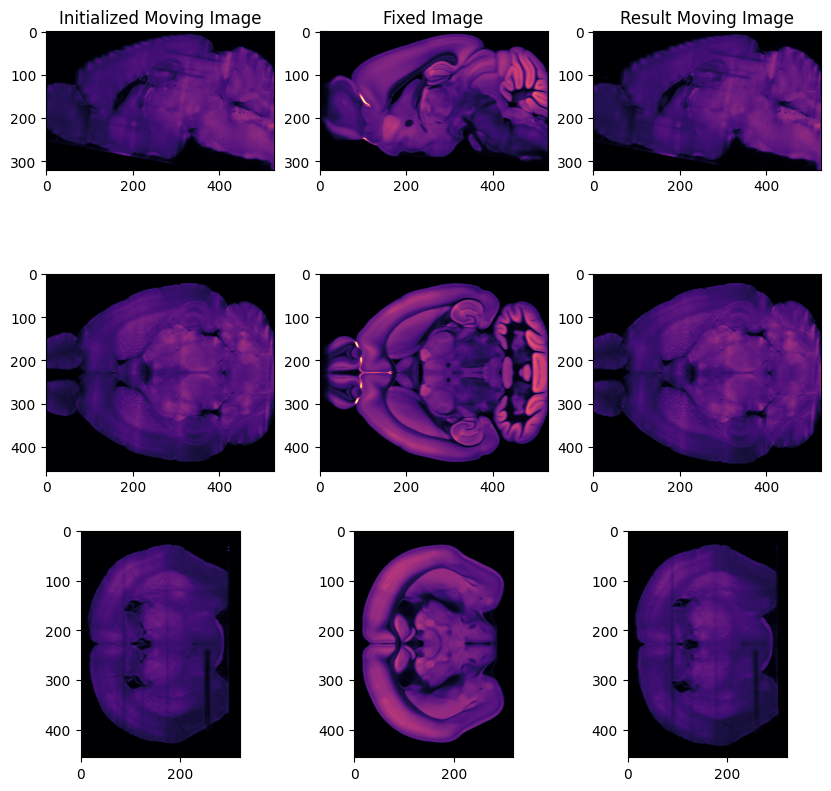

In [29]:
SLICE_INDICES = [200, 150, 250]
IMAGES = [moving_image_init, fixed_image, resampled_image]
IMAGE_NAMES = ["Initialized Moving Image", "Fixed Image", "Result Moving Image"]

import matplotlib as mpl

pltkwargs = {
    "cmap": plt.get_cmap("magma"),
    "norm": mpl.colors.Normalize(vmin=np.min(fixed_image), vmax=np.max(fixed_image)),
}

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=[10, 10])
for image_idx, image in enumerate(IMAGES):
    axs[0, image_idx].imshow(image[SLICE_INDICES[0], :, :], **pltkwargs)
    axs[1, image_idx].imshow(image[:, SLICE_INDICES[1], :], **pltkwargs)
    axs[2, image_idx].imshow(image[:, :, SLICE_INDICES[2]], **pltkwargs)

for image_idx, image_name in enumerate(IMAGE_NAMES):
    axs[0, image_idx].set_title(image_name)

## Evaluate Results

We visually evaluate to determine how well distributed registration improved on the initial fixed-to-image transform.

The initial difference image has a voxel delta of +/-150, whereas the registered image has a voxel delta of +/-3.

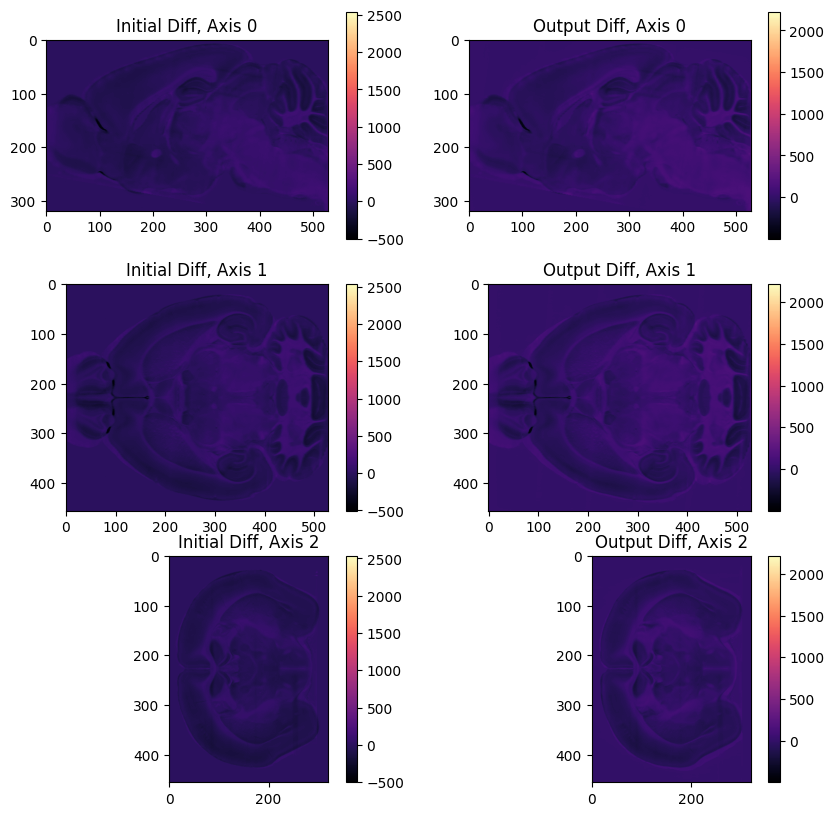

In [30]:
initialized_diff_image = itk.array_view_from_image(
    moving_image_init
) - itk.array_view_from_image(fixed_image)
result_diff_image = itk.array_view_from_image(
    resampled_image
) - itk.array_view_from_image(fixed_image)

init_kwargs = {
    "cmap": plt.get_cmap("magma"),
    "norm": mpl.colors.Normalize(
        vmin=np.min(initialized_diff_image), vmax=np.max(initialized_diff_image)
    ),
}

result_kwargs = {
    "cmap": plt.get_cmap("magma"),
    "norm": mpl.colors.Normalize(
        vmin=np.min(result_diff_image), vmax=np.max(result_diff_image)
    ),
}

SLICE_INDICES = [200, 150, 250]
IMAGES = (initialized_diff_image, result_diff_image)
IMAGE_NAMES = ("Initial Diff", "Output Diff")
IMAGE_PLT_KWARGS = (init_kwargs, result_kwargs)

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=[10, 10])
for image_idx, (image, pltkwargs) in enumerate(zip(IMAGES, IMAGE_PLT_KWARGS)):
    axs[0, image_idx].imshow(image[SLICE_INDICES[0], :, :], **pltkwargs)
    axs[1, image_idx].imshow(image[:, SLICE_INDICES[1], :], **pltkwargs)
    axs[2, image_idx].imshow(image[:, :, SLICE_INDICES[2]], **pltkwargs)
    for ax_idx in range(3):
        plt.colorbar(
            mappable=mpl.cm.ScalarMappable(**pltkwargs), ax=axs[ax_idx, image_idx]
        )
        axs[ax_idx, image_idx].set_title(f"{IMAGE_NAMES[image_idx]}, Axis {ax_idx}")